# Import Libraries needed

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

from imblearn.over_sampling import ADASYN, BorderlineSMOTE, KMeansSMOTE, RandomOverSampler, SMOTE, SMOTEN, SMOTENC, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

# Import dataset and display head records, columns and basic information

In [2]:
data = pd.read_csv('diabetic_data.csv')
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [9]:
data.weight[~(data.weight.isnull())]

0         ?
1         ?
2         ?
3         ?
4         ?
         ..
101761    ?
101762    ?
101763    ?
101764    ?
101765    ?
Name: weight, Length: 101766, dtype: object

In [10]:
data.weight.value_counts()

?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64

In [11]:
data[['patient_nbr','encounter_id','admission_type_id','discharge_disposition_id','admission_source_id','diag_1','diag_2','diag_3']] = data[['patient_nbr','encounter_id','admission_type_id','discharge_disposition_id','admission_source_id','diag_1','diag_2','diag_3']].astype('object')

In [7]:
print('No of records : {}\nNo of features : {}'.format(data.shape[0],data.shape[1]))
print('Numerical features : {} \nCategorical features : {}'.format(data.select_dtypes(exclude=object).shape[1],data.select_dtypes(include=object).shape[1]))

No of records : 101766
No of features : 50
Numerical features : 8 
Categorical features : 42


In [9]:
print((data.readmitted.value_counts()/len(data))*100)

NO     53.911916
>30    34.928169
<30    11.159916
Name: readmitted, dtype: float64


In [10]:
print('No of unique encounters : {}\nNo of unique patients : {}'.format(data.encounter_id.nunique(),data.patient_nbr.nunique()))

No of unique encounters : 101766
No of unique patients : 71518


**Inference** 

- The target variable --> Readmission class is imbalanced
- Encounter ID and the patient number are unique number specifit to the encounter and the patient and does not have any predictive capability

### Null values

In [12]:
print('Direct null values in dataset : ',data.isnull().sum().sum())

Direct null values in dataset :  0


In [13]:
(((data == '?').sum(axis=0)/len(data))*100).sort_values(ascending=False).head(7)

weight               96.858479
medical_specialty    49.082208
payer_code           39.557416
race                  2.233555
diag_3                1.398306
diag_2                0.351787
diag_1                0.020636
dtype: float64

**Inference**

- Null values are not directly present in the data
- It is substitued with '?' character
- Weight, medical specialty and payer code have high % of missing values and it has to be dropped
- Race, diag_1, diag_2 and diag_3 features have minor % missing values and it can be imputed and used

### Data Cleaning

In [14]:
data_new = data.drop(columns=['encounter_id','patient_nbr','payer_code','medical_specialty'],axis=1)

In [15]:
data_new[['readmitted']] = data_new[['readmitted']].replace({'NO':0,'>30':0,'<30':1}).astype(object)

In [16]:
cols = ['race','diag_1','diag_2','diag_3']
for i in cols:
    data_new[i] = data_new[i].replace({'?':np.NaN})

In [17]:
data_new['race'] = data_new['race'].fillna(method='bfill')

In [18]:
cols = ['diag_1','diag_2','diag_3']
for i in cols:
    data_new[i] = data_new[i].fillna(value='None')

In [19]:
data_new.diag_3.str[0].unique()

array(['N', '2', 'V', '4', '3', '9', '1', '6', '7', '5', '8', 'E'],
      dtype=object)

- Features related to diagnosis have some values starting with V or E, these needs to be changed

### Data Encoding

In [20]:
def num_diag_conversion(x):
    if (x >= 1) and (x<=139): return 'Infectious_Parasitic'
    elif (x >= 140) and (x<=239): return 'Neoplasms'
    elif (x >= 240) and (x<=279): return 'Endocrine'
    elif (x >= 280) and (x<=289): return 'Blood_Blood-Organs'
    elif (x >= 290) and (x<=319): return 'Mental_Disorders'
    elif (x >= 320) and (x<=389): return 'Nervous_System'
    elif (x >= 390) and (x<=459): return 'Circulatory_System'
    elif (x >= 460) and (x<=519): return 'Respiratory_System'
    elif (x >= 520) and (x<=579): return 'Digestive_System'
    elif (x >= 580) and (x<=629): return 'Genitourinary_System'
    elif (x >= 630) and (x<=677): return 'Pregnancy_Childbirth'
    elif (x >= 680) and (x<=709): return 'Skin'
    elif (x >= 710) and (x<=739): return 'Musculoskeletal_System'
    elif (x >= 740) and (x<=759): return 'Congential'
    elif (x >= 760) and (x<=779): return 'Perinatal_Period'
    elif (x >= 780) and (x<=799): return 'Ill-Defined_Conditions'
    elif (x >= 800) and (x<=999): return 'Injury_Poisoning'
    else: return 'Other'

def diag_conversion(y):
    if y[0] == 'V': return 'SC_Injury_Poisoning'
    elif y[0] == 'E': return 'SC_Contact_Health_Services'
    elif y[0] == 'N': return y
    else: return num_diag_conversion(float(y))

In [21]:
col = ['diag_1','diag_2','diag_3']
for i in col:
    data_new[i] = data_new[i].apply(diag_conversion)

In [22]:
data_new.admission_type_id = data_new.admission_type_id.replace({1: 'Emergency',2: 'Emergency',3: 'Elective',4: 'Newborn',5: 'Unavailable',6: 'Unavailable',\
                                                             7: 'Emergency',8: 'Unavailable'})

In [23]:
data_new.discharge_disposition_id = data_new.discharge_disposition_id.replace({1: 'Home',2: 'Transfer',3: 'Transfer',4: 'Transfer',\
                                                                           5: 'Transfer',6: 'Home',7: 'DAMA',8: 'Home',9: 'Patient',\
                                                                           10: 'Transfer',11: 'Expired',12: 'Patient',13: 'Hospice',\
                                                                           14: 'Hospice',15: 'Transfer',16: 'Transfer',17: 'Transfer',\
                                                                           18: 'Unavailable',19: 'Expired',20: 'Expired',21: 'Expired',\
                                                                           22: 'Transfer',23: 'Transfer',24: 'Transfer',25: 'Unavailable',\
                                                                           26: 'Unavailable',30: 'Transfer',27: 'Transfer',28: 'Transfer',\
                                                                           29: 'Transfer',})

In [24]:
data_new.admission_source_id = data_new.admission_source_id.replace({1: 'Referral',2: 'Referral',3: 'Referral',4: 'Transfer',\
                                                                 5: 'Transfer',6: 'Transfer',7: 'Emergency',8: 'Court/Law Enforcement',\
                                                                 9: 'Unavailable',10: 'Transfer',11: 'related to child',12: 'related to child',\
                                                                 13: 'related to child',14: 'related to child',15: 'Unavailable',\
                                                                 17: 'Unavailable',18: 'Transfer',19: 'Readmission',20: 'Unavailable',\
                                                                 21: 'Unavailable',22: 'Transfer',23: 'related to child',24: 'related to child',\
                                                                 25: 'Transfer',26: 'Transfer',})

In [25]:
(((data_new == '?').sum(axis=0)/len(data_new))*100).sort_values(ascending=False).head()

weight       96.858479
race          0.000000
examide       0.000000
glipizide     0.000000
glyburide     0.000000
dtype: float64

In [26]:
data_new = data_new[~(data_new.discharge_disposition_id == 'Expired')]

### Weight

In [318]:
data_weight = data_new[~(data_new.weight.replace({'?':np.NaN}).isnull())].drop(columns='readmitted')
data_weight.weight.value_counts()

[75-100)     1320
[50-75)       881
[100-125)     622
[125-150)     143
[25-50)        94
[0-25)         48
[150-175)      34
[175-200)      11
>200            3
Name: weight, dtype: int64

In [319]:
data_weight.weight.unique()

array(['[75-100)', '[50-75)', '[0-25)', '[100-125)', '[25-50)',
       '[125-150)', '[175-200)', '[150-175)', '>200'], dtype=object)

<AxesSubplot:xlabel='count', ylabel='weight'>

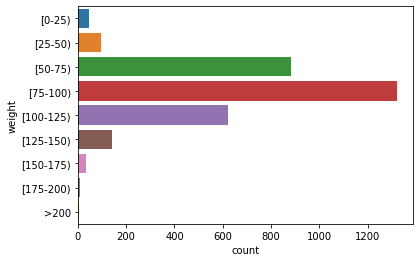

In [320]:
sns.countplot(y=data_weight.weight,\
              order=[ '[0-25)','[25-50)', '[50-75)','[75-100)', '[100-125)','[125-150)', '[150-175)', '[175-200)', '>200'])

In [321]:
data_weight.weight = data_weight.weight.replace({'[0-25)':'[0-75)','[25-50)':'[0-75)','[50-75)':'[0-75)','[100-125)':'[100-200)',\
                    '[125-150)':'[100-200)','[150-175)':'[100-200)', '[175-200)':'[100-200)','>200':'[100-200)'})

data_weight.weight.value_counts()

[75-100)     1320
[0-75)       1023
[100-200)     813
Name: weight, dtype: int64

In [322]:
data_weight.skew()

time_in_hospital      0.995114
num_lab_procedures   -0.546832
num_procedures        1.169220
num_medications       1.465763
number_outpatient     2.979167
number_emergency      6.314340
number_inpatient      5.892371
number_diagnoses     -1.624529
dtype: float64

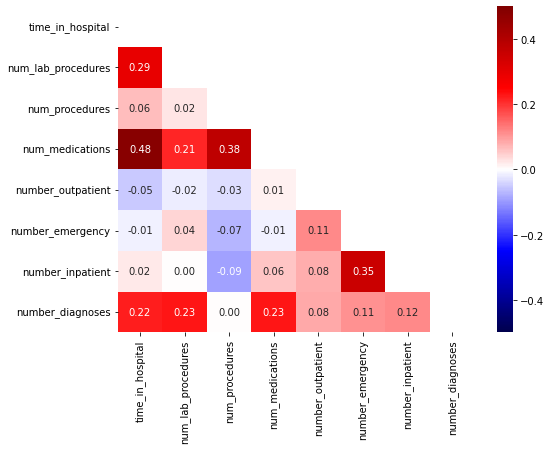

In [323]:
corre = data_weight.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corre,fmt='.2f',annot=True,cmap='seismic',vmin=-0.5,vmax=0.5,mask=np.triu(corre))
plt.show()

In [324]:
data_weight.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
1102,Caucasian,Male,[50-60),[75-100),Unavailable,Home,Unavailable,2,68,3,...,No,No,Steady,No,No,No,No,No,No,Yes
1108,Caucasian,Female,[80-90),[0-75),Unavailable,Transfer,Unavailable,9,74,5,...,No,No,Steady,No,No,No,No,No,Ch,Yes
1132,Caucasian,Female,[60-70),[0-75),Unavailable,Home,Unavailable,5,71,5,...,No,No,Steady,No,No,No,No,No,Ch,Yes
1136,Caucasian,Female,[40-50),[75-100),Unavailable,Home,Unavailable,3,56,3,...,No,No,Steady,No,No,No,No,No,Ch,Yes
1190,Caucasian,Female,[70-80),[75-100),Unavailable,Home,Unavailable,11,78,0,...,No,No,Steady,No,No,No,No,No,Ch,Yes


In [325]:
df_wgt_num = data_weight.select_dtypes(exclude=object)

In [326]:
cols = list(df_wgt_num.columns)

while True:
    vif = pd.DataFrame(index=cols)
    vif['vif'] = [variance_inflation_factor(df_wgt_num[cols].values,i) for i in range(len(cols))]
    colmax, vifmax = vif.idxmax().values, vif.max().values
    if vifmax >= 10:
        print(colmax,vifmax)
        cols.remove(colmax)
    else:
        sig_cols_wgt = cols 
        break

vif.sort_values(by='vif',ascending=False)

['number_diagnoses'] [11.78125433]


,vif
num_medications,7.657513
num_lab_procedures,5.275497
time_in_hospital,4.995936
num_procedures,2.052213
number_inpatient,1.408604
number_outpatient,1.326574
number_emergency,1.270228


In [327]:
df_wgt_num.drop(columns='number_diagnoses',inplace=True)

## Statistical test for numerical variables:

#### Shapiro_test

In [33]:
#Normality test(Shapiro):

#Ho : skew = 0 (Data is normal)
#Ha : skew = 0 (Data is not normal)

In [328]:
df_wgt_num.head(5)

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient
1102,2,68,3,15,0,0,0
1108,9,74,5,27,0,0,0
1132,5,71,5,23,0,0,0
1136,3,56,3,15,0,0,0
1190,11,78,0,18,0,0,1


In [329]:
data_weight.weight.unique()

array(['[75-100)', '[0-75)', '[100-200)'], dtype=object)

In [330]:
df_shapiro_wgt_num = pd.DataFrame(index=df_wgt_num.columns,columns=['pval'+str(i+1) for i in range(data_weight.weight.nunique())])
for i in df_wgt_num.columns:
    
    group_1 = df_wgt_num[i][data_weight.weight == '[0-75)']
    group_2 = df_wgt_num[i][data_weight.weight == '[75-100)']
    group_3 = df_wgt_num[i][data_weight.weight == '[100-200)']
    
    w1,pval1 = stats.shapiro(group_1)
    w2,pval2 = stats.shapiro(group_2)
    w3,pval3 = stats.shapiro(group_3)
    
    df_shapiro_wgt_num.loc[i] = [pval1,pval2,pval3]

In [331]:
df_shapiro_wgt_num

,pval1,pval2,pval3
time_in_hospital,0.0,0.0,0.0
num_lab_procedures,0.0,0.0,0.0
num_procedures,0.0,0.0,0.0
num_medications,0.0,0.0,0.0
number_outpatient,0.0,0.0,0.0
number_emergency,0.0,0.0,0.0
number_inpatient,0.0,0.0,0.0


**From the Shapiro test**

- We fail to accept the groups of all of the features are normally distributed

Since the assumption of th Anova is violated, we have to proceed with non parametric tests such as **Kruskal Wallis test** to understand the significance of the variables

## Krukal wallis test

- Ho : All the samples have the same median
- Ha : Atleast one of the samples have different median

In [332]:
df_wgt_krus = pd.DataFrame(index=df_wgt_num.columns,columns=['Ustat','pval'])
for i in df_wgt_num.columns:
    
    group_1 = df_wgt_num[i][data_weight.weight == '[0-75)']
    group_2 = df_wgt_num[i][data_weight.weight == '[75-100)']
    group_3 = df_wgt_num[i][data_weight.weight == '[100-200)']
    
    hstat,pval = stats.kruskal(group_1,group_2,group_3)
    df_wgt_krus.loc[i,'Ustat'] = hstat
    df_wgt_krus.loc[i,'pval'] = pval

In [333]:
df_wgt_krus

,Ustat,pval
time_in_hospital,11.341703,0.003445
num_lab_procedures,17.617478,0.000149
num_procedures,31.352129,0.0
num_medications,10.698131,0.004753
number_outpatient,6.292686,0.043009
number_emergency,2.290377,0.318164
number_inpatient,6.986682,0.030399


In [334]:
sig_cols_wgt = list(df_wgt_krus[df_wgt_krus.pval > 0.05].index)

In [335]:
sig_cols_wgt

['number_emergency']

**From the Kruskal Wallis test**

The following feature is statistically significant in predicition
- Number of emergency


## Statistical test for categorical variables:

In [42]:
#Hypothesis Framing

Hypothesis = {'Ho':'There is no relation between independent features and readmitted',
              'Ha':'There is relation between independent features and readmitted'}

In [336]:
df_wgt_cat = data_weight.select_dtypes(include=object).drop(columns='weight')

col_wgt_obj = list(df_wgt_cat.columns)
df_Chi2_contingency_wgt_cat = pd.DataFrame({'Features':col_wgt_obj})
P_value = []
dof = []
for i in col_wgt_obj:
    obs = pd.crosstab(df_wgt_cat[i],data_weight.weight)
    chi_sq,p_val,ddof,exp = stats.chi2_contingency(obs,correction=True)
    P_value.append(p_val)
    dof.append(ddof)
    
df_Chi2_contingency_wgt_cat['P_val'] = P_value

In [337]:
insig_cat = df_Chi2_contingency_wgt_cat[df_Chi2_contingency_wgt_cat['P_val'] > 0.05].sort_values(by='P_val',ascending=True)
sig_cat = df_Chi2_contingency_wgt_cat[df_Chi2_contingency_wgt_cat['P_val'] <= 0.05].sort_values(by='P_val',ascending=True)
print(len(col_wgt_obj),len(insig_cat))

36 22


In [338]:
sig_cols_wgt_cat = list(sig_cat.Features.values)
sig_cols_wgt.extend(sig_cols_wgt_cat)

In [339]:
print(sig_cols_wgt)

['number_emergency', 'age', 'gender', 'admission_source_id', 'discharge_disposition_id', 'diag_1', 'admission_type_id', 'metformin', 'pioglitazone', 'diag_2', 'A1Cresult', 'rosiglitazone', 'race', 'change', 'diag_3']


In [340]:
df_wgt_final = pd.get_dummies(data_weight[sig_cols_wgt],columns=sig_cols_wgt_cat)

## Splitting the dataset
xtrain_wgt, xtest_wgt, ytrain_wgt, ytest_wgt = train_test_split(df_wgt_final,data_weight.weight,train_size=0.8,random_state=10)

## Sampling techniques for imbalance
smt_wgt = SMOTE(random_state=7)
xtrain_wgt_smt, ytrain_wgt_smt = smt_wgt.fit_resample(xtrain_wgt,ytrain_wgt)

rus_wgt = RandomOverSampler(random_state=7)
xtrain_wgt_rus, ytrain_wgt_rus = rus_wgt.fit_resample(xtrain_wgt,ytrain_wgt)

In [341]:
## Model built and checked for any influential outliers and performance
dtc_wgt = RandomForestClassifier(random_state=10)
dtc_wgt.fit(xtrain_wgt_smt, ytrain_wgt_smt)
y_train_pred_wgt_dt = dtc_wgt.predict(xtrain_wgt_smt)
y_test_pred_wgt_dt = dtc_wgt.predict(xtest_wgt)
print('\n\nDecision Tree Classification report for Training weight :\n\n',classification_report(ytrain_wgt_smt, y_train_pred_wgt_dt))
print('\n\nDecision Tree Classification report for Testing weight :\n\n',classification_report(ytest_wgt, y_test_pred_wgt_dt))



Decision Tree Classification report for Training weight :

               precision    recall  f1-score   support

      [0-75)       0.98      0.98      0.98      1059
   [100-200)       0.98      0.97      0.97      1059
    [75-100)       0.96      0.97      0.97      1059

    accuracy                           0.97      3177
   macro avg       0.97      0.97      0.97      3177
weighted avg       0.97      0.97      0.97      3177



Decision Tree Classification report for Testing weight :

               precision    recall  f1-score   support

      [0-75)       0.50      0.57      0.53       205
   [100-200)       0.39      0.45      0.42       166
    [75-100)       0.46      0.36      0.41       261

    accuracy                           0.45       632
   macro avg       0.45      0.46      0.45       632
weighted avg       0.45      0.45      0.45       632



In [342]:
dtc_wgt.fit(xtrain_wgt_rus, ytrain_wgt_rus)
y_train_pred_wgt_dt = dtc_wgt.predict(xtrain_wgt_rus)
y_test_pred_wgt_dt = dtc_wgt.predict(xtest_wgt)
print('\n\nDecision Tree Classification report for Training weight :\n\n',classification_report(ytrain_wgt_rus, y_train_pred_wgt_dt))
print('\n\nDecision Tree Classification report for Testing weight :\n\n',classification_report(ytest_wgt, y_test_pred_wgt_dt))



Decision Tree Classification report for Training weight :

               precision    recall  f1-score   support

      [0-75)       0.98      0.97      0.98      1059
   [100-200)       0.96      0.98      0.97      1059
    [75-100)       0.98      0.96      0.97      1059

    accuracy                           0.97      3177
   macro avg       0.97      0.97      0.97      3177
weighted avg       0.97      0.97      0.97      3177



Decision Tree Classification report for Testing weight :

               precision    recall  f1-score   support

      [0-75)       0.50      0.57      0.53       205
   [100-200)       0.39      0.43      0.41       166
    [75-100)       0.47      0.39      0.42       261

    accuracy                           0.46       632
   macro avg       0.45      0.46      0.45       632
weighted avg       0.46      0.46      0.45       632



### Weight

In [27]:
data_new.drop(columns='weight',inplace=True)

In [22]:
data_new.isnull().sum().sum()

0

In [28]:
df_num = data_new.select_dtypes(exclude=object)
df_cat = data_new.select_dtypes(include=object).drop(columns='readmitted')

### Exploratory analysis

In [29]:
df_num.describe().T

,count,mean,std,min,25%,50%,75%,max
time_in_hospital,100114.0,4.389646,2.974531,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,100114.0,42.943305,19.620940,1.0,31.0,44.0,57.0,132.0
num_procedures,100114.0,1.330723,1.700286,0.0,0.0,1.0,2.0,6.0
num_medications,100114.0,15.981821,8.092511,1.0,10.0,15.0,20.0,81.0
number_outpatient,100114.0,0.369429,1.264006,0.0,0.0,0.0,0.0,42.0
number_emergency,100114.0,0.198334,0.935537,0.0,0.0,0.0,0.0,76.0
number_inpatient,100114.0,0.632829,1.261833,0.0,0.0,0.0,1.0,21.0
number_diagnoses,100114.0,7.409164,1.938288,1.0,6.0,8.0,9.0,16.0


In [30]:
df_cat.iloc[:,18:].describe().T

,count,unique,top,freq
glyburide,100114,4,No,89547
tolbutamide,100114,2,No,100093
pioglitazone,100114,4,No,92833
rosiglitazone,100114,4,No,93785
acarbose,100114,4,No,99807
miglitol,100114,4,No,100076
troglitazone,100114,2,No,100111
tolazamide,100114,3,No,100075
examide,100114,1,No,100114
citoglipton,100114,1,No,100114


In [31]:
df_num.skew()

time_in_hospital       1.137881
num_lab_procedures    -0.241460
num_procedures         1.326129
num_medications        1.333118
number_outpatient      8.818131
number_emergency      22.842144
number_inpatient       3.626474
number_diagnoses      -0.867589
dtype: float64

#### Numerical univariate analysis

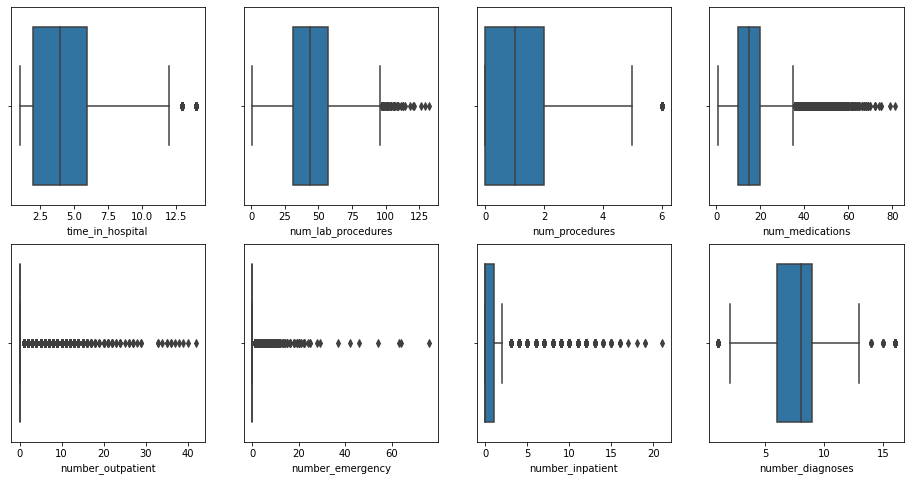

In [349]:
plt.figure(figsize=(16,8))
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8 = plt.subplot(2,4,1), plt.subplot(2,4,2), plt.subplot(2,4,3), plt.subplot(2,4,4),\
                                  plt.subplot(2,4,5), plt.subplot(2,4,6), plt.subplot(2,4,7), plt.subplot(2,4,8)
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]
for axis, col in zip(axes,df_num.columns): 
    sns.boxplot(x=df_num[col],ax=axis)
plt.savefig('Outliers_box_plot.jpg')
plt.show()

#### Numerical vs Numerical analysis

### Bivariate analysis

In [ ]:
cat_col = list(df_cat.columns)
cat_comb = []
for i in list(df_cat.columns):
    cat_col.remove(i)
    for j in cat_col:
        cat_comb.append((i,j))
len(cat_comb)

In [ ]:
cat_col = list(df_cat.columns)
num_col = list(df_num.columns)
cat_num_comb = []
for i in cat_col:
    for j in num_col:
        cat_num_comb.append((i,j))
len(cat_num_comb)

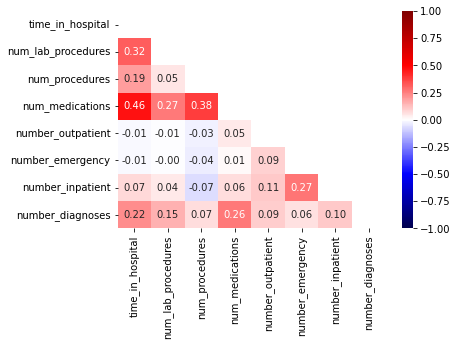

In [350]:
corre = df_num.corr()
sns.heatmap(corre,annot=True,fmt='.2f',cmap='seismic',vmin=-1,vmax=1,mask=np.triu(corre))
plt.show()

In [351]:
vif = pd.DataFrame({'Features':df_num.columns})
vif['vif'] = [variance_inflation_factor(df_num.values,i) for i in range(df_num.shape[1])]
cols = vif.sort_values(by='vif',ascending=False).head(2).Features
vif.sort_values(by='vif',ascending=False)

,Features,vif
7,number_diagnoses,7.502223
3,num_medications,7.372191
1,num_lab_procedures,5.908211
0,time_in_hospital,4.341328
2,num_procedures,1.912785
6,number_inpatient,1.383759
5,number_emergency,1.132552
4,number_outpatient,1.114893


**Inference**

- More than 75% of the values in number_outpatient and num_emergency are 0
- More than 50% of the values in number_inpatient is 0
- These columns, thus exhibit, high skewness with extreme outliers
- Hence dividing these features in bins and changing it as categorical variable
- There is no multicollinearity existing between the independent features

- Since we dont want to lose any useful information with dropping outliers, we are splitting the dataset into two 
 - non-outliers 
 - outliers,
based on the IQR method on num_medications and num_lab_procedures features which have the outliers and analysed further

## Statistical test for numerical variables:

#### Shapiro_test

In [ ]:
#Normality test(Shapiro):

#Ho : skew = 0 (Data is normal)
#Ha : skew = 0 (Data is not normal)

In [352]:
df_shapiro_num = pd.DataFrame(index=df_num.columns,columns=['W-stat1','pval1','W-stat2','pval2'])
for i in df_num.columns:
    group_1 = df_num[i][data_new.readmitted == 0]
    group_2 = df_num[i][data_new.readmitted == 1]
    w1,pval1 = stats.shapiro(group_1)
    w2,pval2 = stats.shapiro(group_2)
    df_shapiro_num.loc[i] = [w1,pval1,w2,pval2]

In [353]:
df_shapiro_num

,W-stat1,pval1,W-stat2,pval2
time_in_hospital,0.883793,0.0,0.908447,0.0
num_lab_procedures,0.984642,0.0,0.984756,0.0
num_procedures,0.772661,0.0,0.772007,0.0
num_medications,0.923293,0.0,0.92763,0.0
number_outpatient,0.306267,0.0,0.36767,0.0
number_emergency,0.189105,0.0,0.260778,0.0
number_inpatient,0.552219,0.0,0.658831,0.0
number_diagnoses,0.811684,0.0,0.767513,0.0


**From the Shapiro test**

- We fail to accept the groups of all of the features are normally distributed

Since the assumption of th t-test is violated, we have to proceed with non parametric tests such as **Mann-whitney u test** to understand the significance of the variables

## Mann Whitney U test

- Ho : The two samples have the same median
- Ha : The two samples have different median

In [29]:
df_mw = pd.DataFrame(index=df_num.columns,columns=['Ustat','pval'])
for i in df_num.columns:
    group_1 = df_num[i][data_new.readmitted == 0]
    group_2 = df_num[i][data_new.readmitted == 1]
    hstat,pval = stats.mannwhitneyu(group_1,group_2)
    df_mw.loc[i,'Ustat'] = hstat
    df_mw.loc[i,'pval'] = pval

In [30]:
df_mw

,Ustat,pval
time_in_hospital,456964894.5,0.0
num_lab_procedures,482476474.5,0.0
num_procedures,500248644.0,0.084898
num_medications,460499432.5,0.0
number_outpatient,483724861.0,0.0
number_emergency,471842855.5,0.0
number_inpatient,396062924.5,0.0
number_diagnoses,460784845.5,0.0


**From the Mann Whitney U test**

Apart from num_procedures, all other features are statistically significant

## Statistical test for categorical variables:

In [31]:
#Hypothesis Framing

Hypothesis = {'Ho':'There is no relation between independent features and readmitted',
              'Ha':'There is relation between independent features and readmitted'}

In [32]:
col_obj = list(df_cat.columns)
df_Chi2_contingency_cat = pd.DataFrame({'Features':col_obj})
P_value = []
dof = []
for i in col_obj:
    obs = pd.crosstab(df_cat[i],data_new.readmitted)
    chi_sq,p_val,ddof,exp = stats.chi2_contingency(obs,correction=True)
    P_value.append(p_val)
    dof.append(ddof)
    
df_Chi2_contingency_cat['P_val'] = P_value

In [33]:
insig_cat = df_Chi2_contingency_cat[df_Chi2_contingency_cat['P_val'] > 0.05].sort_values(by='P_val',ascending=True)
sig_cat = df_Chi2_contingency_cat[df_Chi2_contingency_cat['P_val'] <= 0.05].sort_values(by='P_val',ascending=True)
print(len(col_obj),len(insig_cat))

36 20


In [34]:
sig_cat

,Features,P_val
4,discharge_disposition_id,1.199518e-157
28,insulin,4.338329e-42
8,diag_3,1.146065e-29
6,diag_1,6.987563e-29
2,age,2.413689e-23
7,diag_2,1.364658e-17
35,diabetesMed,2.693943e-16
11,metformin,9.143552e-15
34,change,7.703322e-09
10,A1Cresult,8.046436e-09


## Splitting the dataset into 2 - With and Without outliers

In [35]:
data_new['number_outpatient'] = pd.cut(df_num.number_outpatient,bins=[-1,0,5,10,20,50],labels=['0','1-5','5-10','10-20','>20'])
data_new['number_emergency'] = pd.cut(df_num.number_emergency,bins=[-1,0,5,10,20,50],labels=['0','1-5','5-10','10-20','>20'])
data_new['number_inpatient'] = pd.cut(df_num.number_inpatient,bins=[-1,0,5,10,20,50],labels=['0','1-5','5-10','10-20','>20'])
df_num.drop(columns=['number_outpatient','number_inpatient','number_emergency'],inplace=True)

In [36]:
IQR_med = 1.5*(df_num.num_medications.quantile(0.75) - df_num.num_medications.quantile(0.25))
th_med = df_num.num_medications.quantile(0.75) + IQR_med
IQR_lp = 1.5*(df_num.num_lab_procedures.quantile(0.75) - df_num.num_lab_procedures.quantile(0.25))
th_lp = df_num.num_lab_procedures.quantile(0.75) + IQR_lp
df_num_non = df_num[(df_num.num_medications < th_med) & (df_num.num_lab_procedures < th_lp)]
df_num_out = df_num.drop(index=df_num_non.index)

In [37]:
th_med, th_lp

(35.0, 96.0)

In [38]:
df_cat_out = data_new.select_dtypes(include=[object,'category']).drop(columns='readmitted').loc[df_num_out.index]
df_cat_non = data_new.select_dtypes(include=[object,'category']).drop(columns='readmitted').drop(index=df_num_out.index)
y_out = data_new.readmitted.loc[df_num_out.index].astype(int)
y_non = data_new.readmitted.drop(index=df_num_out.index).astype(int)

In [39]:
df_num_non_mul = df_num_non.copy()
df_num_out_mul = df_num_out.copy()
df_cat_non_mul = df_cat_non.copy()
df_cat_out_mul = df_cat_out.copy()
y_out_multi = data.readmitted.replace({'NO':0,'>30':1,'<30':2}).loc[df_cat_out.index]
y_non_multi = data.readmitted.replace({'NO':0,'>30':1,'<30':2}).loc[df_cat_non.index]

> **Non outliers dataset**

In [40]:
df_num_non.describe().T

,count,mean,std,min,25%,50%,75%,max
time_in_hospital,97149.0,4.268268,2.885438,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,97149.0,42.429063,19.418049,1.0,31.0,44.0,56.0,95.0
num_procedures,97149.0,1.252808,1.631838,0.0,0.0,1.0,2.0,6.0
num_medications,97149.0,15.199755,6.683427,1.0,10.0,14.0,19.0,34.0
number_diagnoses,97149.0,7.388733,1.945739,1.0,6.0,8.0,9.0,16.0


In [34]:
df_num_non.skew()

time_in_hospital      1.181093
num_lab_procedures   -0.276473
num_procedures        1.392515
num_medications       0.479716
number_diagnoses     -0.855080
dtype: float64

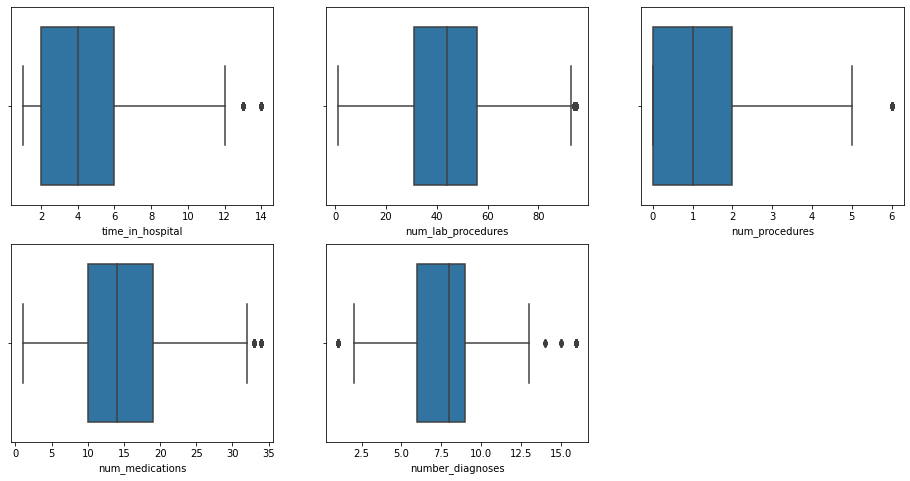

In [366]:
plt.figure(figsize=(16,8)) 
ax1,ax2,ax3,ax4,ax5 = plt.subplot(2,3,1), plt.subplot(2,3,2), plt.subplot(2,3,3), plt.subplot(2,3,4), plt.subplot(2,3,5)
axes = [ax1,ax2,ax3,ax4,ax5]
for axis, col in zip(axes,df_num_non.columns): 
    sns.boxplot(x=df_num_non[col],ax=axis)
plt.show()

> **Outliers dataset**

In [367]:
df_num_out.describe().T

,count,mean,std,min,25%,50%,75%,max
time_in_hospital,2965.0,8.366610,3.107742,1.0,6.0,8.0,11.0,14.0
num_lab_procedures,2965.0,59.792580,18.763204,1.0,46.0,58.0,72.0,132.0
num_procedures,2965.0,3.883642,1.910167,0.0,2.0,4.0,6.0,6.0
num_medications,2965.0,41.606408,8.428305,7.0,36.0,40.0,46.0,81.0
number_diagnoses,2965.0,8.078583,1.532232,2.0,7.0,9.0,9.0,16.0


In [368]:
df_num_out.skew()

time_in_hospital      0.092894
num_lab_procedures    0.186583
num_procedures       -0.334387
num_medications       0.547351
number_diagnoses     -1.210585
dtype: float64

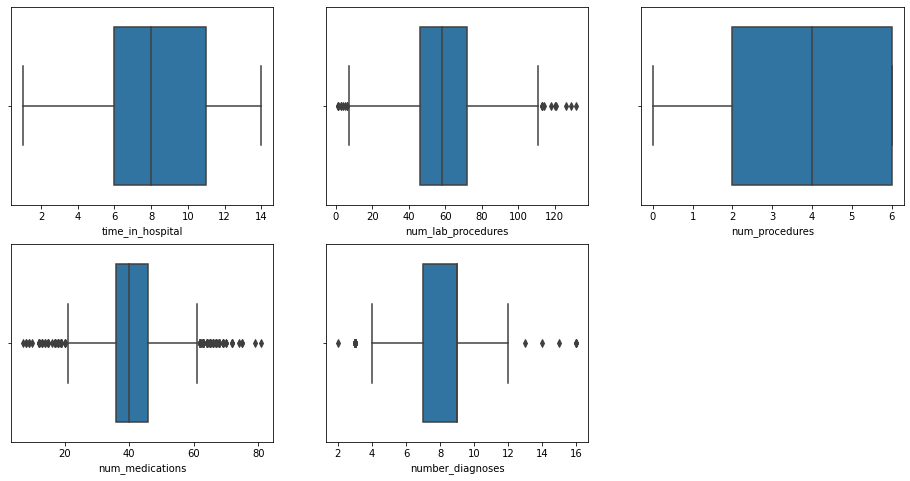

In [369]:
plt.figure(figsize=(16,8)) 
ax1,ax2,ax3,ax4,ax5 = plt.subplot(2,3,1), plt.subplot(2,3,2), plt.subplot(2,3,3), plt.subplot(2,3,4), plt.subplot(2,3,5)
axes = [ax1,ax2,ax3,ax4,ax5]
for axis, col in zip(axes,df_num_out.columns): 
    sns.boxplot(x=df_num_out[col],ax=axis)
plt.show()

## Mullicollinearity

> **Non outliers dataset**

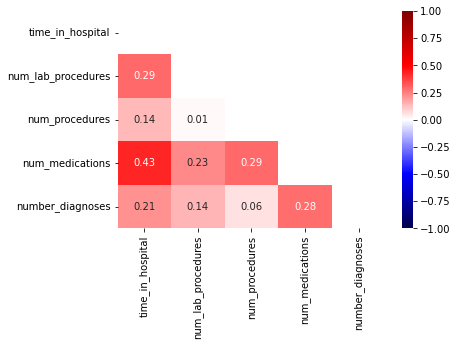

In [35]:
corre_non = df_num_non.corr()
sns.heatmap(corre_non,annot=True,fmt='.2f',cmap='seismic',vmin=-1,vmax=1,mask=np.triu(corre_non))
plt.savefig('correlation_non_outlier.jpg',dpi=50)
plt.show()

In [29]:
vif = pd.DataFrame({'Features':df_num_non.columns})
vif['vif'] = [variance_inflation_factor(df_num_non.values,i) for i in range(df_num_non.shape[1])]
cols = vif.sort_values(by='vif',ascending=False).head(2).Features
vif.sort_values(by='vif',ascending=False)

,Features,vif
3,num_medications,8.329758
4,number_diagnoses,8.144765
1,num_lab_procedures,5.769997
0,time_in_hospital,4.135921
2,num_procedures,1.736710


- In non outliers set, for all features vif value is less than 10 after transformation

**Hence, Multicollinearity does not exist in between numerical features**

> **Outliers dataset**

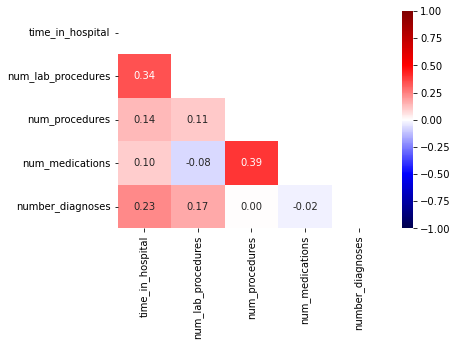

In [37]:
corre_out = df_num_out.corr()
sns.heatmap(corre_out,annot=True,fmt='.2f',cmap='seismic',vmin=-1,vmax=1,mask=np.triu(corre_out))
plt.savefig('correlation_outlier.jpg')
plt.show()

In [38]:
vif = pd.DataFrame({'Features':df_num_out.columns})
vif['vif'] = [variance_inflation_factor(df_num_out.values,i) for i in range(df_num_out.shape[1])]
cols = vif.sort_values(by='vif',ascending=False).head(2).Features
vif.sort_values(by='vif',ascending=False)

,Features,vif
4,number_diagnoses,19.607086
3,num_medications,18.826783
1,num_lab_procedures,11.759143
0,time_in_hospital,9.904283
2,num_procedures,6.228500


In [39]:
df_num_out1 = df_num_out.drop(columns='number_diagnoses')
vif = pd.DataFrame({'Features':df_num_out1.columns})
vif['vif'] = [variance_inflation_factor(df_num_out1.values,i) for i in range(df_num_out1.shape[1])]
cols = vif.sort_values(by='vif',ascending=False).head(2).Features
vif.sort_values(by='vif',ascending=False)

,Features,vif
3,num_medications,12.820406
1,num_lab_procedures,9.986889
0,time_in_hospital,9.292953
2,num_procedures,6.200342


In [40]:
df_num_out2 = df_num_out1.drop(columns='num_medications')
vif = pd.DataFrame({'Features':df_num_out2.columns})
vif['vif'] = [variance_inflation_factor(df_num_out2.values,i) for i in range(df_num_out2.shape[1])]
cols = vif.sort_values(by='vif',ascending=False).head(2).Features
vif.sort_values(by='vif',ascending=False)

,Features,vif
1,num_lab_procedures,8.582578
0,time_in_hospital,8.104641
2,num_procedures,4.506730


In [41]:
df_num_out = df_num_out.drop(columns=['number_diagnoses','num_medications'])

- In outliers set, num_medications and number_diagnoses have multicollinearity

**Hence, number_medications part is dropped and remaining features are selected**

# Binary Classification

## Statistical test for numerical variables:

#### Shapiro_test

In [82]:
#Normality test(Shapiro):

#Ho : skew = 0 (Data is normal)
#Ha : skew = 0 (Data is not normal)

In [42]:
df_shapiro_non = pd.DataFrame(index=df_num_non.columns,columns=['W-stat1','pval1','W-stat2','pval2'])
for i in df_num_non.columns:
    group_1 = df_num_non[i][y_non == 0]
    group_2 = df_num_non[i][y_non == 1]
    w1,pval1 = stats.shapiro(group_1)
    w2,pval2 = stats.shapiro(group_2)
    df_shapiro_non.loc[i] = [w1,pval1,w2,pval2]

df_shapiro_out = pd.DataFrame(index=df_num_out.columns,columns=['W-stat1','pval1','W-stat2','pval2'])
for i in df_num_out.columns:
    group_1 = df_num_out[i][y_out == 0]
    group_2 = df_num_out[i][y_out == 1]
    w1,pval1 = stats.shapiro(group_1)
    w2,pval2 = stats.shapiro(group_2)
    df_shapiro_out.loc[i] = [w1,pval1,w2,pval2]

In [43]:
df_shapiro_non

,W-stat1,pval1,W-stat2,pval2
time_in_hospital,0.880694,0.0,0.906584,0.0
num_lab_procedures,0.982629,0.0,0.982411,0.0
num_procedures,0.766375,0.0,0.763849,0.0
num_medications,0.977334,0.0,0.982883,0.0
number_diagnoses,0.813313,0.0,0.769901,0.0


In [33]:
df_shapiro_out

,W-stat1,pval1,W-stat2,pval2
time_in_hospital,0.969709,0.0,0.966513,0.0
num_lab_procedures,0.993029,0.0,0.991242,0.021075
num_procedures,0.873786,0.0,0.898663,0.0


**From the Shapiro test**

- We fail to accept the groups of all of the features are normally distributed

Since the assumption of th t-test is violated, we have to proceed with non parametric tests such as **Mann-whitney u test** to understand the significance of the variables

## Mann Whitney U test

- Ho : The two samples have the same median
- Ha : The two samples have different median

In [44]:
df_mw_non = pd.DataFrame(index=df_num_non.columns,columns=['hstat','pval'])
for i in df_num_non.columns:
    group_1 = df_num_non[i][y_non == 0]
    group_2 = df_num_non[i][y_non == 1]
    hstat,pval = stats.mannwhitneyu(group_1,group_2)
    df_mw_non.loc[i,'hstat'] = hstat
    df_mw_non.loc[i,'pval'] = pval
    
df_mw_out = pd.DataFrame(index=df_num_out.columns,columns=['hstat','pval'])
for i in df_num_out.columns:
    group_1 = df_num_out[i][y_out == 0]
    group_2 = df_num_out[i][y_out == 1]
    hstat,pval = stats.mannwhitneyu(group_1,group_2)
    df_mw_out.loc[i,'hstat'] = hstat
    df_mw_out.loc[i,'pval'] = pval

In [45]:
df_mw_non

,hstat,pval
time_in_hospital,428995684.0,0.0
num_lab_procedures,453602784.0,0.0
num_procedures,467899550.0,0.034735
num_medications,431840622.0,0.0
number_diagnoses,431310710.5,0.0


In [46]:
df_mw_out

,hstat,pval
time_in_hospital,455426.0,0.001806
num_lab_procedures,472488.0,0.03484
num_procedures,463000.5,0.006617


**From the Mann Whitney U test**

- We reject the null hypothesis and all the numerical features are statistically significant

## Categorical variables

### Non outlier dataset

In [47]:
#Hypothesis Framing

# Ho : The variables are independent
# Ha : The variables are dependent

Hypothesis = {'Ho':'There is no relation between independent and readmitted',
              'Ha':'There is relation between independent and readmitted'}

In [47]:
col_obj_non = list(df_cat_non.columns)
df_Chi2_contingency_non = pd.DataFrame({'Features':col_obj_non})
P_value = []
dof = []
for i in col_obj_non:
    obs = pd.crosstab(df_cat_non[i],y_non)
    chi_sq,p_val,ddof,exp = stats.chi2_contingency(obs,correction=True)
    P_value.append(p_val)
    dof.append(ddof)
    
df_Chi2_contingency_non['P_val'] = P_value

In [48]:
insig_cat_non = df_Chi2_contingency_non[df_Chi2_contingency_non['P_val'] > 0.05].sort_values(by='P_val',ascending=True)
sig_cat_non = df_Chi2_contingency_non[df_Chi2_contingency_non['P_val'] <= 0.05].sort_values(by='P_val',ascending=True)
print(len(df_Chi2_contingency_non),len(sig_cat_non))

39 18


In [49]:
sig_cat_non

,Features,P_val
8,number_inpatient,0.000000e+00
4,discharge_disposition_id,4.151895e-151
7,number_emergency,2.893380e-91
31,insulin,6.862233e-41
9,diag_1,6.554512e-29
11,diag_3,4.296310e-27
2,age,2.302949e-24
6,number_outpatient,2.561592e-24
10,diag_2,4.003926e-17
38,diabetesMed,7.546653e-16


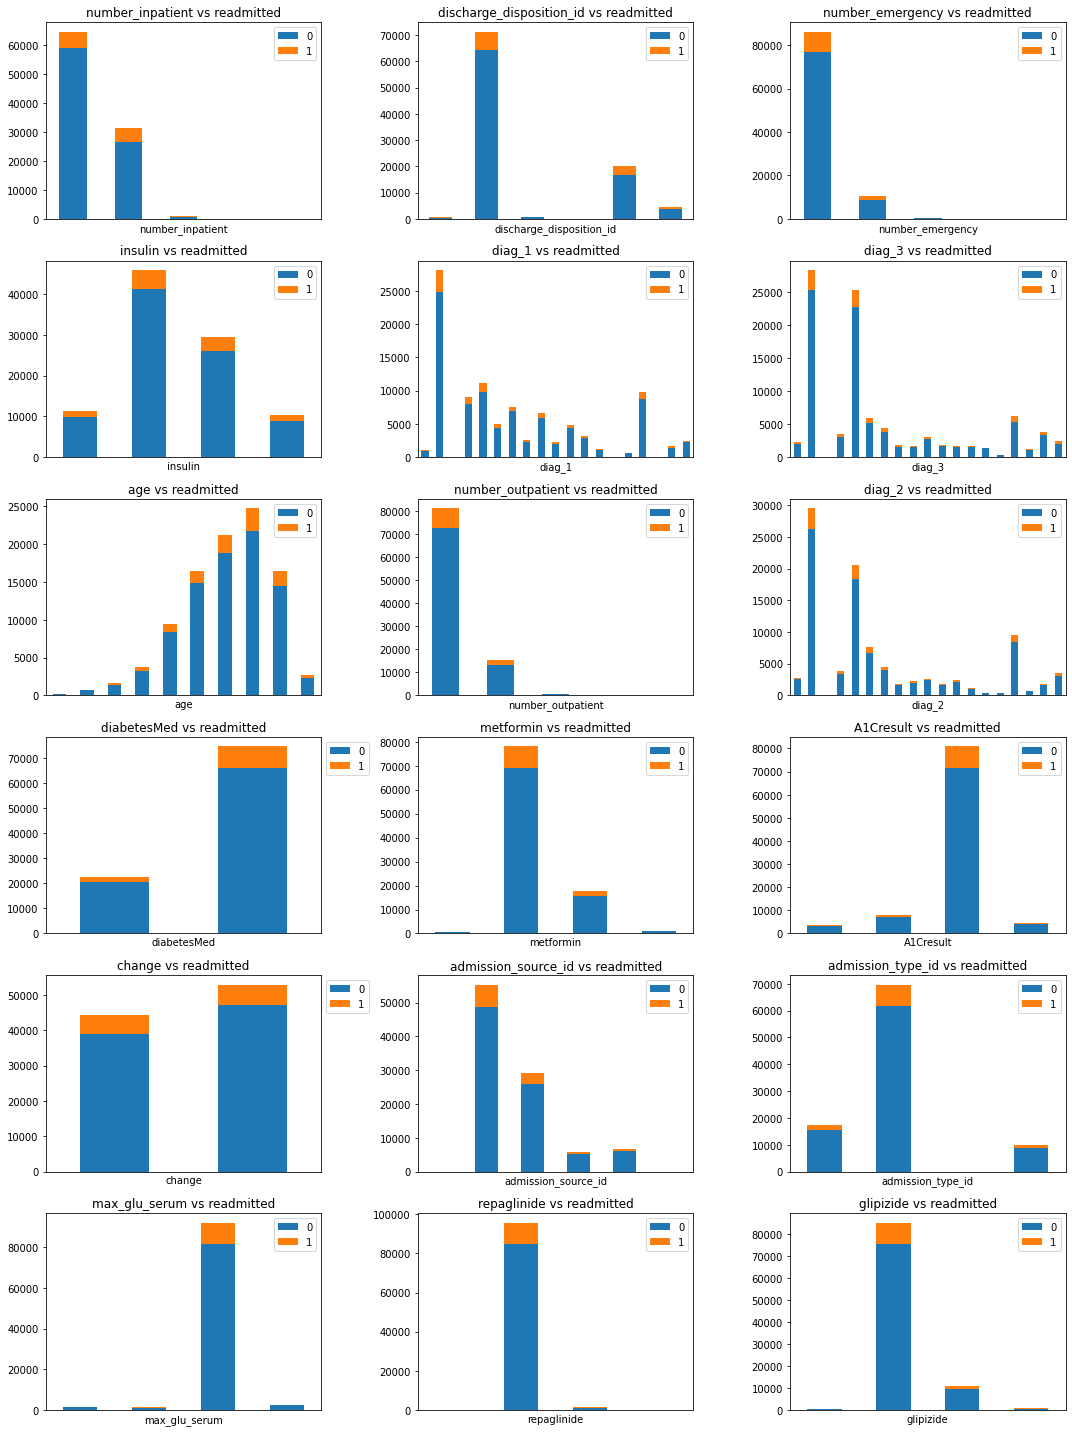

In [51]:
plt.figure(figsize=(15,20))
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18= [plt.subplot(6,3,i+1) for i in range(18)]
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18]
sig_cols = list(sig_cat_non['Features'])

for axis,col in zip(axes,sig_cols):
    obs = pd.crosstab(df_cat_non[col],y_non.astype(int))
    obs.reset_index().plot(x=col,kind='bar',stacked=True,title='{} vs readmitted'.format(col),ax=axis)
    axis.legend(bbox_to_anchor=[1,1])
    axis.set_xticks([])
plt.tight_layout()
plt.show()

> **One Hot Encoding**

In [50]:
df_cat_non_dummy = pd.get_dummies(df_cat_non[sig_cat_non.Features],drop_first=True)

## Outlier dataset

In [53]:
#Hypothesis Framing

# Ho : The variables are independent
# Ha : The variables are dependent

Hypothesis = {'Ho':'There is no relation between independent and readmitted',
              'Ha':'There is relation between independent and readmitted'}

In [51]:
col_obj_out = list(df_cat_out.columns)
df_Chi2_contingency_out = pd.DataFrame({'Features':col_obj_out})
P_value = []
dof = []
for i in col_obj_out:
    obs = pd.crosstab(df_cat_out[i],y_out)
    chi_sq,p_val,ddof,exp = stats.chi2_contingency(obs,correction=True)
    P_value.append(p_val)
    dof.append(ddof)
    
df_Chi2_contingency_out['P_val'] = P_value

In [52]:
insig_cat_out = df_Chi2_contingency_out[df_Chi2_contingency_out['P_val'] > 0.05].sort_values(by='P_val',ascending=True)
sig_cat_out = df_Chi2_contingency_out[df_Chi2_contingency_out['P_val'] <= 0.05].sort_values(by='P_val',ascending=True)
print(len(df_Chi2_contingency_out),len(sig_cat_out))

39 7


In [53]:
sig_cat_out

,Features,P_val
8,number_inpatient,3.288093e-11
4,discharge_disposition_id,1.646360e-05
11,diag_3,1.241002e-03
7,number_emergency,5.884636e-03
5,admission_source_id,9.135938e-03
6,number_outpatient,2.240060e-02
10,diag_2,2.780495e-02


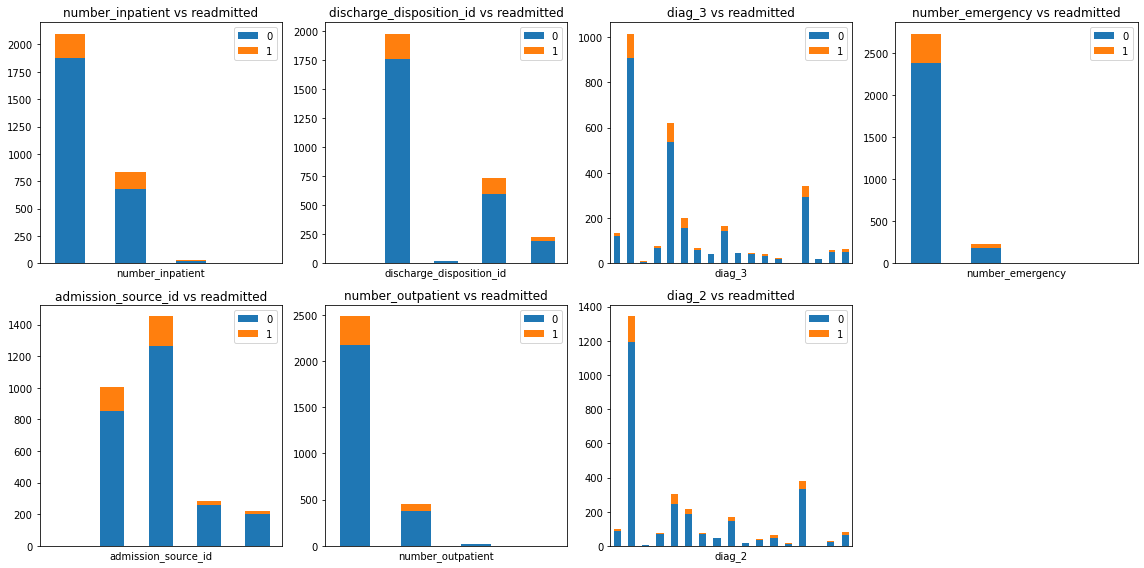

In [57]:
plt.figure(figsize=(16,8))
ax1,ax2,ax3,ax4,ax5,ax6,ax7= [plt.subplot(2,4,i+1) for i in range(7)]
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7]
sig_cols = list(sig_cat_out['Features'])

for axis,col in zip(axes,sig_cols):
    obs = pd.crosstab(df_cat_out[col],y_out.astype(int))
    obs.reset_index().plot(x=col,kind='bar',stacked=True,title='{} vs readmitted'.format(col),ax=axis)
    axis.legend(bbox_to_anchor=[1,1])
    axis.set_xticks([])
plt.tight_layout()
plt.show()

#### One Hot Encoding

In [54]:
df_cat_out_dummy = pd.get_dummies(df_cat_out[sig_cat_out.Features],drop_first=True)

# Multi Classification

## Statistical test for numerical variables:

#### Shapiro_test

In [82]:
#Normality test(Shapiro):

#Ho : skew = 0 (Data is normal)
#Ha : skew = 0 (Data is not normal)

In [55]:
df_shapiro_non_mul = pd.DataFrame(index=df_num_non_mul.columns,columns=['W-stat0','pval0','W-stat1','pval1','W-stat2','pval2','Lev_stat','Lev_pval'])
for i in df_num_non_mul.columns:
    group_0 = df_num_non_mul[i][y_non_multi == 0]
    group_1 = df_num_non_mul[i][y_non_multi == 1]
    group_2 = df_num_non_mul[i][y_non_multi == 2]
    w0,pval0 = stats.shapiro(group_0)
    w1,pval1 = stats.shapiro(group_1)
    w2,pval2 = stats.shapiro(group_2)
    stat_lev, pval_lev = stats.levene(group_0,group_1,group_2)
    df_shapiro_non_mul.loc[i] = [w0,pval0,w1,pval1,w2,pval2,stat_lev,pval_lev]

df_shapiro_out_mul = pd.DataFrame(index=df_num_out_mul.columns,columns=['W-stat0','pval0','W-stat1','pval1','W-stat2','pval2','Lev_stat','Lev_pval'])
for i in df_num_out_mul.columns:
    group_0 = df_num_out_mul[i][y_out_multi == 0]
    group_1 = df_num_out_mul[i][y_out_multi == 1]
    group_2 = df_num_out_mul[i][y_out_multi == 2]
    w0,pval0 = stats.shapiro(group_0)
    w1,pval1 = stats.shapiro(group_1)
    w2,pval2 = stats.shapiro(group_2)
    stat_lev, pval_lev = stats.levene(group_0,group_1,group_2)
    df_shapiro_out_mul.loc[i] = [w0,pval0,w1,pval1,w2,pval2,stat_lev,pval_lev]

In [56]:
df_shapiro_non_mul

,W-stat0,pval0,W-stat1,pval1,W-stat2,pval2,Lev_stat,Lev_pval
time_in_hospital,0.872845,0.0,0.891363,0.0,0.906584,0.0,22.133536,0.0
num_lab_procedures,0.983333,0.0,0.981518,0.0,0.982411,0.0,6.979088,0.000932
num_procedures,0.777528,0.0,0.748282,0.0,0.763849,0.0,26.635207,0.0
num_medications,0.974463,0.0,0.980177,0.0,0.982883,0.0,13.310884,0.000002
number_diagnoses,0.836699,0.0,0.775582,0.0,0.769901,0.0,562.972517,0.0


In [83]:
df_shapiro_out_mul

,W-stat0,pval0,W-stat1,pval1,W-stat2,pval2,Lev_stat,Lev_pval
time_in_hospital,0.96846,0.0,0.967867,0.0,0.966513,0.0,0.898554,0.407269
num_lab_procedures,0.989042,0.0,0.996334,0.042525,0.991242,0.021075,2.254411,0.105115
num_procedures,0.860872,0.0,0.894113,0.0,0.898663,0.0,2.827839,0.0593


**From the Shapiro test**

- We fail to accept the groups of all of the features are normally distributed

**From the Levene test**

- For non outltiers dataset, the groups have different variance
- For outliers dataset, all the groups have same variance

Since the assumption of the anova-test is violated, we have to proceed with non parametric tests such as **Kruskal Wallis test** to understand the significance of the variables

## Kruskal Wallis test

- Ho : All the samples have the same median
- Ha : Atleast one of the samples have different median

In [57]:
df_kw_non_mul = pd.DataFrame(index=df_num_non_mul.columns,columns=['hstat','pval'])
for i in df_num_non_mul.columns:
    group_0 = df_num_non_mul[i][y_non_multi == 0]
    group_1 = df_num_non_mul[i][y_non_multi == 1]
    group_2 = df_num_non_mul[i][y_non_multi == 2]
    hstat,pval = stats.kruskal(group_0,group_1,group_2)
    df_kw_non_mul.loc[i,'hstat'] = hstat
    df_kw_non_mul.loc[i,'pval'] = pval
    
df_kw_out_mul = pd.DataFrame(index=df_num_out_mul.columns,columns=['hstat','pval'])
for i in df_num_out_mul.columns:
    group_0 = df_num_out_mul[i][y_out_multi == 0]
    group_1 = df_num_out_mul[i][y_out_multi == 1]
    group_2 = df_num_out_mul[i][y_out_multi == 2]
    hstat,pval = stats.kruskal(group_0,group_1,group_2)
    df_kw_out_mul.loc[i,'hstat'] = hstat
    df_kw_out_mul.loc[i,'pval'] = pval

In [58]:
df_kw_non_mul

,hstat,pval
time_in_hospital,511.73999,0.0
num_lab_procedures,259.1454,0.0
num_procedures,151.467336,0.0
num_medications,737.117175,0.0
number_diagnoses,1354.198857,0.0


In [59]:
df_kw_out_mul

,hstat,pval
time_in_hospital,46.804548,0.0
num_lab_procedures,9.833367,0.007323
num_procedures,46.51083,0.0
num_medications,33.424721,0.0
number_diagnoses,71.811086,0.0


**From the Kruskal Wallis H test**

- We reject the null hypothesis and all the features are statistically significant

## Categorical variables

### Non outlier dataset

In [47]:
#Hypothesis Framing

# Ho : The variables are independent
# Ha : The variables are dependent

Hypothesis = {'Ho':'There is no relation between independent and readmitted',
              'Ha':'There is relation between independent and readmitted'}

In [60]:
col_obj_non_mul = list(df_cat_non_mul.columns)
df_Chi2_contingency_non_mul = pd.DataFrame({'Features':col_obj_non_mul})
P_value = []
dof = []
for i in col_obj_non_mul:
    obs = pd.crosstab(df_cat_non_mul[i],y_non_multi)
    chi_sq,p_val,ddof,exp = stats.chi2_contingency(obs,correction=True)
    P_value.append(p_val)
    dof.append(ddof)
    
df_Chi2_contingency_non_mul['P_val'] = P_value

In [61]:
insig_cat_non_mul = df_Chi2_contingency_non_mul[df_Chi2_contingency_non_mul['P_val'] > 0.05].sort_values(by='P_val',ascending=True)
sig_cat_non_mul = df_Chi2_contingency_non_mul[df_Chi2_contingency_non_mul['P_val'] <= 0.05].sort_values(by='P_val',ascending=True)
print(len(df_Chi2_contingency_non_mul),len(sig_cat_non_mul))

39 24


In [62]:
sig_cat_non_mul

,Features,P_val
7,number_emergency,0.000000e+00
8,number_inpatient,0.000000e+00
6,number_outpatient,9.099730e-254
4,discharge_disposition_id,1.696744e-240
5,admission_source_id,2.399496e-208
9,diag_1,3.826731e-161
31,insulin,1.279077e-120
10,diag_2,3.371733e-117
11,diag_3,8.741440e-112
38,diabetesMed,1.836732e-79


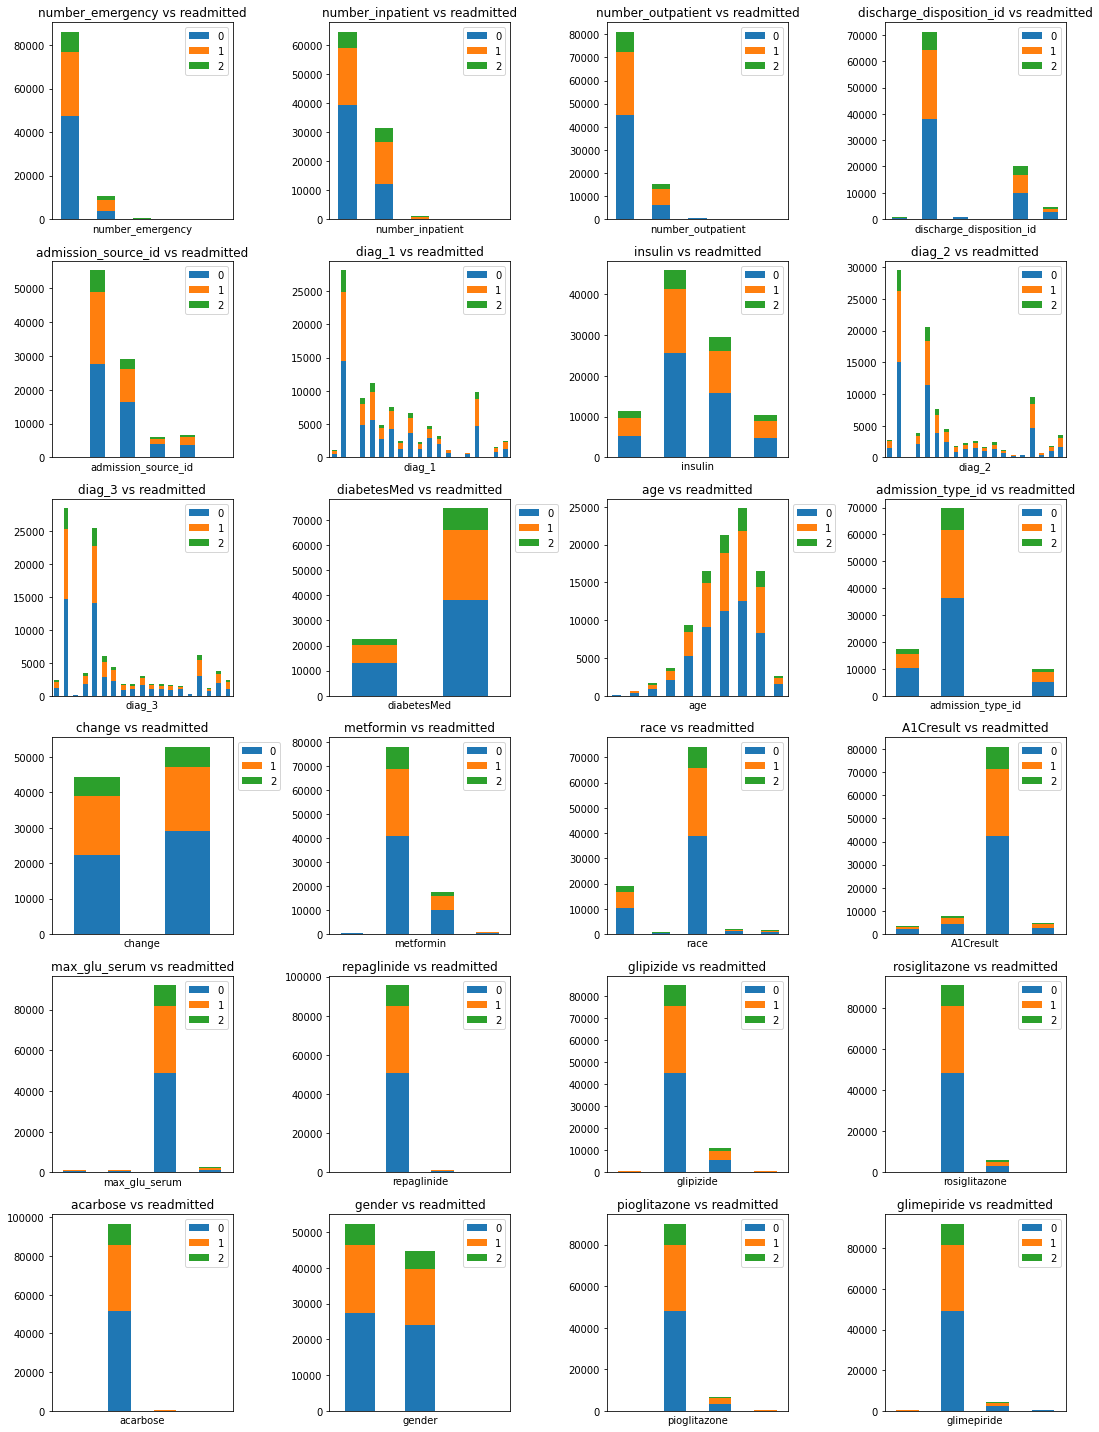

In [71]:
plt.figure(figsize=(15,20))
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21,ax22,ax23,ax24= [plt.subplot(6,4,i+1) for i in range(24)]
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21,ax22,ax23,ax24]
sig_cols = list(sig_cat_non_mul['Features'])

for axis,col in zip(axes,sig_cols):
    obs = pd.crosstab(df_cat_non[col],y_non_multi.astype(int))
    obs.reset_index().plot(x=col,kind='bar',stacked=True,title='{} vs readmitted'.format(col),ax=axis)
    axis.legend(bbox_to_anchor=[1,1])
    axis.set_xticks([])
plt.tight_layout()
plt.show()

> **One Hot Encoding**

In [63]:
df_cat_non_mul_dummy = pd.get_dummies(df_cat_non_mul[sig_cat_non_mul.Features],drop_first=True)

## Outlier dataset

In [53]:
#Hypothesis Framing

# Ho : The variables are independent
# Ha : The variables are dependent

Hypothesis = {'Ho':'There is no relation between independent and readmitted',
              'Ha':'There is relation between independent and readmitted'}

In [64]:
col_obj_out_mul = list(df_cat_out_mul.columns)
df_Chi2_contingency_out_mul = pd.DataFrame({'Features':col_obj_out_mul})
P_value = []
dof = []
for i in col_obj_out_mul:
    obs = pd.crosstab(df_cat_out_mul[i],y_out_multi)
    chi_sq,p_val,ddof,exp = stats.chi2_contingency(obs,correction=True)
    P_value.append(p_val)
    dof.append(ddof)
    
df_Chi2_contingency_out_mul['P_val'] = P_value

In [65]:
insig_cat_out_mul = df_Chi2_contingency_out_mul[df_Chi2_contingency_out_mul['P_val'] > 0.05].sort_values(by='P_val',ascending=True)
sig_cat_out_mul = df_Chi2_contingency_out_mul[df_Chi2_contingency_out_mul['P_val'] <= 0.05].sort_values(by='P_val',ascending=True)
print(len(df_Chi2_contingency_out_mul),len(sig_cat_out_mul))

39 12


In [66]:
sig_cat_out_mul

,Features,P_val
8,number_inpatient,1.863971e-34
5,admission_source_id,2.203585e-22
6,number_outpatient,2.512507e-18
9,diag_1,1.575366e-16
7,number_emergency,8.455661e-13
4,discharge_disposition_id,7.640483e-12
3,admission_type_id,5.135696e-07
10,diag_2,2.117737e-05
1,gender,8.456080e-05
11,diag_3,4.219883e-04


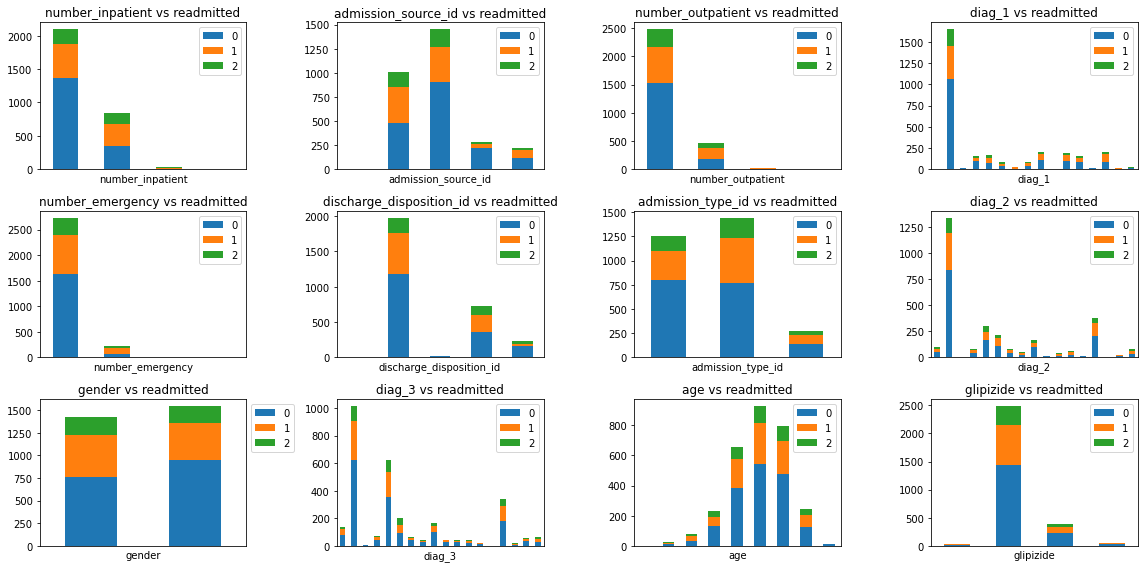

In [78]:
plt.figure(figsize=(16,8))
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12= [plt.subplot(3,4,i+1) for i in range(12)]
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]
sig_cols = list(sig_cat_out_mul['Features'])

for axis,col in zip(axes,sig_cols):
    obs = pd.crosstab(df_cat_out[col],y_out_multi.astype(int))
    obs.reset_index().plot(x=col,kind='bar',stacked=True,title='{} vs readmitted'.format(col),ax=axis)
    axis.legend(bbox_to_anchor=[1,1])
    axis.set_xticks([])
plt.tight_layout()
plt.show()

In [67]:
df_cat_out_mul_dummy = pd.get_dummies(df_cat_out_mul[sig_cat_out_mul.Features],drop_first=True)

# Logistic Regression Assumptions

**The logistic regression method assumes that:**

- The outcome is a binary or dichotomous variable like yes vs no, positive vs negative, 1 vs 0
- There is a linear relationship between the logit of the outcome and each predictor variables. Recall that the logit function is logit(p) = log(p/(1-p)), where p is the probabilities of the outcome.
- There is no influential values (extreme values or outliers) in the continuous predictors
- There is no high intercorrelations (i.e. multicollinearity) among the predictors

## Data Transformation

To account for skewness in some of the numerical variables, we will use **Power Transformer** for tranformation and standardization

## Class imbalance 

**To account for class imbalance, we will use different sampling techniques on the training data from the list mentioned below but not limited to**

- Oversampling 
- Under-sampling 
- SMOTE 
- Near-Miss 

# Binary Classification

> **Non Outliers dataset**

In [133]:
df_non_final = pd.concat(objs=[df_num_non,df_cat_non_dummy],axis=1)

In [43]:
df_non_final.to_csv('df_non_final.csv')

In [147]:
## Splitting the dataset
xtrain_test_non, xval_non, ytrain_test_non, yval_non = train_test_split(df_non_final,y_non,train_size=0.95,random_state=7,stratify=y)
xtrain_non, xtest_non, ytrain_non, ytest_non = train_test_split(xtrain_test_non,ytrain_test_non,train_size=0.8,random_state=7,stratify=y)

## Power Transformation and standardization on numerical features
num_non_cols = df_num_non.columns
pt_non = PowerTransformer()
xtrain_non[num_non_cols] = pt_non.fit_transform(xtrain_non[num_non_cols])
xtest_non[num_non_cols] = pt_non.transform(xtest_non[num_non_cols])
xval_non[num_non_cols] = pt_non.transform(xval_non[num_non_cols])

#Feature Selection by Recursive Backward Elimination
cols = list(xtrain_non.columns)
print(len(cols))
pmax = 1
while (len(cols)>0):
    p= []
    X_non = xtrain_non[cols]
    Xc_non = sm.add_constant(X_non)
    model_non = sm.OLS(ytrain_non,Xc_non).fit()
    p = pd.Series(model_non.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
significant_features_non_final = cols
print(len(significant_features_non_final))

## Sampling techniques for imbalance
smt_non = SMOTE(random_state=7)
xtrain_non_smt, ytrain_non_smt = smt_non.fit_resample(xtrain_non[significant_features_non_final],ytrain_non)

113
46


In [148]:
## Model built and checked for any influential outliers and performance
Xc_non = sm.add_constant(xtrain_non_smt)
model_non_lr = sm.OLS(ytrain_non_smt,Xc_non).fit()
influence_non = model_non_lr.get_influence()
cooks_non = influence_non.cooks_distance
print('Max cooks distance :',pd.Series(cooks_non[0]).max())
ytest_perd_non_lr = [0 if i < 0.5 else 1 for i in model_non_lr.predict(sm.add_constant(xtest_non[significant_features_non_final]))]

dt_non = DecisionTreeClassifier(random_state=10)
dt_non.fit(xtrain_non[significant_features_non_final], ytrain_non)
y_test_pred_non_dt = dt_non.predict(xtest_non[significant_features_non_final])

Max cooks distance : 0.008401213886580657


In [149]:
print('Logistic Regression Classification report for non - Outliers :\n\n',classification_report(ytest_non, ytest_perd_non_lr))
print('\n\nDecision Tree Classification report for non - Outliers :\n\n',classification_report(ytest_non, y_test_pred_non_dt))

Logistic Regression Classification report for non - Outliers :

               precision    recall  f1-score   support

           0       0.90      0.65      0.76     16375
           1       0.14      0.45      0.21      2084

    accuracy                           0.63     18459
   macro avg       0.52      0.55      0.49     18459
weighted avg       0.82      0.63      0.70     18459



Decision Tree Classification report for non - Outliers :

               precision    recall  f1-score   support

           0       0.89      0.87      0.88     16375
           1       0.15      0.17      0.16      2084

    accuracy                           0.79     18459
   macro avg       0.52      0.52      0.52     18459
weighted avg       0.81      0.79      0.80     18459



> **Outliers dataset**

In [155]:
df_out_final = pd.concat(objs=[df_num_out,df_cat_out_dummy],axis=1)

In [47]:
df_out_final.to_csv('df_out_final.csv')

In [175]:
## Splitting the dataset
xtrain_test_out, xval_out, ytrain_test_out, yval_out = train_test_split(df_out_final,y_out,train_size=0.95,random_state=7,stratify=y_out)
xtrain_out, xtest_out, ytrain_out, ytest_out = train_test_split(xtrain_test_out,ytrain_test_out,train_size=0.8,random_state=7,stratify=ytrain_test_out)

## Power Transformation and standardization on numerical features
num_out_cols = df_num_out.columns
pt_out = PowerTransformer()
xtrain_out[num_out_cols] = pt_out.fit_transform(xtrain_out[num_out_cols])
xtest_out[num_out_cols] = pt_out.transform(xtest_out[num_out_cols])
xval_out[num_out_cols] = pt_out.transform(xval_out[num_out_cols])

#Feature Selection by Recursive Backward Elimination
cols = list(xtrain_out.columns)
print(len(cols))
pmax = 1
while (len(cols)>0):
    p= []
    X_out = xtrain_out[cols]
    Xc_out = sm.add_constant(X_out)
    model_out = sm.OLS(ytrain_out,Xc_out).fit()
    p = pd.Series(model_out.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
significant_features_out_final = cols
print(len(significant_features_out_final))

## Sampling techniques for imbalance
smt_out = SMOTE(random_state=7)
xtrain_out_smt, ytrain_out_smt = smt_out.fit_resample(xtrain_out[significant_features_out_final],ytrain_out)

56
8


In [176]:
Xc_out = sm.add_constant(xtrain_out_smt)
model_out_lr = sm.OLS(ytrain_out_smt,Xc_out).fit()
influence_out = model_out_lr.get_influence()
cooks_out = influence_out.cooks_distance
print('Max cooks distance :',pd.Series(cooks_out[0]).max())
ytest_perd_out_lr = [0 if i < 0.5 else 1 for i in model_out_lr.predict(sm.add_constant(xtest_out[significant_features_out_final]))]
dt_out = DecisionTreeClassifier(random_state=10)
dt_out.fit(xtrain_out, ytrain_out)
y_test_pred_out_dt = dt_out.predict(xtest_out)

Max cooks distance : 311.1749727600866


In [177]:
print('\nLogistic Regression Classification report for Outliers :\n\n',classification_report(ytest_out, ytest_perd_out_lr))
print('\n\nDecision Tree Classification report for Outliers :\n\n',classification_report(ytest_out, y_test_pred_out_dt))


Logistic Regression Classification report for Outliers :

               precision    recall  f1-score   support

           0       0.87      0.97      0.92       490
           1       0.13      0.03      0.04        74

    accuracy                           0.85       564
   macro avg       0.50      0.50      0.48       564
weighted avg       0.77      0.85      0.80       564



Decision Tree Classification report for Outliers :

               precision    recall  f1-score   support

           0       0.88      0.87      0.87       490
           1       0.18      0.19      0.18        74

    accuracy                           0.78       564
   macro avg       0.53      0.53      0.53       564
weighted avg       0.79      0.78      0.78       564



**Inference:**

- The dependent variable is **binary**
- There is a linear relationship between the logit of the outcome and each predictor variables. Recall that the logit function is logit(p) = log(p/(1-p)), where p is the probabilities of the outcome.
- There are no influential values in the continuous predictors for non outliers dataset - **Confirmed with Cook's distance**
- There is no  multicollinearity among the predictors - **Confirmed with VIF factor**

# Multi Classification

> **Non Outliers dataset**

In [98]:
df_non_mul_final = pd.concat(objs=[df_num_non_mul,df_cat_non_mul_dummy ],axis=1)

In [43]:
df_non_final.to_csv('df_non_final.csv')

In [123]:
## Splitting the dataset
xtrain_test_non, xval_non, ytrain_test_non, yval_non = train_test_split(df_non_mul_final,y_non_multi,train_size=0.8,random_state=10)
xtrain_non, xtest_non, ytrain_non, ytest_non = train_test_split(xtrain_test_non,ytrain_test_non,train_size=0.8,random_state=10)

## Power Transformation and standardization on numerical features
num_non_cols = df_num_non.columns
pt_non = PowerTransformer()
xtrain_non[num_non_cols] = pt_non.fit_transform(xtrain_non[num_non_cols])
xtest_non[num_non_cols] = pt_non.transform(xtest_non[num_non_cols])
xval_non[num_non_cols] = pt_non.transform(xval_non[num_non_cols])

## Sampling techniques for imbalance
smt_non = SMOTE(random_state=7)
xtrain_non_smt, ytrain_non_smt = smt_non.fit_resample(xtrain_non,ytrain_non)

In [124]:
## Model built and checked for any influential outliers and performance
dt_non = DecisionTreeClassifier(random_state=10)
dt_non.fit(xtrain_non, ytrain_non)
y_test_pred_non_dt = dt_non.predict(xtest_non)

In [134]:
print('Decision Tree Classification report for non - Outliers :\n\n',classification_report(ytest_non, y_test_pred_non_dt))

Decision Tree Classification report for non - Outliers :

               precision    recall  f1-score   support

           0       0.59      0.57      0.58      8341
           1       0.39      0.41      0.40      5380
           2       0.15      0.15      0.15      1823

    accuracy                           0.46     15544
   macro avg       0.38      0.38      0.38     15544
weighted avg       0.47      0.46      0.47     15544



> **Outliers dataset**

In [113]:
df_out_final_mul = pd.concat(objs=[df_num_out_mul,df_cat_out_mul_dummy],axis=1)

In [114]:
df_out_final_mul.to_csv('df_out_final_mul.csv')

In [131]:
## Splitting the dataset
xtrain_test_out, xval_out, ytrain_test_out, yval_out = train_test_split(df_out_final_mul,y_out_multi,train_size=0.8,random_state=10)
xtrain_out, xtest_out, ytrain_out, ytest_out = train_test_split(xtrain_test_out,ytrain_test_out,train_size=0.8,random_state=10)

## Sampling techniques for imbalance
smt_out = SMOTE(random_state=7)
xtrain_out_smt, ytrain_out_smt = smt_out.fit_resample(xtrain_out,ytrain_out)

In [132]:
Xc_out = sm.add_constant(xtrain_out_smt)
model_out_lr = sm.OLS(ytrain_out_smt,Xc_out).fit()
ytest_perd_out_lr = [0 if i < 0.5 else 1 for i in model_out_lr.predict(sm.add_constant(xtest_out))]

dt_out = DecisionTreeClassifier(random_state=10)
dt_out.fit(xtrain_out, ytrain_out)
y_test_pred_out_dt = dt_out.predict(xtest_out)

In [135]:
print('Decision Tree Classification report for Outliers :\n\n',classification_report(ytest_out, y_test_pred_out_dt))

Decision Tree Classification report for Outliers :

               precision    recall  f1-score   support

           0       0.65      0.62      0.64       289
           1       0.33      0.38      0.35       125
           2       0.20      0.20      0.20        61

    accuracy                           0.50       475
   macro avg       0.40      0.40      0.40       475
weighted avg       0.51      0.50      0.51       475



**For both the datasets:**

- The dependent variable is **binary**
- There is a linear relationship between the logit of the outcome and each predictor variables. Recall that the logit function is logit(p) = log(p/(1-p)), where p is the probabilities of the outcome.
- There are no influential values in the continuous predictors - **Confirmed with Cook's distance**
- There is no  multicollinearity among the predictors - **Confirmed with VIF factor**

# Model Building

|Non Outliers|

In [2]:
df_non_final = pd.read_csv('df_non_final.csv').iloc[:,1:]

In [3]:
df_non_final.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,number_inpatient_1-5,number_inpatient_5-10,number_inpatient_10-20,number_inpatient_>20,discharge_disposition_id_Home,...,admission_type_id_Unavailable,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,repaglinide_No,repaglinide_Steady,repaglinide_Up,glipizide_No,glipizide_Steady,glipizide_Up
0,1,41,0,1,1,0,0,0,0,0,...,1,0,1,0,1,0,0,1,0,0
1,3,59,0,18,9,0,0,0,0,1,...,0,0,1,0,1,0,0,1,0,0
2,2,11,5,13,6,1,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
3,2,44,1,16,7,0,0,0,0,1,...,0,0,1,0,1,0,0,1,0,0
4,1,51,0,8,5,0,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0


## Logistic Regression

In [132]:
def sel_train_pred_report(xtrain_pt,ytrain,xtest_pt,ytest,xval_pt,yval,sampling):
    #Feature Selection by Recursive Backward Elimination
    cols = list(xtrain_pt.columns)
    org_len = len(cols)
    pmax = 1
    while (len(cols)>0):
        p= []
        X_lr = xtrain_pt[cols]
        Xc_lr = sm.add_constant(X_lr,has_constant='add')
        model_out = sm.OLS(ytrain,Xc_lr).fit()
        p = pd.Series(model_out.pvalues.values[1:],index = cols)      
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax>0.05):
            cols.remove(feature_with_p_max)
        else:
            break
    significant_features_final = cols
    print(org_len,'----->',len(significant_features_final))
    #print(significant_features_final)
    
    model = LogisticRegression(random_state=7)
    model.fit(xtrain_pt[significant_features_final],ytrain)
    
    ypred_train, yprob_train = model.predict(xtrain_pt[significant_features_final]), model.predict_proba(xtrain_pt[significant_features_final])[:,1]
    ypred_test, yprob_test = model.predict(xtest_pt[significant_features_final]), model.predict_proba(xtest_pt[significant_features_final])[:,1]
    ypred_val, yprob_val = model.predict(xval_pt[significant_features_final]), model.predict_proba(xval_pt[significant_features_final])[:,1]
    
    temp_score = pd.DataFrame(columns=['Precision_0','Precision_1','Recall_0','Recall_1','F_score_0',\
                                       'F_score_1','Accuracy','roc_auc'])
    
    (pr0,pr1), (rc0,rc1), (f0,f1), (sup0,sup1) = metrics.precision_recall_fscore_support(ytrain,ypred_train,labels=[0,1])
    acc, roc_auc = accuracy_score(ytrain,ypred_train), roc_auc_score(ytrain,yprob_train)
    temp_score.loc[str(sampling)+'_Train'] = [pr0,pr1,rc0,rc1,f0,f1,acc,roc_auc]
    
    (pr0,pr1), (rc0,rc1), (f0,f1), (sup0,sup1) = metrics.precision_recall_fscore_support(ytest,ypred_test,labels=[0,1])
    acc, roc_auc = accuracy_score(ytest,ypred_test), roc_auc_score(ytest,yprob_test)
    temp_score.loc[str(sampling)+'_Test'] = [pr0,pr1,rc0,rc1,f0,f1,acc,roc_auc]
    
    (pr0,pr1), (rc0,rc1), (f0,f1), (sup0,sup1) = metrics.precision_recall_fscore_support(yval,ypred_val,labels=[0,1])
    acc, roc_auc = accuracy_score(yval,ypred_val), roc_auc_score(yval,yprob_val)
    temp_score.loc[str(sampling)+'_Val'] = [pr0,pr1,rc0,rc1,f0,f1,acc,roc_auc]
    
    return temp_score

def lr_model(x,y,k=5):
    xtrain_test,xval,ytrain_test,yval = train_test_split(x,y,train_size=0.95,shuffle=True,random_state=7,stratify=y)
    xtrain,xtest,ytrain,ytest = train_test_split(xtrain_test,ytrain_test,train_size=0.8,shuffle=True,random_state=7,stratify=ytrain_test)
    pt = PowerTransformer()
    xtrain_pt = pd.DataFrame(pt.fit_transform(xtrain),index=xtrain.index,columns=xtrain.columns)
    xtest_pt = pd.DataFrame(pt.transform(xtest),index=xtest.index,columns=xtest.columns)
    xval_pt = pd.DataFrame(pt.transform(xval),index=xval.index,columns=xval.columns)
    
    df_score = pd.DataFrame(columns=['Precision_0','Precision_1','Recall_0','Recall_1','F_score_0',\
                                     'F_score_1','Accuracy','roc_auc'])
    
    print('Without sampling techniques')
    score = sel_train_pred_report(xtrain_pt,ytrain,xtest_pt,ytest,xval_pt,yval,sampling=None)
    df_score = pd.concat(objs=[df_score,score])

    rus = RandomUnderSampler(random_state=7,replacement=True)
    xrus, yrus = rus.fit_resample(xtrain_pt,ytrain)
    print('RandomUnderSampling')
    score = sel_train_pred_report(xrus,yrus,xtest_pt,ytest,xval_pt,yval,sampling='RUS')
    df_score = pd.concat(objs=[df_score,score])
    
    nm = NearMiss(n_neighbors=k)
    xnm, ynm = nm.fit_resample(xtrain_pt,ytrain)
    print('Near miss Undersampling')
    score = sel_train_pred_report(xnm,ynm,xtest_pt,ytest,xval_pt,yval,sampling='NearMiss')
    df_score = pd.concat(objs=[df_score,score])

    ros = RandomOverSampler(random_state=7)
    xros, yros = ros.fit_resample(xtrain_pt,ytrain)
    print('RandomOverSampling')
    score = sel_train_pred_report(xros,yros,xtest_pt,ytest,xval_pt,yval,sampling='ROS')
    df_score = pd.concat(objs=[df_score,score])

    smt = SMOTE(random_state=7,k_neighbors=k)
    xsmt, ysmt = smt.fit_resample(xtrain_pt,ytrain)
    print('SMOTE-Oversampling')
    score = sel_train_pred_report(xsmt, ysmt,xtest_pt,ytest,xval_pt,yval,sampling='SMOTE')
    df_score = pd.concat(objs=[df_score,score])
    
    bsmt = BorderlineSMOTE(random_state=7,k_neighbors=k)
    xbsmt, ybsmt = bsmt.fit_resample(xtrain_pt,ytrain)
    print('Borderline-SMOTE')
    score = sel_train_pred_report(xbsmt, ybsmt,xtest_pt,ytest,xval_pt,yval,sampling='BL-SMOTE')
    df_score = pd.concat(objs=[df_score,score])
    
    asn = ADASYN(random_state=7,n_neighbors=k)
    xasn, yasn = asn.fit_resample(xtrain_pt,ytrain)
    print('ADASYN-Oversampling')
    score = sel_train_pred_report(xasn, yasn,xtest_pt,ytest,xval_pt,yval,sampling='ADASYN')
    df_score = pd.concat(objs=[df_score,score])

    print('Completed')
    
    a,b = list(df_score.reset_index().iloc[:,0].str.split('_',expand=True).iloc[:,0]), list(df_score.reset_index().iloc[:,0].str.split('_',expand=True).iloc[:,1])
    df_score.insert(0,'Sampling_Type',a)
    df_score.insert(1,'Set_Type',b)
    
    plt.figure(figsize=(16,3))
    X_axis = np.arange(df_score.Sampling_Type.nunique())
    plt.bar(X_axis - 0.2, df_score.Recall_1[df_score.Set_Type=='Test'], 0.4, label = 'Test')
    plt.bar(X_axis + 0.2, df_score.Recall_1[df_score.Set_Type=='Val'], 0.4, label = 'Val')
    plt.xticks(X_axis,list(df_score.Sampling_Type.unique()))
    plt.yticks(np.arange(0,1.01,0.1))
    plt.xlabel('Sampling Technique')
    plt.ylabel('Recall for not admitted')
    plt.show()
    
    plt.figure(figsize=(16,3))
    X_axis = np.arange(df_score.Sampling_Type.nunique())
    plt.bar(X_axis - 0.2, df_score.Precision_1[df_score.Set_Type=='Test'], 0.4, label = 'Test')
    plt.bar(X_axis + 0.2, df_score.Precision_1[df_score.Set_Type=='Val'], 0.4, label = 'Val')
    plt.xticks(X_axis,list(df_score.Sampling_Type.unique()))
    plt.yticks(np.arange(0,1.01,0.1))
    plt.xlabel('Sampling Technique')
    plt.ylabel('Precision for not admitted')
    plt.show()
    
    return df_score

### Both numerical and categorical variables

In [ ]:
lr_model_score_non_all = lr_model(df_non_final,y_non)
lr_model_score_non_all

In [121]:
lr_model_score_non_all.to_csv('lr_model_score_non_all.csv')

### Only categorical variables

Without sampling techniques
109 -----> 51
RandomUnderSampling
109 -----> 36
Near miss Undersampling
109 -----> 79
RandomOverSampling
109 -----> 77
SMOTE-Oversampling
109 -----> 85
Borderline-SMOTE
109 -----> 82
ADASYN-Oversampling
109 -----> 74
Completed


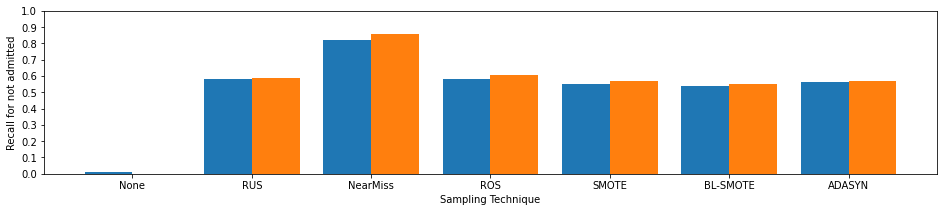

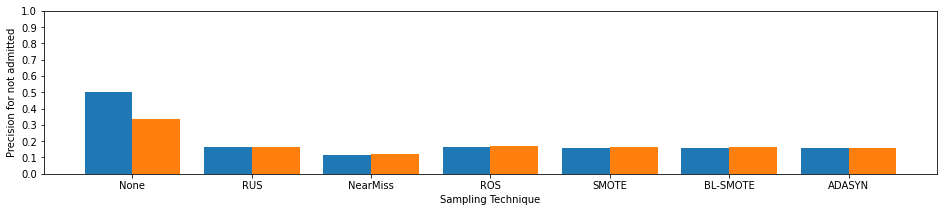

In [126]:
#df_num_non,df_cat_non_dummy
lr_model_score_non_cat = lr_model(df_cat_non_dummy,y_non)
lr_model_score_non_cat.to_csv('lr_model_score_non_cat.csv')

### Only numerical variables

Without sampling techniques
5 -----> 4
RandomUnderSampling
5 -----> 4
Near miss Undersampling
5 -----> 4
RandomOverSampling
5 -----> 4
SMOTE-Oversampling
5 -----> 4
Borderline-SMOTE
5 -----> 5
ADASYN-Oversampling
5 -----> 4
Completed


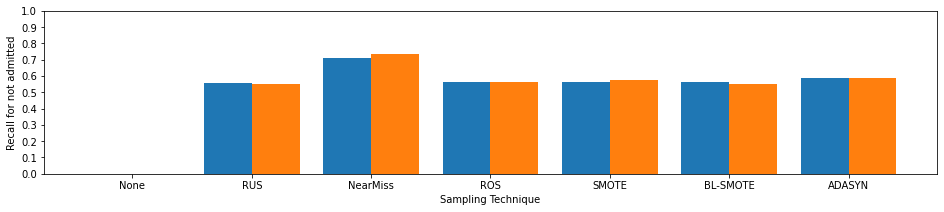

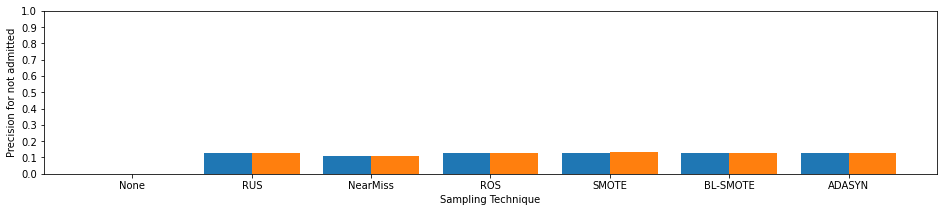

In [399]:
#df_num_non,df_cat_non_dummy
lr_model_score_non_num = lr_model(df_num_non,y_non)
lr_model_score_non_num.to_csv('lr_model_score_non_num.csv')

Estimating Pipeline Pipeline(steps=[('lr', LogisticRegression())])


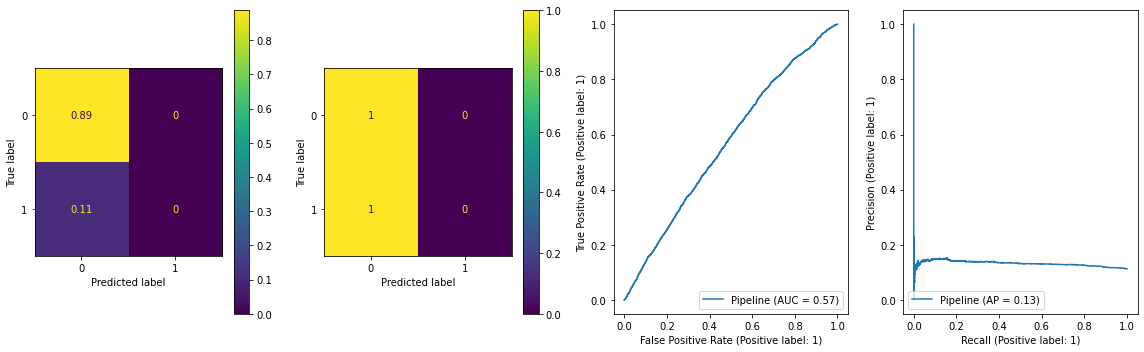

Estimating Pipeline Pipeline(steps=[('undersamp', RandomUnderSampler(random_state=1)),
                ('lr', LogisticRegression())])


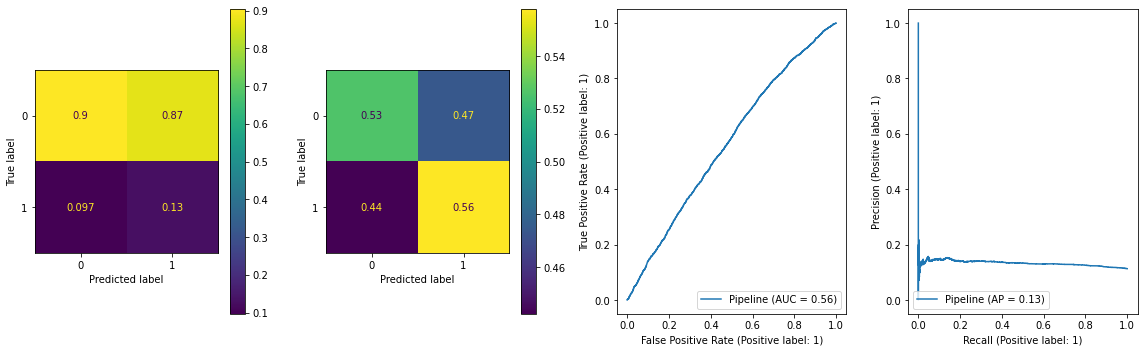

Estimating Pipeline Pipeline(steps=[('nearmiss', NearMiss()), ('lr', LogisticRegression())])


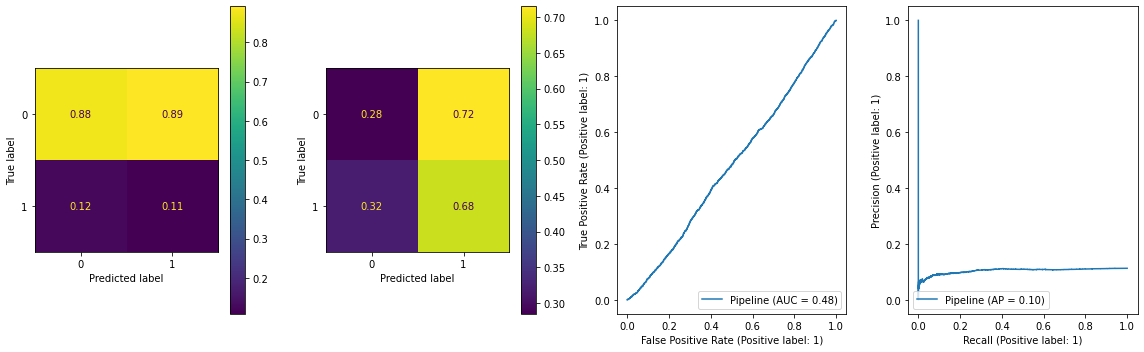

In [402]:
undersamp = RandomUnderSampler(random_state=1)
nm = NearMiss()

lr = LogisticRegression()

# pipeline for each type of sampler
pipeline_0 = Pipeline([('lr', lr)])
pipeline_1 = Pipeline([('undersamp', undersamp), ('lr', lr)])
pipeline_2 = Pipeline([('nearmiss', nm), ('lr', lr)])

# loop to run all pipelines
pipeline_list = [pipeline_0, pipeline_1, pipeline_2]
for num, pipeline in enumerate(pipeline_list):
    print("Estimating Pipeline {}".format(pipeline))
    pipeline.fit(xtrain_pt, ytrain)
    #y_pred = pipeline.predict(xtest_pt)
    #probs = pipeline.predict_proba(xtest_pt)[:,1]
    #print("Confusion Matrix for pipeline {}:".format(num))
    #print(confusion_matrix(ytest, y_pred))
    #cm = confusion_matrix(ytest, y_pred) 
    
    plt.figure(figsize=(16,5))
    ax1, ax2, ax3, ax4 = plt.subplot(1,4,1), plt.subplot(1,4,2), plt.subplot(1,4,3), plt.subplot(1,4,4)
    metrics.plot_confusion_matrix(pipeline, xtest_pt, ytest, labels = [0, 1], normalize='pred', ax=ax1)
    metrics.plot_confusion_matrix(pipeline, xtest_pt, ytest, labels = [0, 1], normalize='true', ax=ax2)

    metrics.plot_roc_curve(pipeline, xtest_pt, ytest, ax=ax3)
    metrics.plot_precision_recall_curve(pipeline, xtest_pt, ytest, ax=ax4)
    plt.tight_layout()
    plt.show()

In [ ]:
print('For Training data \nAccuracy : {}\nROC_AUC_score : {}\n{}'.format(accuracy_score(ynm,ypred_train),roc_auc_score(ynm,yprob_train),classification_report(ynm,ypred_train)))
sns.heatmap(confusion_matrix(ynm,ypred_train),annot=True,fmt='.0f',cmap='Blues')
plt.show()
print('For Testing data \nAccuracy : {}\nROC_AUC_score : {}\n{}'.format(accuracy_score(ytest,ypred_test),roc_auc_score(ytest,yprob_test),classification_report(ytest,ypred_test)))
sns.heatmap(confusion_matrix(ytest,ypred_test),annot=True,fmt='.0f',cmap='Blues')
plt.show()
print('For validation data \nAccuracy : {}\nROC_AUC_score : {}\n{}'.format(accuracy_score(yval,ypred_val),roc_auc_score(yval,yprob_val),classification_report(yval,ypred_val)))
sns.heatmap(confusion_matrix(yval,ypred_val),annot=True,fmt='.0f',cmap='Blues')
plt.show()

# Gaussian Naives Bayes Classifier

In [241]:
from sklearn import metrics

In [64]:
def train_pred_report(xtrain_pt,ytrain,xtest_pt,ytest,xval_pt,yval,sampling):
    
    model = GaussianNB()
    model.fit(xtrain_pt,ytrain)
    
    ypred_train, yprob_train = model.predict(xtrain_pt), model.predict_proba(xtrain_pt)[:,1]
    ypred_test, yprob_test = model.predict(xtest_pt), model.predict_proba(xtest_pt)[:,1]
    ypred_val, yprob_val = model.predict(xval_pt), model.predict_proba(xval_pt)[:,1]
    
    temp_score = pd.DataFrame(columns=['Precision_0','Precision_1','Recall_0','Recall_1','F_score_0',\
                                       'F_score_1','Accuracy','roc_auc'])
    
    (pr0,pr1), (rc0,rc1), (f0,f1), (sup0,sup1) = metrics.precision_recall_fscore_support(ytrain,ypred_train,labels=[0,1])
    acc, roc_auc = accuracy_score(ytrain,ypred_train), roc_auc_score(ytrain,yprob_train)
    temp_score.loc[str(sampling)+'_Train'] = [pr0,pr1,rc0,rc1,f0,f1,acc,roc_auc]
    
    (pr0,pr1), (rc0,rc1), (f0,f1), (sup0,sup1) = metrics.precision_recall_fscore_support(ytest,ypred_test,labels=[0,1])
    acc, roc_auc = accuracy_score(ytest,ypred_test), roc_auc_score(ytest,yprob_test)
    temp_score.loc[str(sampling)+'_Test'] = [pr0,pr1,rc0,rc1,f0,f1,acc,roc_auc]
    
    (pr0,pr1), (rc0,rc1), (f0,f1), (sup0,sup1) = metrics.precision_recall_fscore_support(yval,ypred_val,labels=[0,1])
    acc, roc_auc = accuracy_score(yval,ypred_val), roc_auc_score(yval,yprob_val)
    temp_score.loc[str(sampling)+'_Val'] = [pr0,pr1,rc0,rc1,f0,f1,acc,roc_auc]
    
    return temp_score

def gnb_model(x,y,k=5):
    xtrain_test,xval,ytrain_test,yval = train_test_split(x,y,train_size=0.95,shuffle=True)
    xtrain,xtest,ytrain,ytest = train_test_split(xtrain_test,ytrain_test,train_size=0.8,shuffle=True)
    pt = PowerTransformer()
    xtrain_pt = pd.DataFrame(pt.fit_transform(xtrain),index=xtrain.index,columns=xtrain.columns)
    xtest_pt = pd.DataFrame(pt.transform(xtest),index=xtest.index,columns=xtest.columns)
    xval_pt = pd.DataFrame(pt.transform(xval),index=xval.index,columns=xval.columns)
    
    df_score = pd.DataFrame(columns=['Precision_0','Precision_1','Recall_0','Recall_1','F_score_0',\
                                     'F_score_1','Accuracy','roc_auc'])
    
    print('Without sampling techniques')
    score = train_pred_report(xtrain_pt,ytrain,xtest_pt,ytest,xval_pt,yval,sampling=None)
    df_score = pd.concat(objs=[df_score,score])

    rus = RandomUnderSampler(random_state=7,replacement=True)
    xrus, yrus = rus.fit_resample(xtrain_pt,ytrain)
    print('RandomUnderSampling')
    score = train_pred_report(xrus,yrus,xtest_pt,ytest,xval_pt,yval,sampling='RUS')
    df_score = pd.concat(objs=[df_score,score])
    
    nm = NearMiss(n_neighbors=k)
    xnm, ynm = nm.fit_resample(xtrain_pt,ytrain)
    print('Near miss Undersampling')
    score = train_pred_report(xnm,ynm,xtest_pt,ytest,xval_pt,yval,sampling='NearMiss')
    df_score = pd.concat(objs=[df_score,score])

    ros = RandomOverSampler(random_state=7)
    xros, yros = ros.fit_resample(xtrain_pt,ytrain)
    print('RandomOverSampling')
    score = train_pred_report(xros,yros,xtest_pt,ytest,xval_pt,yval,sampling='ROS')
    df_score = pd.concat(objs=[df_score,score])

    smt = SMOTE(random_state=7,k_neighbors=k)
    xsmt, ysmt = smt.fit_resample(xtrain_pt,ytrain)
    print('SMOTE-Oversampling')
    score = train_pred_report(xsmt, ysmt,xtest_pt,ytest,xval_pt,yval,sampling='SMOTE')
    df_score = pd.concat(objs=[df_score,score])
    
    bsmt = BorderlineSMOTE(random_state=7,k_neighbors=k)
    xbsmt, ybsmt = bsmt.fit_resample(xtrain_pt,ytrain)
    print('Borderline-SMOTE')
    score = train_pred_report(xbsmt, ybsmt,xtest_pt,ytest,xval_pt,yval,sampling='BL-SMOTE')
    df_score = pd.concat(objs=[df_score,score])
    
    asn = ADASYN(random_state=7,n_neighbors=k)
    xasn, yasn = asn.fit_resample(xtrain_pt,ytrain)
    print('ADASYN-Oversampling')
    score = train_pred_report(xasn, yasn,xtest_pt,ytest,xval_pt,yval,sampling='ADASYN')
    df_score = pd.concat(objs=[df_score,score])

    print('Completed')
    
    a,b = list(df_score.reset_index().iloc[:,0].str.split('_',expand=True).iloc[:,0]), list(df_score.reset_index().iloc[:,0].str.split('_',expand=True).iloc[:,1])
    df_score.insert(0,'Sampling_Type',a)
    df_score.insert(1,'Set_Type',b)
    
    plt.figure(figsize=(16,3))
    X_axis = np.arange(df_score.Sampling_Type.nunique())
    plt.bar(X_axis - 0.2, df_score.Recall_1[df_score.Set_Type=='Test'], 0.4, label = 'Test')
    plt.bar(X_axis + 0.2, df_score.Recall_1[df_score.Set_Type=='Val'], 0.4, label = 'Val')
    plt.xticks(X_axis,list(df_score.Sampling_Type.unique()))
    plt.yticks(np.arange(0,1.01,0.1))
    plt.xlabel('Sampling Technique')
    plt.ylabel('Recall for not admitted')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(16,3))
    X_axis = np.arange(df_score.Sampling_Type.nunique())
    plt.bar(X_axis - 0.2, df_score.Precision_1[df_score.Set_Type=='Test'], 0.4, label = 'Test')
    plt.bar(X_axis + 0.2, df_score.Precision_1[df_score.Set_Type=='Val'], 0.4, label = 'Val')
    plt.xticks(X_axis,list(df_score.Sampling_Type.unique()))
    plt.yticks(np.arange(0,1.01,0.1))
    plt.xlabel('Sampling Technique')
    plt.ylabel('Precision for not admitted')
    plt.legend()
    plt.show()
    
    return df_score

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


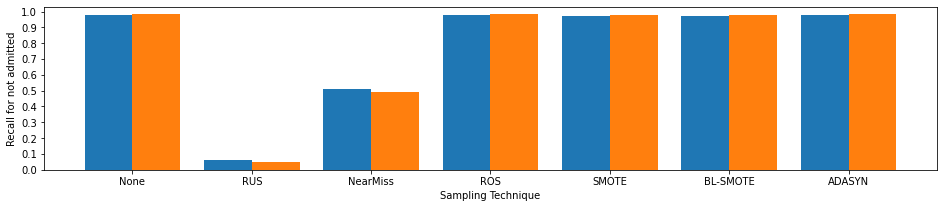

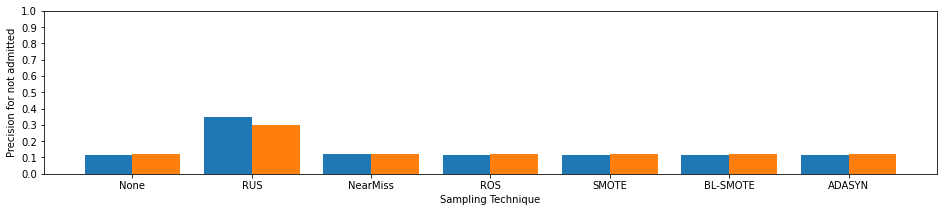

In [136]:
gnb_model_score_non_all = gnb_model(df_non_final,y_non)
gnb_model_score_non_all.to_csv('gnb_model_score_non_all.csv')

### Only categorical variables

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


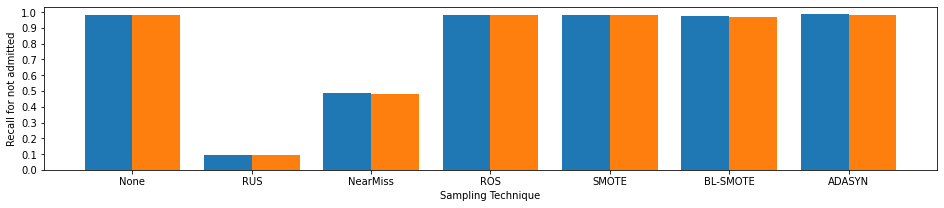

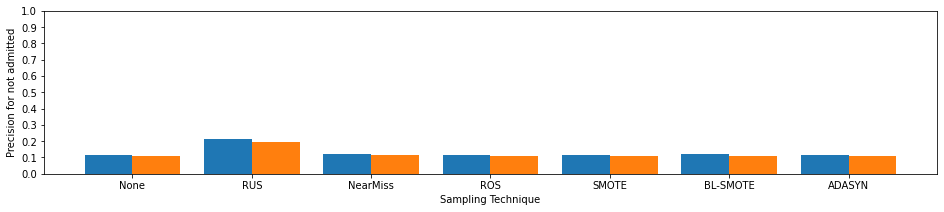

In [137]:
#df_num_non,df_cat_non_dummy
gnb_model_score_non_cat = gnb_model(df_cat_non_dummy,y_non)
gnb_model_score_non_cat.to_csv('gnb_model_score_non_cat.csv')

### Only numerical variables

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


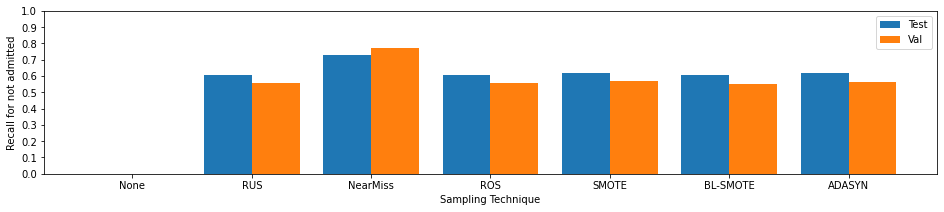

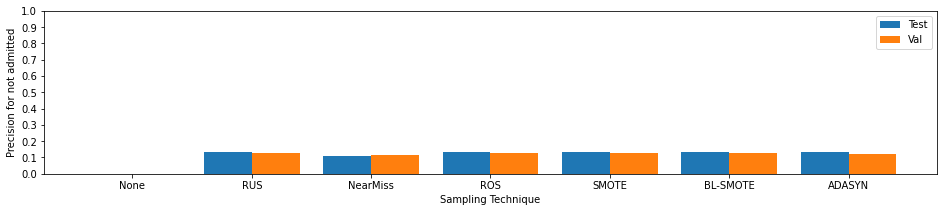

In [404]:
#df_num_non,df_cat_non_dummy
gnb_model_score_non_num = gnb_model(df_num_non,y_non)
gnb_model_score_non_num.to_csv('gnb_model_score_non_num.csv')

Estimating Pipeline Pipeline(steps=[('GaussianNB', GaussianNB())])


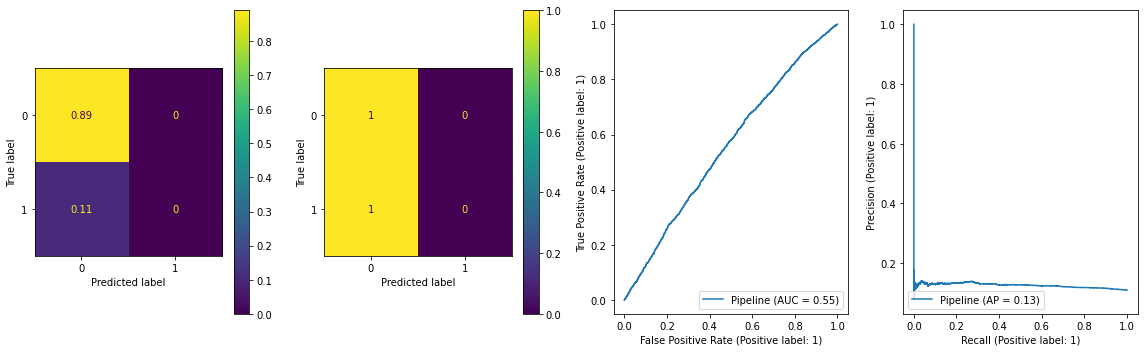

Estimating Pipeline Pipeline(steps=[('undersamp', RandomUnderSampler(random_state=1)),
                ('GaussianNB', GaussianNB())])


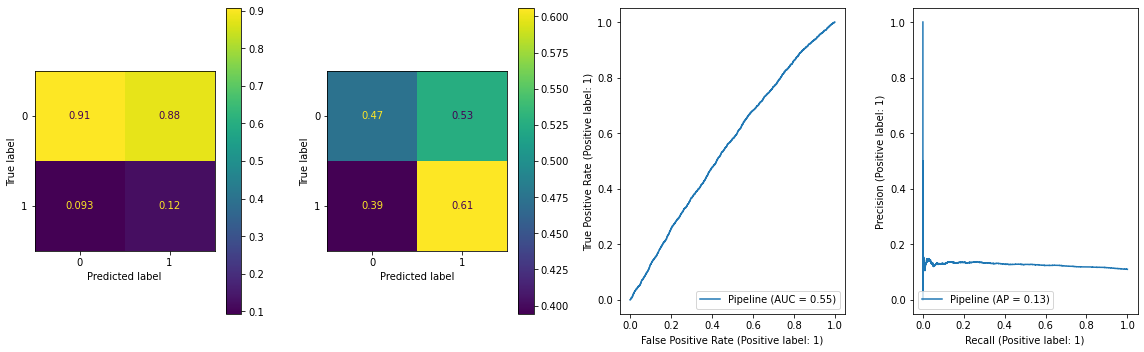

Estimating Pipeline Pipeline(steps=[('nearmiss', NearMiss()), ('GaussianNB', GaussianNB())])


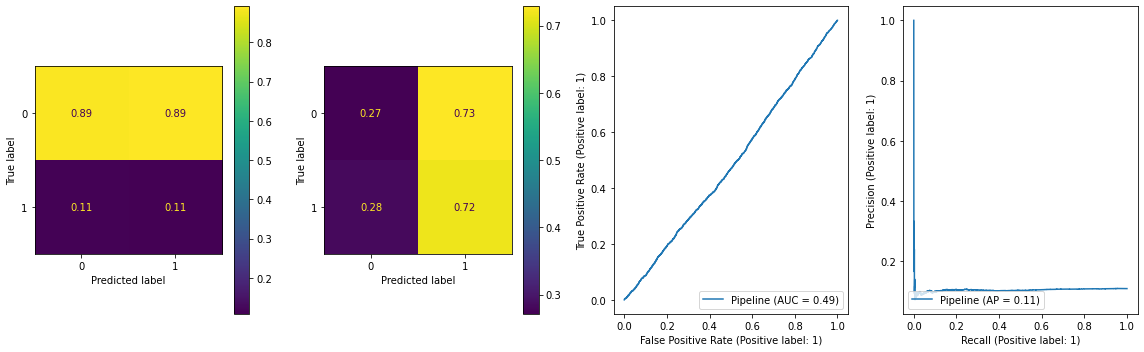

In [292]:
xtrain_test,xval,ytrain_test,yval = train_test_split(df_num_non,y_non,train_size=0.95,shuffle=True)
xtrain,xtest,ytrain,ytest = train_test_split(xtrain_test,ytrain_test,train_size=0.8,shuffle=True)
pt = PowerTransformer()
xtrain_pt = pd.DataFrame(pt.fit_transform(xtrain),index=xtrain.index,columns=xtrain.columns)
xtest_pt = pd.DataFrame(pt.transform(xtest),index=xtest.index,columns=xtest.columns)
xval_pt = pd.DataFrame(pt.transform(xval),index=xval.index,columns=xval.columns)

undersamp = RandomUnderSampler(random_state=1)
nm = NearMiss()

gnb = GaussianNB()

# pipeline for each type of sampler
pipeline_0 = Pipeline([('GaussianNB', gnb)])
pipeline_1 = Pipeline([('undersamp', undersamp), ('GaussianNB', gnb)])
pipeline_2 = Pipeline([('nearmiss', nm), ('GaussianNB', gnb)])

# loop to run all pipelines
pipeline_list = [pipeline_0, pipeline_1, pipeline_2]
for num, pipeline in enumerate(pipeline_list):
    print("Estimating Pipeline {}".format(pipeline))
    pipeline.fit(xtrain_pt, ytrain)
    #y_pred = pipeline.predict(xtest_pt)
    #probs = pipeline.predict_proba(xtest_pt)[:,1]
    #print("Confusion Matrix for pipeline {}:".format(num))
    #print(confusion_matrix(ytest, y_pred))
    #cm = confusion_matrix(ytest, y_pred) 
    
    plt.figure(figsize=(16,5))
    ax1, ax2, ax3, ax4 = plt.subplot(1,4,1), plt.subplot(1,4,2), plt.subplot(1,4,3), plt.subplot(1,4,4)
    metrics.plot_confusion_matrix(pipeline, xtest_pt, ytest, labels = [0, 1], normalize='pred', ax=ax1)
    metrics.plot_confusion_matrix(pipeline, xtest_pt, ytest, labels = [0, 1], normalize='true', ax=ax2)

    metrics.plot_roc_curve(pipeline, xtest_pt, ytest, ax=ax3)
    metrics.plot_precision_recall_curve(pipeline, xtest_pt, ytest, ax=ax4)
    plt.tight_layout()
    plt.show()

# Decision Tree Classifier

In [65]:
def train_pred_report(xtrain_pt,ytrain,xtest_pt,ytest,xval_pt,yval,sampling):
    
    model = DecisionTreeClassifier(random_state=7)
    model.fit(xtrain_pt,ytrain)
    
    ypred_train, yprob_train = model.predict(xtrain_pt), model.predict_proba(xtrain_pt)[:,1]
    ypred_test, yprob_test = model.predict(xtest_pt), model.predict_proba(xtest_pt)[:,1]
    ypred_val, yprob_val = model.predict(xval_pt), model.predict_proba(xval_pt)[:,1]
    
    temp_score = pd.DataFrame(columns=['Precision_0','Precision_1','Recall_0','Recall_1','F_score_0',\
                                       'F_score_1','Accuracy','roc_auc'])
    
    (pr0,pr1), (rc0,rc1), (f0,f1), (sup0,sup1) = metrics.precision_recall_fscore_support(ytrain,ypred_train,labels=[0,1])
    acc, roc_auc = accuracy_score(ytrain,ypred_train), roc_auc_score(ytrain,yprob_train)
    temp_score.loc[str(sampling)+'_Train'] = [pr0,pr1,rc0,rc1,f0,f1,acc,roc_auc]
    
    (pr0,pr1), (rc0,rc1), (f0,f1), (sup0,sup1) = metrics.precision_recall_fscore_support(ytest,ypred_test,labels=[0,1])
    acc, roc_auc = accuracy_score(ytest,ypred_test), roc_auc_score(ytest,yprob_test)
    temp_score.loc[str(sampling)+'_Test'] = [pr0,pr1,rc0,rc1,f0,f1,acc,roc_auc]
    
    (pr0,pr1), (rc0,rc1), (f0,f1), (sup0,sup1) = metrics.precision_recall_fscore_support(yval,ypred_val,labels=[0,1])
    acc, roc_auc = accuracy_score(yval,ypred_val), roc_auc_score(yval,yprob_val)
    temp_score.loc[str(sampling)+'_Val'] = [pr0,pr1,rc0,rc1,f0,f1,acc,roc_auc]
    
    return temp_score

def dtc_model(x,y,k=5):
    xtrain_test,xval,ytrain_test,yval = train_test_split(x,y,train_size=0.95,random_state=7)
    xtrain,xtest,ytrain,ytest = train_test_split(xtrain_test,ytrain_test,train_size=0.8,random_state=7)
    pt = PowerTransformer()
    xtrain_pt = pd.DataFrame(pt.fit_transform(xtrain),index=xtrain.index,columns=xtrain.columns)
    xtest_pt = pd.DataFrame(pt.transform(xtest),index=xtest.index,columns=xtest.columns)
    xval_pt = pd.DataFrame(pt.transform(xval),index=xval.index,columns=xval.columns)
    
    df_score = pd.DataFrame(columns=['Precision_0','Precision_1','Recall_0','Recall_1','F_score_0',\
                                     'F_score_1','Accuracy','roc_auc'])
    
    print('Without sampling techniques')
    score = train_pred_report(xtrain_pt,ytrain,xtest_pt,ytest,xval_pt,yval,sampling=None)
    df_score = pd.concat(objs=[df_score,score])

    rus = RandomUnderSampler(random_state=7,replacement=True)
    xrus, yrus = rus.fit_resample(xtrain_pt,ytrain)
    print('RandomUnderSampling')
    score = train_pred_report(xrus,yrus,xtest_pt,ytest,xval_pt,yval,sampling='RUS')
    df_score = pd.concat(objs=[df_score,score])
    
    nm = NearMiss(n_neighbors=k)
    xnm, ynm = nm.fit_resample(xtrain_pt,ytrain)
    print('Near miss Undersampling')
    score = train_pred_report(xnm,ynm,xtest_pt,ytest,xval_pt,yval,sampling='NearMiss')
    df_score = pd.concat(objs=[df_score,score])

    ros = RandomOverSampler(random_state=7)
    xros, yros = ros.fit_resample(xtrain_pt,ytrain)
    print('RandomOverSampling')
    score = train_pred_report(xros,yros,xtest_pt,ytest,xval_pt,yval,sampling='ROS')
    df_score = pd.concat(objs=[df_score,score])

    smt = SMOTE(random_state=7,k_neighbors=k)
    xsmt, ysmt = smt.fit_resample(xtrain_pt,ytrain)
    print('SMOTE-Oversampling')
    score = train_pred_report(xsmt, ysmt,xtest_pt,ytest,xval_pt,yval,sampling='SMOTE')
    df_score = pd.concat(objs=[df_score,score])
    
    bsmt = BorderlineSMOTE(random_state=7,k_neighbors=k)
    xbsmt, ybsmt = bsmt.fit_resample(xtrain_pt,ytrain)
    print('Borderline-SMOTE')
    score = train_pred_report(xbsmt, ybsmt,xtest_pt,ytest,xval_pt,yval,sampling='BL-SMOTE')
    df_score = pd.concat(objs=[df_score,score])
    
    asn = ADASYN(random_state=7,n_neighbors=k)
    xasn, yasn = asn.fit_resample(xtrain_pt,ytrain)
    print('ADASYN-Oversampling')
    score = train_pred_report(xasn, yasn,xtest_pt,ytest,xval_pt,yval,sampling='ADASYN')
    df_score = pd.concat(objs=[df_score,score])

    print('Completed')
    
    a,b = list(df_score.reset_index().iloc[:,0].str.split('_',expand=True).iloc[:,0]), list(df_score.reset_index().iloc[:,0].str.split('_',expand=True).iloc[:,1])
    df_score.insert(0,'Sampling_Type',a)
    df_score.insert(1,'Set_Type',b)
    
    plt.figure(figsize=(16,3))
    X_axis = np.arange(df_score.Sampling_Type.nunique())
    plt.bar(X_axis - 0.2, df_score.Recall_1[df_score.Set_Type=='Test'], 0.4, label = 'Test')
    plt.bar(X_axis + 0.2, df_score.Recall_1[df_score.Set_Type=='Val'], 0.4, label = 'Val')
    plt.xticks(X_axis,list(df_score.Sampling_Type.unique()))
    plt.yticks(np.arange(0,1.01,0.1))
    plt.xlabel('Sampling Technique')
    plt.ylabel('Recall for not admitted')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(16,3))
    X_axis = np.arange(df_score.Sampling_Type.nunique())
    plt.bar(X_axis - 0.2, df_score.Precision_1[df_score.Set_Type=='Test'], 0.4, label = 'Test')
    plt.bar(X_axis + 0.2, df_score.Precision_1[df_score.Set_Type=='Val'], 0.4, label = 'Val')
    plt.xticks(X_axis,list(df_score.Sampling_Type.unique()))
    plt.yticks(np.arange(0,1.01,0.1))
    plt.xlabel('Sampling Technique')
    plt.ylabel('Precision for not admitted')
    plt.legend()
    plt.show()
    
    return df_score

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


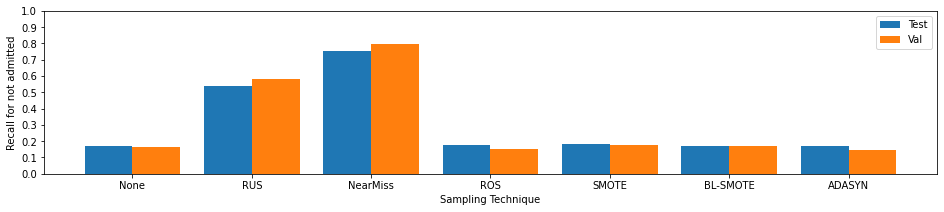

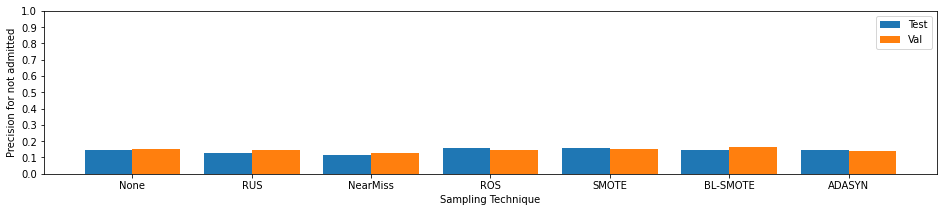

In [413]:
dtc_model_score_non_all = dtc_model(df_non_final,y_non)
dtc_model_score_non_all.to_csv('dtc_model_score_non_all.csv')

### Only categorical variables

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


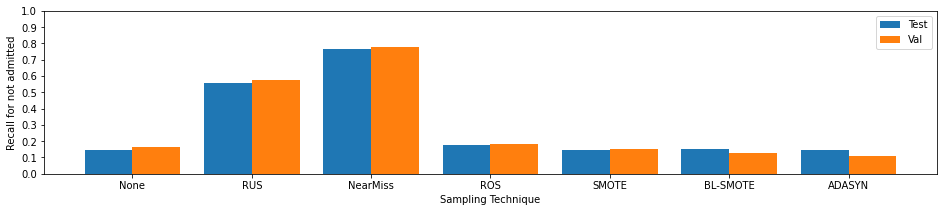

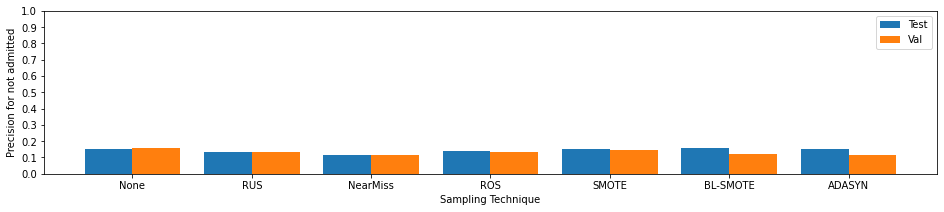

In [414]:
#df_num_non,df_cat_non_dummy
dtc_model_score_non_cat = dtc_model(df_cat_non_dummy,y_non)
dtc_model_score_non_cat.to_csv('dtc_model_score_non_cat.csv')

### Only numerical variables

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


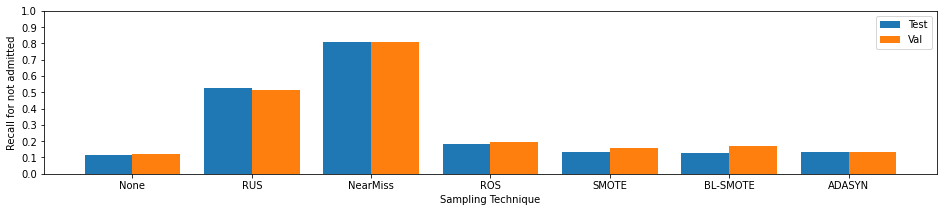

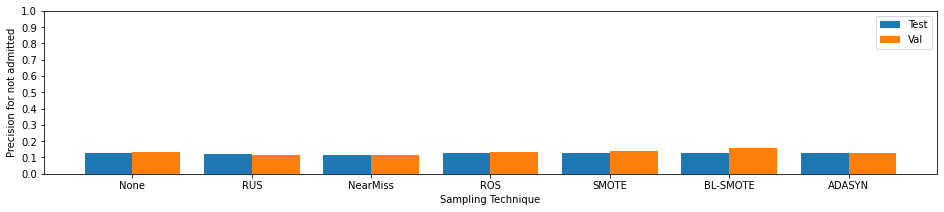

In [415]:
#df_num_non,df_cat_non_dummy
dtc_model_score_non_num = dtc_model(df_num_non,y_non)
dtc_model_score_non_num.to_csv('dtc_model_score_non_num.csv')

Estimating Pipeline Pipeline(steps=[('DecisionTree', DecisionTreeClassifier(random_state=7))])


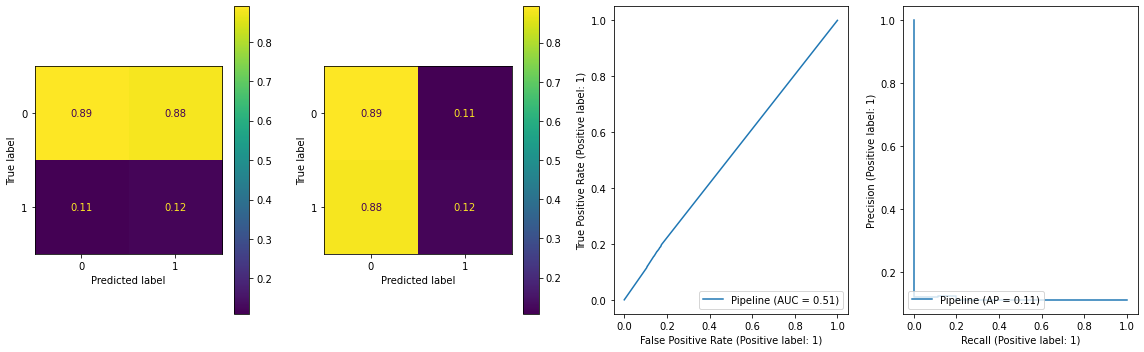

Estimating Pipeline Pipeline(steps=[('undersamp', RandomUnderSampler(random_state=7)),
                ('DecisionTree', DecisionTreeClassifier(random_state=7))])


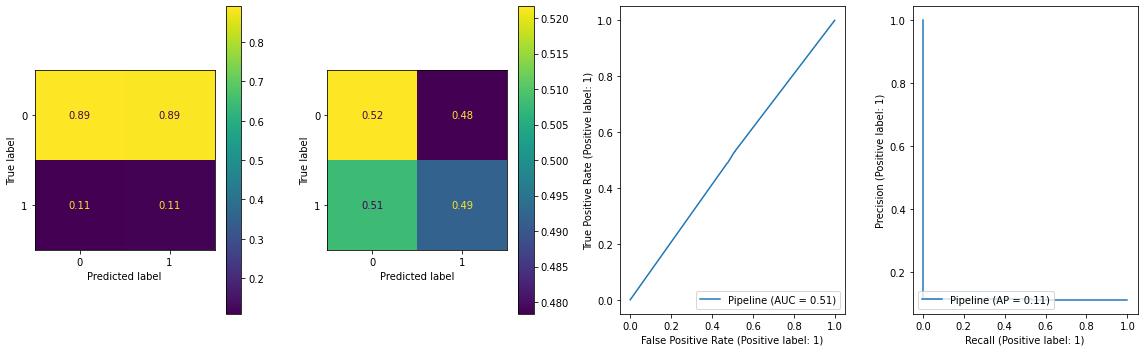

Estimating Pipeline Pipeline(steps=[('nearmiss', NearMiss()),
                ('DecisionTree', DecisionTreeClassifier(random_state=7))])


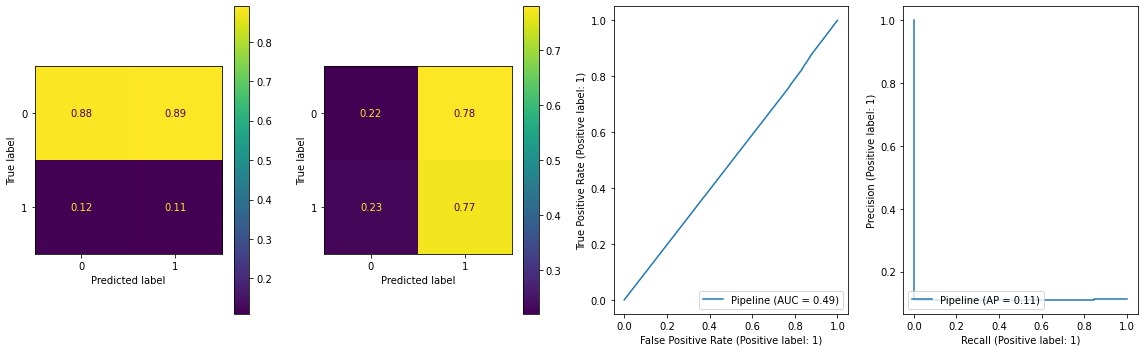

In [416]:
xtrain_test,xval,ytrain_test,yval = train_test_split(df_num_non,y_non,train_size=0.95,shuffle=True)
xtrain,xtest,ytrain,ytest = train_test_split(xtrain_test,ytrain_test,train_size=0.8,shuffle=True)
pt = PowerTransformer()
xtrain_pt = pd.DataFrame(pt.fit_transform(xtrain),index=xtrain.index,columns=xtrain.columns)
xtest_pt = pd.DataFrame(pt.transform(xtest),index=xtest.index,columns=xtest.columns)
xval_pt = pd.DataFrame(pt.transform(xval),index=xval.index,columns=xval.columns)

undersamp = RandomUnderSampler(random_state=7)
nm = NearMiss()

dtc = DecisionTreeClassifier(random_state=7)

# pipeline for each type of sampler
pipeline_0 = Pipeline([('DecisionTree', dtc)])
pipeline_1 = Pipeline([('undersamp', undersamp), ('DecisionTree', dtc)])
pipeline_2 = Pipeline([('nearmiss', nm), ('DecisionTree', dtc)])

# loop to run all pipelines
pipeline_list = [pipeline_0, pipeline_1, pipeline_2]
for num, pipeline in enumerate(pipeline_list):
    print("Estimating Pipeline {}".format(pipeline))
    pipeline.fit(xtrain_pt, ytrain)
    #y_pred = pipeline.predict(xtest_pt)
    #probs = pipeline.predict_proba(xtest_pt)[:,1]
    #print("Confusion Matrix for pipeline {}:".format(num))
    #print(confusion_matrix(ytest, y_pred))
    #cm = confusion_matrix(ytest, y_pred) 
    
    plt.figure(figsize=(16,5))
    ax1, ax2, ax3, ax4 = plt.subplot(1,4,1), plt.subplot(1,4,2), plt.subplot(1,4,3), plt.subplot(1,4,4)
    metrics.plot_confusion_matrix(pipeline, xtest_pt, ytest, labels = [0, 1], normalize='pred', ax=ax1)
    metrics.plot_confusion_matrix(pipeline, xtest_pt, ytest, labels = [0, 1], normalize='true', ax=ax2)

    metrics.plot_roc_curve(pipeline, xtest_pt, ytest, ax=ax3)
    metrics.plot_precision_recall_curve(pipeline, xtest_pt, ytest, ax=ax4)
    plt.tight_layout()
    plt.show()

# Random Forest Classifier

In [417]:
def train_pred_report(xtrain_pt,ytrain,xtest_pt,ytest,xval_pt,yval,sampling):
    
    model = RandomForestClassifier(random_state=7)
    model.fit(xtrain_pt,ytrain)
    
    ypred_train, yprob_train = model.predict(xtrain_pt), model.predict_proba(xtrain_pt)[:,1]
    ypred_test, yprob_test = model.predict(xtest_pt), model.predict_proba(xtest_pt)[:,1]
    ypred_val, yprob_val = model.predict(xval_pt), model.predict_proba(xval_pt)[:,1]
    
    temp_score = pd.DataFrame(columns=['Precision_0','Precision_1','Recall_0','Recall_1','F_score_0',\
                                       'F_score_1','Accuracy','roc_auc'])
    
    (pr0,pr1), (rc0,rc1), (f0,f1), (sup0,sup1) = metrics.precision_recall_fscore_support(ytrain,ypred_train,labels=[0,1])
    acc, roc_auc = accuracy_score(ytrain,ypred_train), roc_auc_score(ytrain,yprob_train)
    temp_score.loc[str(sampling)+'_Train'] = [pr0,pr1,rc0,rc1,f0,f1,acc,roc_auc]
    
    (pr0,pr1), (rc0,rc1), (f0,f1), (sup0,sup1) = metrics.precision_recall_fscore_support(ytest,ypred_test,labels=[0,1])
    acc, roc_auc = accuracy_score(ytest,ypred_test), roc_auc_score(ytest,yprob_test)
    temp_score.loc[str(sampling)+'_Test'] = [pr0,pr1,rc0,rc1,f0,f1,acc,roc_auc]
    
    (pr0,pr1), (rc0,rc1), (f0,f1), (sup0,sup1) = metrics.precision_recall_fscore_support(yval,ypred_val,labels=[0,1])
    acc, roc_auc = accuracy_score(yval,ypred_val), roc_auc_score(yval,yprob_val)
    temp_score.loc[str(sampling)+'_Val'] = [pr0,pr1,rc0,rc1,f0,f1,acc,roc_auc]
    
    return temp_score

def rfc_model(x,y,k=5):
    xtrain_test,xval,ytrain_test,yval = train_test_split(x,y,train_size=0.95,random_state=7)
    xtrain,xtest,ytrain,ytest = train_test_split(xtrain_test,ytrain_test,train_size=0.8,random_state=7)
    pt = PowerTransformer()
    xtrain_pt = pd.DataFrame(pt.fit_transform(xtrain),index=xtrain.index,columns=xtrain.columns)
    xtest_pt = pd.DataFrame(pt.transform(xtest),index=xtest.index,columns=xtest.columns)
    xval_pt = pd.DataFrame(pt.transform(xval),index=xval.index,columns=xval.columns)
    
    df_score = pd.DataFrame(columns=['Precision_0','Precision_1','Recall_0','Recall_1','F_score_0',\
                                     'F_score_1','Accuracy','roc_auc'])
    
    print('Without sampling techniques')
    score = train_pred_report(xtrain_pt,ytrain,xtest_pt,ytest,xval_pt,yval,sampling=None)
    df_score = pd.concat(objs=[df_score,score])

    rus = RandomUnderSampler(random_state=7,replacement=True)
    xrus, yrus = rus.fit_resample(xtrain_pt,ytrain)
    print('RandomUnderSampling')
    score = train_pred_report(xrus,yrus,xtest_pt,ytest,xval_pt,yval,sampling='RUS')
    df_score = pd.concat(objs=[df_score,score])
    
    nm = NearMiss(n_neighbors=k)
    xnm, ynm = nm.fit_resample(xtrain_pt,ytrain)
    print('Near miss Undersampling')
    score = train_pred_report(xnm,ynm,xtest_pt,ytest,xval_pt,yval,sampling='NearMiss')
    df_score = pd.concat(objs=[df_score,score])

    ros = RandomOverSampler(random_state=7)
    xros, yros = ros.fit_resample(xtrain_pt,ytrain)
    print('RandomOverSampling')
    score = train_pred_report(xros,yros,xtest_pt,ytest,xval_pt,yval,sampling='ROS')
    df_score = pd.concat(objs=[df_score,score])

    smt = SMOTE(random_state=7,k_neighbors=k)
    xsmt, ysmt = smt.fit_resample(xtrain_pt,ytrain)
    print('SMOTE-Oversampling')
    score = train_pred_report(xsmt, ysmt,xtest_pt,ytest,xval_pt,yval,sampling='SMOTE')
    df_score = pd.concat(objs=[df_score,score])
    
    bsmt = BorderlineSMOTE(random_state=7,k_neighbors=k)
    xbsmt, ybsmt = bsmt.fit_resample(xtrain_pt,ytrain)
    print('Borderline-SMOTE')
    score = train_pred_report(xbsmt, ybsmt,xtest_pt,ytest,xval_pt,yval,sampling='BL-SMOTE')
    df_score = pd.concat(objs=[df_score,score])
    
    asn = ADASYN(random_state=7,n_neighbors=k)
    xasn, yasn = asn.fit_resample(xtrain_pt,ytrain)
    print('ADASYN-Oversampling')
    score = train_pred_report(xasn, yasn,xtest_pt,ytest,xval_pt,yval,sampling='ADASYN')
    df_score = pd.concat(objs=[df_score,score])

    print('Completed')
    
    a,b = list(df_score.reset_index().iloc[:,0].str.split('_',expand=True).iloc[:,0]), list(df_score.reset_index().iloc[:,0].str.split('_',expand=True).iloc[:,1])
    df_score.insert(0,'Sampling_Type',a)
    df_score.insert(1,'Set_Type',b)
    
    plt.figure(figsize=(16,3))
    X_axis = np.arange(df_score.Sampling_Type.nunique())
    plt.bar(X_axis - 0.2, df_score.Recall_1[df_score.Set_Type=='Test'], 0.4, label = 'Test')
    plt.bar(X_axis + 0.2, df_score.Recall_1[df_score.Set_Type=='Val'], 0.4, label = 'Val')
    plt.xticks(X_axis,list(df_score.Sampling_Type.unique()))
    plt.yticks(np.arange(0,1.01,0.1))
    plt.xlabel('Sampling Technique')
    plt.ylabel('Recall for not admitted')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(16,3))
    X_axis = np.arange(df_score.Sampling_Type.nunique())
    plt.bar(X_axis - 0.2, df_score.Precision_1[df_score.Set_Type=='Test'], 0.4, label = 'Test')
    plt.bar(X_axis + 0.2, df_score.Precision_1[df_score.Set_Type=='Val'], 0.4, label = 'Val')
    plt.xticks(X_axis,list(df_score.Sampling_Type.unique()))
    plt.yticks(np.arange(0,1.01,0.1))
    plt.xlabel('Sampling Technique')
    plt.ylabel('Precision for not admitted')
    plt.legend()
    plt.show()
    
    return df_score

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


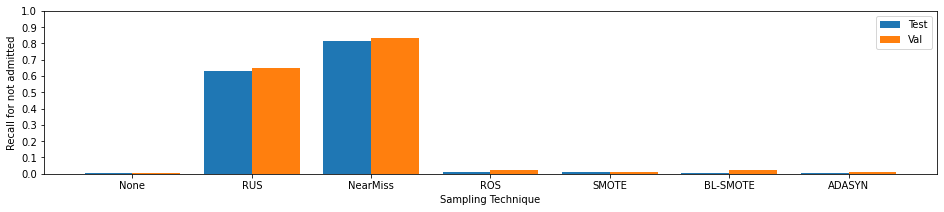

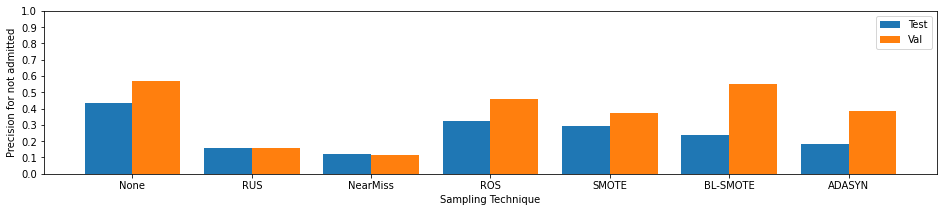

In [418]:
rfc_model_score_non_all = rfc_model(df_non_final,y_non)
rfc_model_score_non_all.to_csv('rfc_model_score_non_all.csv')

### Only categorical variables

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


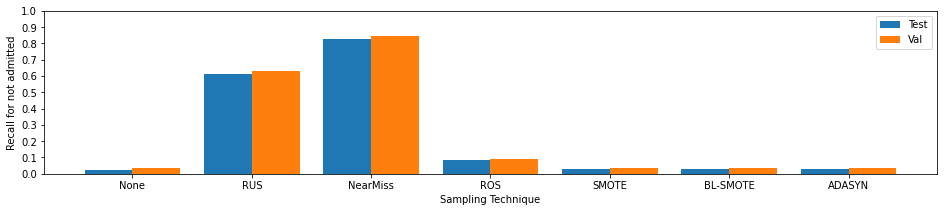

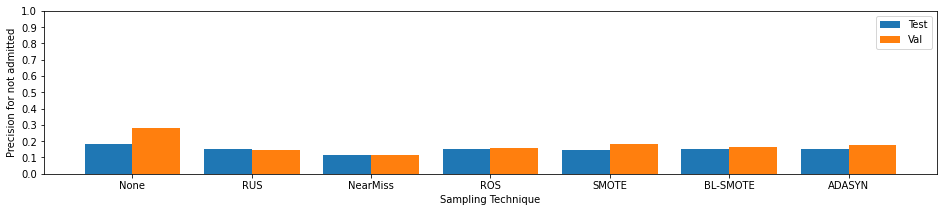

In [419]:
#df_num_non,df_cat_non_dummy
rfc_model_score_non_cat = rfc_model(df_cat_non_dummy,y_non)
rfc_model_score_non_cat.to_csv('rfc_model_score_non_cat.csv')

### Only numerical variables

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


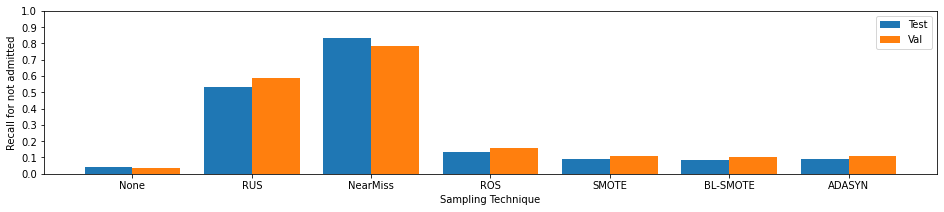

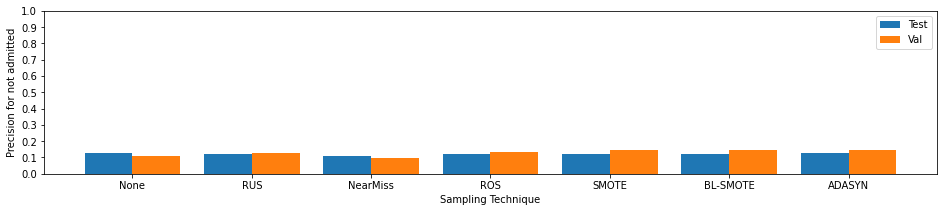

In [420]:
#df_num_non,df_cat_non_dummy
rfc_model_score_non_num = rfc_model(df_num_non,y_non)
rfc_model_score_non_num.to_csv('rfc_model_score_non_num.csv')

Estimating Pipeline Pipeline(steps=[('DecisionTree', DecisionTreeClassifier(random_state=7))])


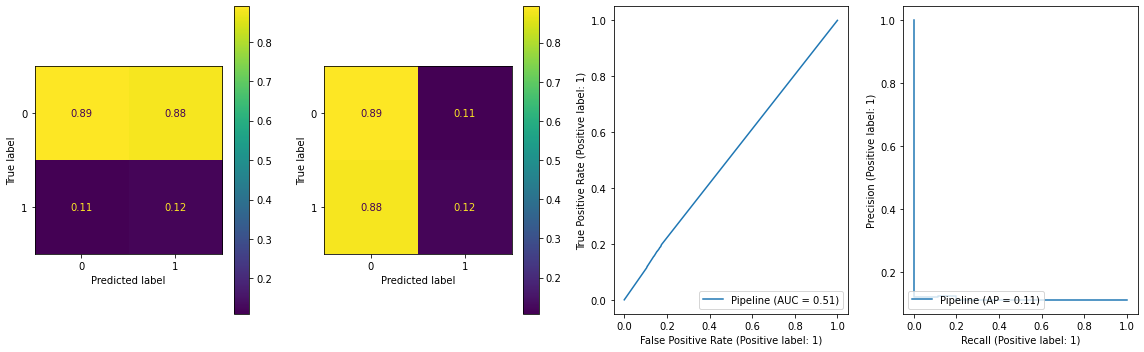

Estimating Pipeline Pipeline(steps=[('undersamp', RandomUnderSampler(random_state=7)),
                ('DecisionTree', DecisionTreeClassifier(random_state=7))])


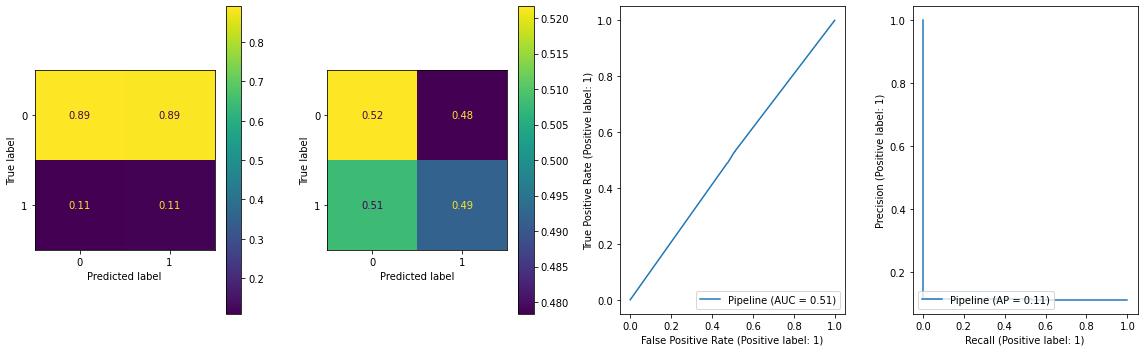

Estimating Pipeline Pipeline(steps=[('nearmiss', NearMiss()),
                ('DecisionTree', DecisionTreeClassifier(random_state=7))])


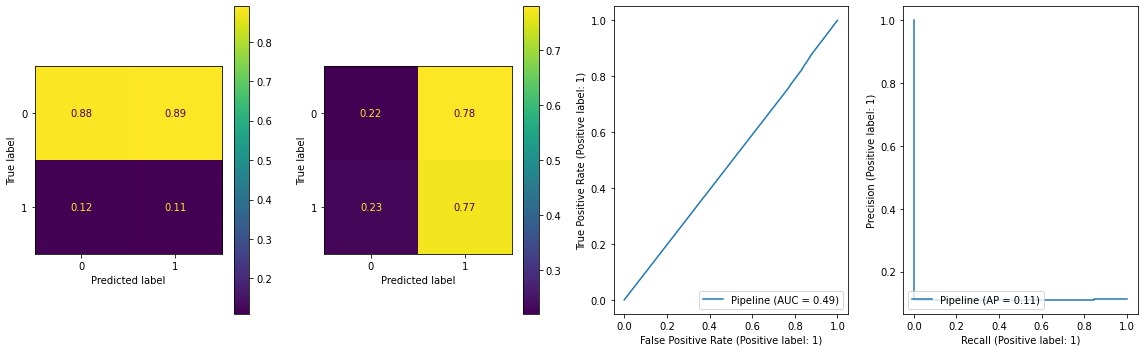

In [416]:
xtrain_test,xval,ytrain_test,yval = train_test_split(df_num_non,y_non,train_size=0.95,shuffle=True)
xtrain,xtest,ytrain,ytest = train_test_split(xtrain_test,ytrain_test,train_size=0.8,shuffle=True)
pt = PowerTransformer()
xtrain_pt = pd.DataFrame(pt.fit_transform(xtrain),index=xtrain.index,columns=xtrain.columns)
xtest_pt = pd.DataFrame(pt.transform(xtest),index=xtest.index,columns=xtest.columns)
xval_pt = pd.DataFrame(pt.transform(xval),index=xval.index,columns=xval.columns)

undersamp = RandomUnderSampler(random_state=7)
nm = NearMiss()

dtc = DecisionTreeClassifier(random_state=7)

# pipeline for each type of sampler
pipeline_0 = Pipeline([('DecisionTree', dtc)])
pipeline_1 = Pipeline([('undersamp', undersamp), ('DecisionTree', dtc)])
pipeline_2 = Pipeline([('nearmiss', nm), ('DecisionTree', dtc)])

# loop to run all pipelines
pipeline_list = [pipeline_0, pipeline_1, pipeline_2]
for num, pipeline in enumerate(pipeline_list):
    print("Estimating Pipeline {}".format(pipeline))
    pipeline.fit(xtrain_pt, ytrain)
    #y_pred = pipeline.predict(xtest_pt)
    #probs = pipeline.predict_proba(xtest_pt)[:,1]
    #print("Confusion Matrix for pipeline {}:".format(num))
    #print(confusion_matrix(ytest, y_pred))
    #cm = confusion_matrix(ytest, y_pred) 
    
    plt.figure(figsize=(16,5))
    ax1, ax2, ax3, ax4 = plt.subplot(1,4,1), plt.subplot(1,4,2), plt.subplot(1,4,3), plt.subplot(1,4,4)
    metrics.plot_confusion_matrix(pipeline, xtest_pt, ytest, labels = [0, 1], normalize='pred', ax=ax1)
    metrics.plot_confusion_matrix(pipeline, xtest_pt, ytest, labels = [0, 1], normalize='true', ax=ax2)

    metrics.plot_roc_curve(pipeline, xtest_pt, ytest, ax=ax3)
    metrics.plot_precision_recall_curve(pipeline, xtest_pt, ytest, ax=ax4)
    plt.tight_layout()
    plt.show()

# GradientBoostingClassifier

In [67]:
from sklearn.ensemble import GradientBoostingClassifier

In [74]:
def train_pred_report(xtrain_pt,ytrain,xtest_pt,ytest,xval_pt,yval,sampling):
    
    model = GradientBoostingClassifier(random_state=7)
    model.fit(xtrain_pt,ytrain)
    
    ypred_train, yprob_train = model.predict(xtrain_pt), model.predict_proba(xtrain_pt)[:,1]
    ypred_test, yprob_test = model.predict(xtest_pt), model.predict_proba(xtest_pt)[:,1]
    ypred_val, yprob_val = model.predict(xval_pt), model.predict_proba(xval_pt)[:,1]
    
    temp_score = pd.DataFrame(columns=['Precision_0','Precision_1','Recall_0','Recall_1','F_score_0',\
                                       'F_score_1','Accuracy','roc_auc'])
    
    (pr0,pr1), (rc0,rc1), (f0,f1), (sup0,sup1) = metrics.precision_recall_fscore_support(ytrain,ypred_train,labels=[0,1])
    acc, roc_auc = accuracy_score(ytrain,ypred_train), roc_auc_score(ytrain,yprob_train)
    temp_score.loc[str(sampling)+'_Train'] = [pr0,pr1,rc0,rc1,f0,f1,acc,roc_auc]
    
    (pr0,pr1), (rc0,rc1), (f0,f1), (sup0,sup1) = metrics.precision_recall_fscore_support(ytest,ypred_test,labels=[0,1])
    acc, roc_auc = accuracy_score(ytest,ypred_test), roc_auc_score(ytest,yprob_test)
    temp_score.loc[str(sampling)+'_Test'] = [pr0,pr1,rc0,rc1,f0,f1,acc,roc_auc]
    
    (pr0,pr1), (rc0,rc1), (f0,f1), (sup0,sup1) = metrics.precision_recall_fscore_support(yval,ypred_val,labels=[0,1])
    acc, roc_auc = accuracy_score(yval,ypred_val), roc_auc_score(yval,yprob_val)
    temp_score.loc[str(sampling)+'_Val'] = [pr0,pr1,rc0,rc1,f0,f1,acc,roc_auc]
    
    return temp_score

def gbc_model(x,y,k=5):
    xtrain_test,xval,ytrain_test,yval = train_test_split(x,y,train_size=0.95,random_state=7)
    xtrain,xtest,ytrain,ytest = train_test_split(xtrain_test,ytrain_test,train_size=0.8,random_state=7)
    pt = PowerTransformer()
    xtrain_pt = pd.DataFrame(pt.fit_transform(xtrain),index=xtrain.index,columns=xtrain.columns)
    xtest_pt = pd.DataFrame(pt.transform(xtest),index=xtest.index,columns=xtest.columns)
    xval_pt = pd.DataFrame(pt.transform(xval),index=xval.index,columns=xval.columns)
    
    df_score = pd.DataFrame(columns=['Precision_0','Precision_1','Recall_0','Recall_1','F_score_0',\
                                     'F_score_1','Accuracy','roc_auc'])
    
    print('Without sampling techniques')
    score = train_pred_report(xtrain_pt,ytrain,xtest_pt,ytest,xval_pt,yval,sampling=None)
    df_score = pd.concat(objs=[df_score,score])

    rus = RandomUnderSampler(random_state=7,replacement=True)
    xrus, yrus = rus.fit_resample(xtrain_pt,ytrain)
    print('RandomUnderSampling')
    score = train_pred_report(xrus,yrus,xtest_pt,ytest,xval_pt,yval,sampling='RUS')
    df_score = pd.concat(objs=[df_score,score])
    
    nm = NearMiss(n_neighbors=k)
    xnm, ynm = nm.fit_resample(xtrain_pt,ytrain)
    print('Near miss Undersampling')
    score = train_pred_report(xnm,ynm,xtest_pt,ytest,xval_pt,yval,sampling='NearMiss')
    df_score = pd.concat(objs=[df_score,score])

    ros = RandomOverSampler(random_state=7)
    xros, yros = ros.fit_resample(xtrain_pt,ytrain)
    print('RandomOverSampling')
    score = train_pred_report(xros,yros,xtest_pt,ytest,xval_pt,yval,sampling='ROS')
    df_score = pd.concat(objs=[df_score,score])

    smt = SMOTE(random_state=7,k_neighbors=k)
    xsmt, ysmt = smt.fit_resample(xtrain_pt,ytrain)
    print('SMOTE-Oversampling')
    score = train_pred_report(xsmt, ysmt,xtest_pt,ytest,xval_pt,yval,sampling='SMOTE')
    df_score = pd.concat(objs=[df_score,score])
    
    bsmt = BorderlineSMOTE(random_state=7,k_neighbors=k)
    xbsmt, ybsmt = bsmt.fit_resample(xtrain_pt,ytrain)
    print('Borderline-SMOTE')
    score = train_pred_report(xbsmt, ybsmt,xtest_pt,ytest,xval_pt,yval,sampling='BL-SMOTE')
    df_score = pd.concat(objs=[df_score,score])
    
    asn = ADASYN(random_state=7,n_neighbors=k)
    xasn, yasn = asn.fit_resample(xtrain_pt,ytrain)
    print('ADASYN-Oversampling')
    score = train_pred_report(xasn, yasn,xtest_pt,ytest,xval_pt,yval,sampling='ADASYN')
    df_score = pd.concat(objs=[df_score,score])

    print('Completed')
    
    a,b = list(df_score.reset_index().iloc[:,0].str.split('_',expand=True).iloc[:,0]), list(df_score.reset_index().iloc[:,0].str.split('_',expand=True).iloc[:,1])
    df_score.insert(0,'Sampling_Type',a)
    df_score.insert(1,'Set_Type',b)
    
    plt.figure(figsize=(16,3))
    X_axis = np.arange(df_score.Sampling_Type.nunique())
    plt.bar(X_axis - 0.2, df_score.Recall_1[df_score.Set_Type=='Test'], 0.4, label = 'Test')
    plt.bar(X_axis + 0.2, df_score.Recall_1[df_score.Set_Type=='Val'], 0.4, label = 'Val')
    plt.xticks(X_axis,list(df_score.Sampling_Type.unique()))
    plt.yticks(np.arange(0,1.01,0.1))
    plt.xlabel('Sampling Technique')
    plt.ylabel('Recall for not admitted')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(16,3))
    X_axis = np.arange(df_score.Sampling_Type.nunique())
    plt.bar(X_axis - 0.2, df_score.Precision_1[df_score.Set_Type=='Test'], 0.4, label = 'Test')
    plt.bar(X_axis + 0.2, df_score.Precision_1[df_score.Set_Type=='Val'], 0.4, label = 'Val')
    plt.xticks(X_axis,list(df_score.Sampling_Type.unique()))
    plt.yticks(np.arange(0,1.01,0.1))
    plt.xlabel('Sampling Technique')
    plt.ylabel('Precision for not admitted')
    plt.legend()
    plt.show()
    
    return df_score

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


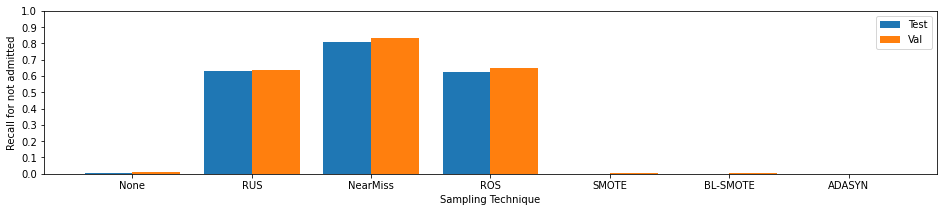

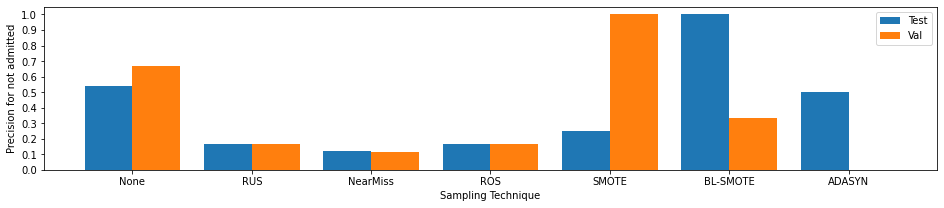

In [70]:
gbc_model_score_non_all = gbc_model(df_non_final,y_non)
gbc_model_score_non_all.to_csv('gbc_model_score_non_all.csv')

### Only categorical variables

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


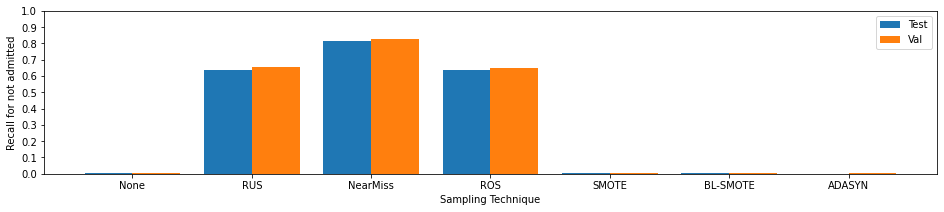

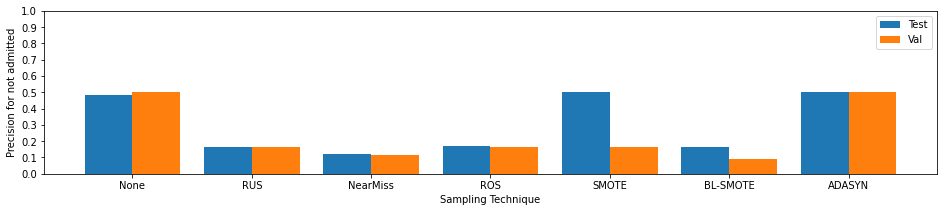

In [72]:
#df_num_non,df_cat_non_dummy
gbc_model_score_non_cat = gbc_model(df_cat_non_dummy,y_non)
gbc_model_score_non_cat.to_csv('gbc_model_score_non_cat.csv')

### Only numerical variables

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


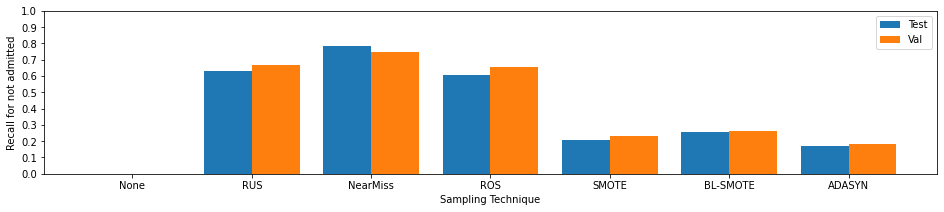

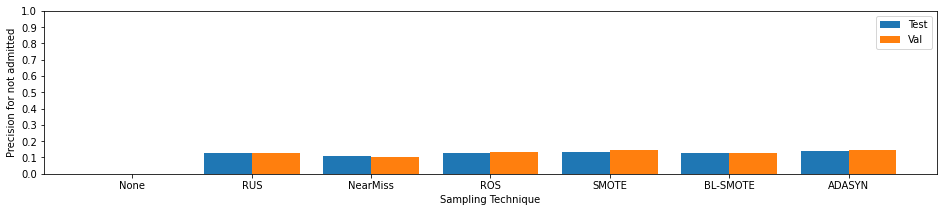

In [73]:
#df_num_non,df_cat_non_dummy
gbc_model_score_non_num = gbc_model(df_num_non,y_non)
gbc_model_score_non_num.to_csv('gbc_model_score_non_num.csv')

Estimating Pipeline Pipeline(steps=[('DecisionTree', DecisionTreeClassifier(random_state=7))])


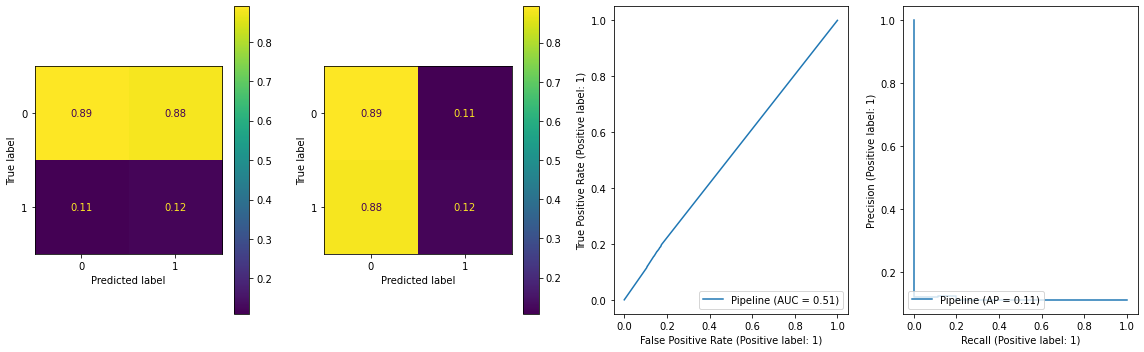

Estimating Pipeline Pipeline(steps=[('undersamp', RandomUnderSampler(random_state=7)),
                ('DecisionTree', DecisionTreeClassifier(random_state=7))])


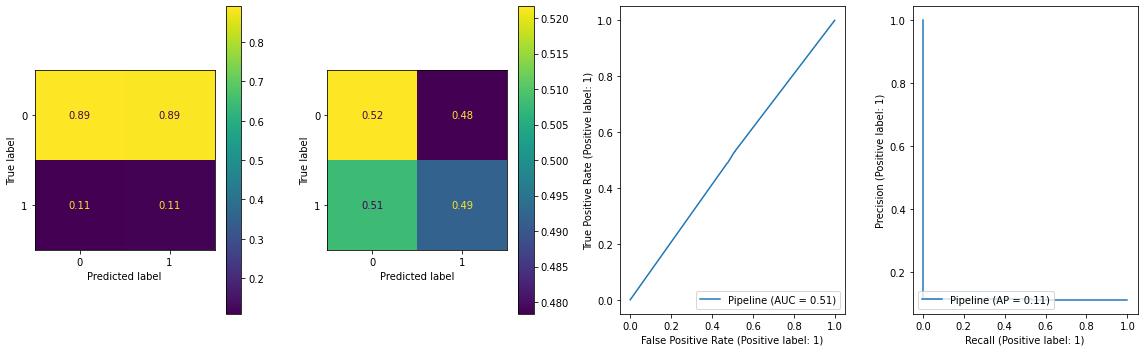

Estimating Pipeline Pipeline(steps=[('nearmiss', NearMiss()),
                ('DecisionTree', DecisionTreeClassifier(random_state=7))])


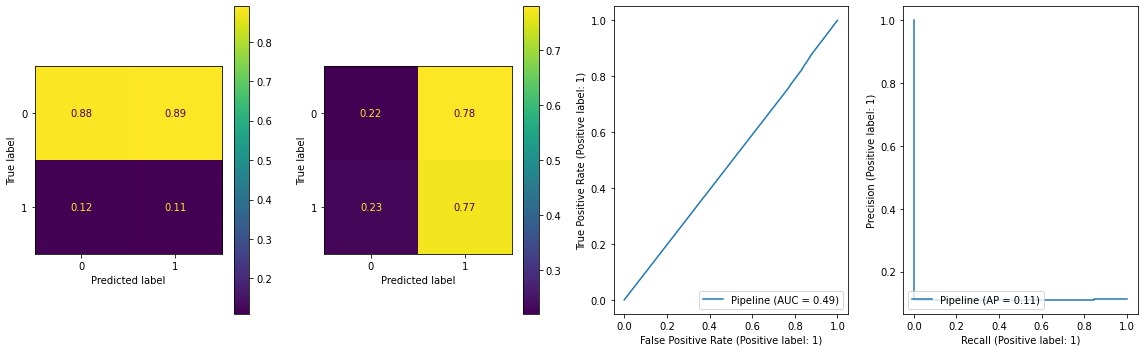

In [416]:
xtrain_test,xval,ytrain_test,yval = train_test_split(df_num_non,y_non,train_size=0.95,shuffle=True)
xtrain,xtest,ytrain,ytest = train_test_split(xtrain_test,ytrain_test,train_size=0.8,shuffle=True)
pt = PowerTransformer()
xtrain_pt = pd.DataFrame(pt.fit_transform(xtrain),index=xtrain.index,columns=xtrain.columns)
xtest_pt = pd.DataFrame(pt.transform(xtest),index=xtest.index,columns=xtest.columns)
xval_pt = pd.DataFrame(pt.transform(xval),index=xval.index,columns=xval.columns)

undersamp = RandomUnderSampler(random_state=7)
nm = NearMiss()

dtc = DecisionTreeClassifier(random_state=7)

# pipeline for each type of sampler
pipeline_0 = Pipeline([('DecisionTree', dtc)])
pipeline_1 = Pipeline([('undersamp', undersamp), ('DecisionTree', dtc)])
pipeline_2 = Pipeline([('nearmiss', nm), ('DecisionTree', dtc)])

# loop to run all pipelines
pipeline_list = [pipeline_0, pipeline_1, pipeline_2]
for num, pipeline in enumerate(pipeline_list):
    print("Estimating Pipeline {}".format(pipeline))
    pipeline.fit(xtrain_pt, ytrain)
    #y_pred = pipeline.predict(xtest_pt)
    #probs = pipeline.predict_proba(xtest_pt)[:,1]
    #print("Confusion Matrix for pipeline {}:".format(num))
    #print(confusion_matrix(ytest, y_pred))
    #cm = confusion_matrix(ytest, y_pred) 
    
    plt.figure(figsize=(16,5))
    ax1, ax2, ax3, ax4 = plt.subplot(1,4,1), plt.subplot(1,4,2), plt.subplot(1,4,3), plt.subplot(1,4,4)
    metrics.plot_confusion_matrix(pipeline, xtest_pt, ytest, labels = [0, 1], normalize='pred', ax=ax1)
    metrics.plot_confusion_matrix(pipeline, xtest_pt, ytest, labels = [0, 1], normalize='true', ax=ax2)

    metrics.plot_roc_curve(pipeline, xtest_pt, ytest, ax=ax3)
    metrics.plot_precision_recall_curve(pipeline, xtest_pt, ytest, ax=ax4)
    plt.tight_layout()
    plt.show()

# AdaBoostClassifier

In [75]:
from sklearn.ensemble import AdaBoostClassifier

In [76]:
def train_pred_report(xtrain_pt,ytrain,xtest_pt,ytest,xval_pt,yval,sampling):
    
    model = AdaBoostClassifier(random_state=7)
    model.fit(xtrain_pt,ytrain)
    
    ypred_train, yprob_train = model.predict(xtrain_pt), model.predict_proba(xtrain_pt)[:,1]
    ypred_test, yprob_test = model.predict(xtest_pt), model.predict_proba(xtest_pt)[:,1]
    ypred_val, yprob_val = model.predict(xval_pt), model.predict_proba(xval_pt)[:,1]
    
    temp_score = pd.DataFrame(columns=['Precision_0','Precision_1','Recall_0','Recall_1','F_score_0',\
                                       'F_score_1','Accuracy','roc_auc'])
    
    (pr0,pr1), (rc0,rc1), (f0,f1), (sup0,sup1) = metrics.precision_recall_fscore_support(ytrain,ypred_train,labels=[0,1])
    acc, roc_auc = accuracy_score(ytrain,ypred_train), roc_auc_score(ytrain,yprob_train)
    temp_score.loc[str(sampling)+'_Train'] = [pr0,pr1,rc0,rc1,f0,f1,acc,roc_auc]
    
    (pr0,pr1), (rc0,rc1), (f0,f1), (sup0,sup1) = metrics.precision_recall_fscore_support(ytest,ypred_test,labels=[0,1])
    acc, roc_auc = accuracy_score(ytest,ypred_test), roc_auc_score(ytest,yprob_test)
    temp_score.loc[str(sampling)+'_Test'] = [pr0,pr1,rc0,rc1,f0,f1,acc,roc_auc]
    
    (pr0,pr1), (rc0,rc1), (f0,f1), (sup0,sup1) = metrics.precision_recall_fscore_support(yval,ypred_val,labels=[0,1])
    acc, roc_auc = accuracy_score(yval,ypred_val), roc_auc_score(yval,yprob_val)
    temp_score.loc[str(sampling)+'_Val'] = [pr0,pr1,rc0,rc1,f0,f1,acc,roc_auc]
    
    return temp_score

def abc_model(x,y,k=5):
    xtrain_test,xval,ytrain_test,yval = train_test_split(x,y,train_size=0.95,random_state=7)
    xtrain,xtest,ytrain,ytest = train_test_split(xtrain_test,ytrain_test,train_size=0.8,random_state=7)
    pt = PowerTransformer()
    xtrain_pt = pd.DataFrame(pt.fit_transform(xtrain),index=xtrain.index,columns=xtrain.columns)
    xtest_pt = pd.DataFrame(pt.transform(xtest),index=xtest.index,columns=xtest.columns)
    xval_pt = pd.DataFrame(pt.transform(xval),index=xval.index,columns=xval.columns)
    
    df_score = pd.DataFrame(columns=['Precision_0','Precision_1','Recall_0','Recall_1','F_score_0',\
                                     'F_score_1','Accuracy','roc_auc'])
    
    print('Without sampling techniques')
    score = train_pred_report(xtrain_pt,ytrain,xtest_pt,ytest,xval_pt,yval,sampling=None)
    df_score = pd.concat(objs=[df_score,score])

    rus = RandomUnderSampler(random_state=7,replacement=True)
    xrus, yrus = rus.fit_resample(xtrain_pt,ytrain)
    print('RandomUnderSampling')
    score = train_pred_report(xrus,yrus,xtest_pt,ytest,xval_pt,yval,sampling='RUS')
    df_score = pd.concat(objs=[df_score,score])
    
    nm = NearMiss(n_neighbors=k)
    xnm, ynm = nm.fit_resample(xtrain_pt,ytrain)
    print('Near miss Undersampling')
    score = train_pred_report(xnm,ynm,xtest_pt,ytest,xval_pt,yval,sampling='NearMiss')
    df_score = pd.concat(objs=[df_score,score])

    ros = RandomOverSampler(random_state=7)
    xros, yros = ros.fit_resample(xtrain_pt,ytrain)
    print('RandomOverSampling')
    score = train_pred_report(xros,yros,xtest_pt,ytest,xval_pt,yval,sampling='ROS')
    df_score = pd.concat(objs=[df_score,score])

    smt = SMOTE(random_state=7,k_neighbors=k)
    xsmt, ysmt = smt.fit_resample(xtrain_pt,ytrain)
    print('SMOTE-Oversampling')
    score = train_pred_report(xsmt, ysmt,xtest_pt,ytest,xval_pt,yval,sampling='SMOTE')
    df_score = pd.concat(objs=[df_score,score])
    
    bsmt = BorderlineSMOTE(random_state=7,k_neighbors=k)
    xbsmt, ybsmt = bsmt.fit_resample(xtrain_pt,ytrain)
    print('Borderline-SMOTE')
    score = train_pred_report(xbsmt, ybsmt,xtest_pt,ytest,xval_pt,yval,sampling='BL-SMOTE')
    df_score = pd.concat(objs=[df_score,score])
    
    asn = ADASYN(random_state=7,n_neighbors=k)
    xasn, yasn = asn.fit_resample(xtrain_pt,ytrain)
    print('ADASYN-Oversampling')
    score = train_pred_report(xasn, yasn,xtest_pt,ytest,xval_pt,yval,sampling='ADASYN')
    df_score = pd.concat(objs=[df_score,score])

    print('Completed')
    
    a,b = list(df_score.reset_index().iloc[:,0].str.split('_',expand=True).iloc[:,0]), list(df_score.reset_index().iloc[:,0].str.split('_',expand=True).iloc[:,1])
    df_score.insert(0,'Sampling_Type',a)
    df_score.insert(1,'Set_Type',b)
    
    plt.figure(figsize=(16,3))
    X_axis = np.arange(df_score.Sampling_Type.nunique())
    plt.bar(X_axis - 0.2, df_score.Recall_1[df_score.Set_Type=='Test'], 0.4, label = 'Test')
    plt.bar(X_axis + 0.2, df_score.Recall_1[df_score.Set_Type=='Val'], 0.4, label = 'Val')
    plt.xticks(X_axis,list(df_score.Sampling_Type.unique()))
    plt.yticks(np.arange(0,1.01,0.1))
    plt.xlabel('Sampling Technique')
    plt.ylabel('Recall for not admitted')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(16,3))
    X_axis = np.arange(df_score.Sampling_Type.nunique())
    plt.bar(X_axis - 0.2, df_score.Precision_1[df_score.Set_Type=='Test'], 0.4, label = 'Test')
    plt.bar(X_axis + 0.2, df_score.Precision_1[df_score.Set_Type=='Val'], 0.4, label = 'Val')
    plt.xticks(X_axis,list(df_score.Sampling_Type.unique()))
    plt.yticks(np.arange(0,1.01,0.1))
    plt.xlabel('Sampling Technique')
    plt.ylabel('Precision for not admitted')
    plt.legend()
    plt.show()
    
    return df_score

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


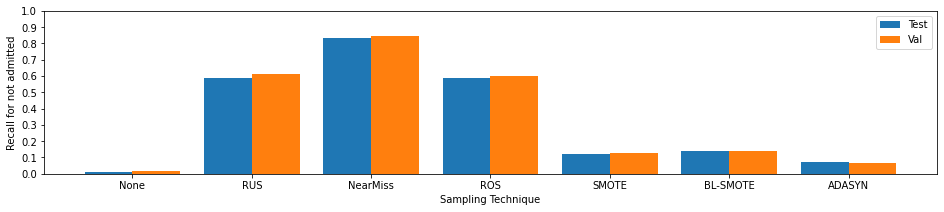

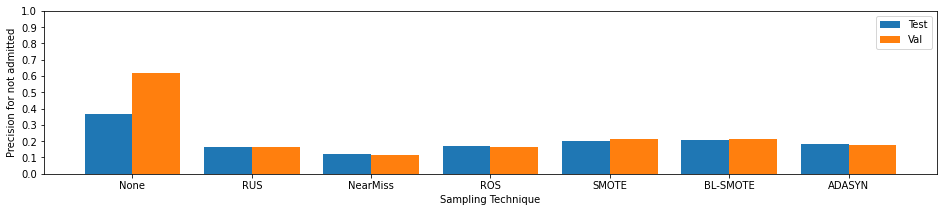

In [78]:
abc_model_score_non_all = abc_model(df_non_final,y_non)
abc_model_score_non_all.to_csv('abc_model_score_non_all.csv')

### Only categorical variables

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


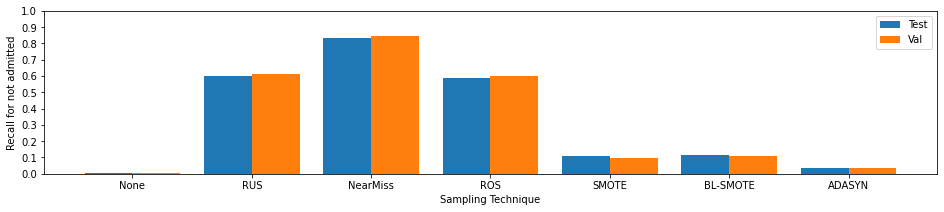

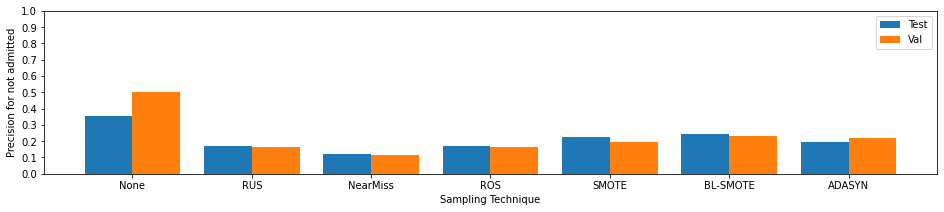

In [81]:
#df_num_non,df_cat_non_dummy
abc_model_score_non_cat = abc_model(df_cat_non_dummy,y_non)
abc_model_score_non_cat.to_csv('abc_model_score_non_cat.csv')

### Only numerical variables

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


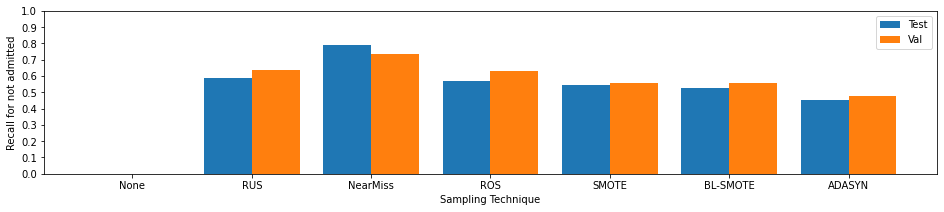

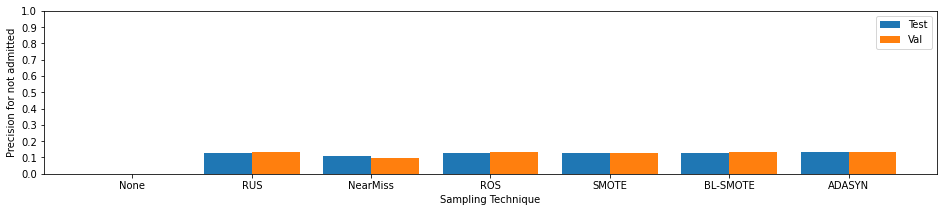

In [80]:
#df_num_non,df_cat_non_dummy
abc_model_score_non_num = abc_model(df_num_non,y_non)
abc_model_score_non_num.to_csv('abc_model_score_non_num.csv')

Estimating Pipeline Pipeline(steps=[('DecisionTree', DecisionTreeClassifier(random_state=7))])


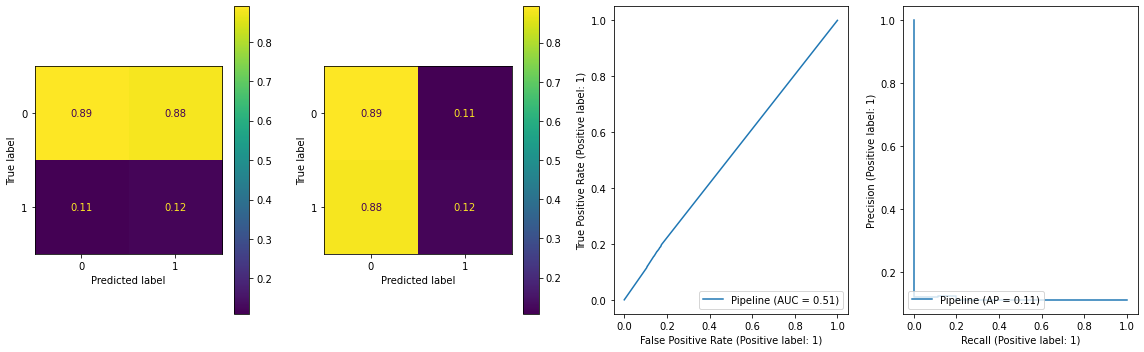

Estimating Pipeline Pipeline(steps=[('undersamp', RandomUnderSampler(random_state=7)),
                ('DecisionTree', DecisionTreeClassifier(random_state=7))])


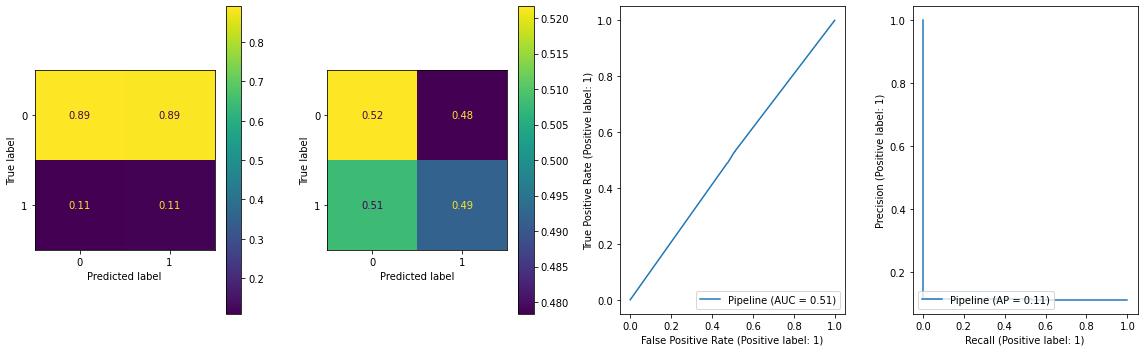

Estimating Pipeline Pipeline(steps=[('nearmiss', NearMiss()),
                ('DecisionTree', DecisionTreeClassifier(random_state=7))])


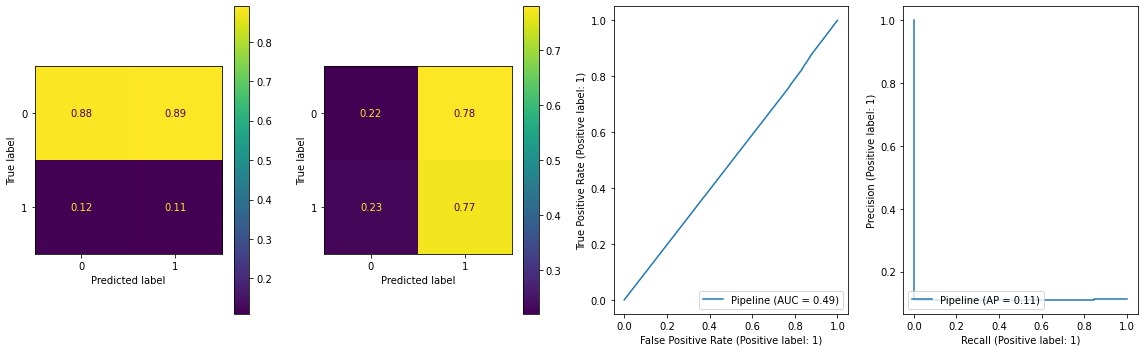

In [416]:
xtrain_test,xval,ytrain_test,yval = train_test_split(df_num_non,y_non,train_size=0.95,shuffle=True)
xtrain,xtest,ytrain,ytest = train_test_split(xtrain_test,ytrain_test,train_size=0.8,shuffle=True)
pt = PowerTransformer()
xtrain_pt = pd.DataFrame(pt.fit_transform(xtrain),index=xtrain.index,columns=xtrain.columns)
xtest_pt = pd.DataFrame(pt.transform(xtest),index=xtest.index,columns=xtest.columns)
xval_pt = pd.DataFrame(pt.transform(xval),index=xval.index,columns=xval.columns)

undersamp = RandomUnderSampler(random_state=7)
nm = NearMiss()

dtc = DecisionTreeClassifier(random_state=7)

# pipeline for each type of sampler
pipeline_0 = Pipeline([('DecisionTree', dtc)])
pipeline_1 = Pipeline([('undersamp', undersamp), ('DecisionTree', dtc)])
pipeline_2 = Pipeline([('nearmiss', nm), ('DecisionTree', dtc)])

# loop to run all pipelines
pipeline_list = [pipeline_0, pipeline_1, pipeline_2]
for num, pipeline in enumerate(pipeline_list):
    print("Estimating Pipeline {}".format(pipeline))
    pipeline.fit(xtrain_pt, ytrain)
    #y_pred = pipeline.predict(xtest_pt)
    #probs = pipeline.predict_proba(xtest_pt)[:,1]
    #print("Confusion Matrix for pipeline {}:".format(num))
    #print(confusion_matrix(ytest, y_pred))
    #cm = confusion_matrix(ytest, y_pred) 
    
    plt.figure(figsize=(16,5))
    ax1, ax2, ax3, ax4 = plt.subplot(1,4,1), plt.subplot(1,4,2), plt.subplot(1,4,3), plt.subplot(1,4,4)
    metrics.plot_confusion_matrix(pipeline, xtest_pt, ytest, labels = [0, 1], normalize='pred', ax=ax1)
    metrics.plot_confusion_matrix(pipeline, xtest_pt, ytest, labels = [0, 1], normalize='true', ax=ax2)

    metrics.plot_roc_curve(pipeline, xtest_pt, ytest, ax=ax3)
    metrics.plot_precision_recall_curve(pipeline, xtest_pt, ytest, ax=ax4)
    plt.tight_layout()
    plt.show()

# Pre Final models

In [98]:
## Data split and transformation
xtrain_test,xval,ytrain_test,yval = train_test_split(df_non_final,y_non,train_size=0.95,random_state=7)
xtrain,xtest,ytrain,ytest = train_test_split(xtrain_test,ytrain_test,train_size=0.8,random_state=7)
pt = PowerTransformer()
xtrain_pt = pd.DataFrame(pt.fit_transform(xtrain),index=xtrain.index,columns=xtrain.columns)
xtest_pt = pd.DataFrame(pt.transform(xtest),index=xtest.index,columns=xtest.columns)
xval_pt = pd.DataFrame(pt.transform(xval),index=xval.index,columns=xval.columns)

In [49]:
print('Random Undersampling\n')
rus = RandomUnderSampler(random_state=5)
xrus, yrus = rus.fit_resample(xtrain_pt,ytrain)

print('Random Oversampling\n')
ros = RandomOverSampler(random_state=5)
xros, yros = ros.fit_resample(xtrain_pt,ytrain)

Random Undersampling

Random Oversampling



### Hyperparameter tuning using GridSearchCV

### RFC

### GBC_RUS

In [46]:
model_gbc_rus = GradientBoostingClassifier(random_state=7)
params = {'max_depth':[3,5,10]}
kf = KFold(n_splits=5,shuffle=True,random_state=7)
gs = GridSearchCV(model_gbc_rus,params,scoring='roc_auc',cv=kf)
gs.fit(xrus,yrus)
gs.best_params_

{'max_depth': 3}

### GBC_ROS

# Final Model

In [111]:
## Data split and transformation
xtrain_test,xval,ytrain_test,yval = train_test_split(df_non_final,y_non,train_size=0.95,random_state=7)
xtrain,xtest,ytrain,ytest = train_test_split(xtrain_test,ytrain_test,train_size=0.8,random_state=7)
pt = PowerTransformer()
xtrain_pt = pd.DataFrame(pt.fit_transform(xtrain),index=xtrain.index,columns=xtrain.columns)
xtest_pt = pd.DataFrame(pt.transform(xtest),index=xtest.index,columns=xtest.columns)
xval_pt = pd.DataFrame(pt.transform(xval),index=xval.index,columns=xval.columns)

## Sampling
print('Random Undersampling\n')
rus = RandomUnderSampler(random_state=5)
xrus, yrus = rus.fit_resample(xtrain_pt,ytrain)

print('Random Oversampling\n')
ros = RandomOverSampler(random_state=5)
xros, yros = ros.fit_resample(xtrain_pt,ytrain)

## Training
model_rfc = RandomForestClassifier(random_state=7,criterion='entropy',max_depth=15,min_samples_leaf=50)
model_rfc.fit(xrus,yrus)
model_gbc_rus = GradientBoostingClassifier(random_state=7,max_depth=3)
model_gbc_rus.fit(xrus,yrus)
model_gbc_ros = GradientBoostingClassifier(random_state=7,max_depth=3)
model_gbc_ros.fit(xros[df_cat_non_dummy.columns],yros)

Random Undersampling

Random Oversampling



GradientBoostingClassifier(random_state=7)

# Final Model prediction

In [156]:
df_train_gbc = pd.DataFrame()
df_train_gbc['RFC_pred'], df_train_gbc['RFC_prob'] = model_rfc.predict(xtrain_pt), model_rfc.predict_proba(xtrain_pt)[:,1]
df_train_gbc['GBC_RUS_pred'], df_train_gbc['GBC_RUS_prob'] = model_gbc_rus.predict(xtrain_pt), model_gbc_rus.predict_proba(xtrain_pt)[:,1]
df_train_gbc['GBC_ROS_pred'], df_train_gbc['GBC_ROS_prob'] = model_gbc_ros.predict(xtrain_pt[df_cat_non_dummy.columns]), \
model_gbc_ros.predict_proba(xtrain_pt[df_cat_non_dummy.columns])[:,1]

In [157]:
df_train_gbc = pd.concat(objs=[df_train_gbc,ytrain.reset_index().drop(columns='index')],axis=1)
df_train_gbc.columns = ['RFC_pred','RFC_prob','GBC_RUS_pred','GBC_RUS_prob','GBC_ROS_pred','GBC_ROS_prob','Original']

In [158]:
df_train_gbc['Predicted'] = (df_train_gbc[['RFC_pred','GBC_RUS_pred','GBC_ROS_pred']]==1).any(axis=1).replace({True:1,False:0})

In [159]:
print('Random Forest Classification')
print(classification_report(df_train_gbc.Original,df_train_gbc.RFC_pred))

Random Forest Classification
              precision    recall  f1-score   support

           0       0.93      0.57      0.71     65462
           1       0.17      0.67      0.27      8370

    accuracy                           0.58     73832
   macro avg       0.55      0.62      0.49     73832
weighted avg       0.84      0.58      0.66     73832



In [112]:
df_test_gbc = pd.DataFrame()
df_test_gbc['RFC_pred'], df_test_gbc['RFC_prob'] = model_rfc.predict(xtest_pt), model_rfc.predict_proba(xtest_pt)[:,1]
df_test_gbc['GBC_RUS_pred'], df_test_gbc['GBC_RUS_prob'] = model_gbc_rus.predict(xtest_pt), model_gbc_rus.predict_proba(xtest_pt)[:,1]
df_test_gbc['GBC_ROS_pred'], df_test_gbc['GBC_ROS_prob'] = model_gbc_ros.predict(xtest_pt[df_cat_non_dummy.columns]), \
model_gbc_ros.predict_proba(xtest_pt[df_cat_non_dummy.columns])[:,1]

In [113]:
df_test_gbc = pd.concat(objs=[df_test_gbc,ytest.reset_index().drop(columns='index')],axis=1)
df_test_gbc.columns = ['RFC_pred','RFC_prob','GBC_RUS_pred','GBC_RUS_prob','GBC_ROS_pred','GBC_ROS_prob','Original']

In [114]:
df_test_gbc['Predicted'] = (df_test_gbc[['RFC_pred','GBC_RUS_pred','GBC_ROS_pred']]==1).any(axis=1).replace({True:1,False:0})

In [163]:
print('Random Forest Classification')
print(classification_report(df_test_gbc.Original,df_test_gbc.RFC_pred))

Random Forest Classification
              precision    recall  f1-score   support

           0       0.93      0.57      0.71     16382
           1       0.17      0.66      0.26      2077

    accuracy                           0.58     18459
   macro avg       0.55      0.62      0.49     18459
weighted avg       0.84      0.58      0.66     18459



In [164]:
print(classification_report(df_test_gbc.Original,df_test_gbc.GBC_RUS_pred))

              precision    recall  f1-score   support

           0       0.93      0.60      0.73     16382
           1       0.17      0.63      0.27      2077

    accuracy                           0.61     18459
   macro avg       0.55      0.62      0.50     18459
weighted avg       0.84      0.61      0.68     18459



In [165]:
print(classification_report(df_test_gbc.Original,df_test_gbc.GBC_ROS_pred))

              precision    recall  f1-score   support

           0       0.93      0.60      0.73     16382
           1       0.17      0.63      0.27      2077

    accuracy                           0.61     18459
   macro avg       0.55      0.62      0.50     18459
weighted avg       0.84      0.61      0.68     18459



In [166]:
print(classification_report(df_test_gbc.Original,df_test_gbc.Predicted))

              precision    recall  f1-score   support

           0       0.93      0.54      0.69     16382
           1       0.16      0.69      0.26      2077

    accuracy                           0.56     18459
   macro avg       0.55      0.62      0.47     18459
weighted avg       0.85      0.56      0.64     18459



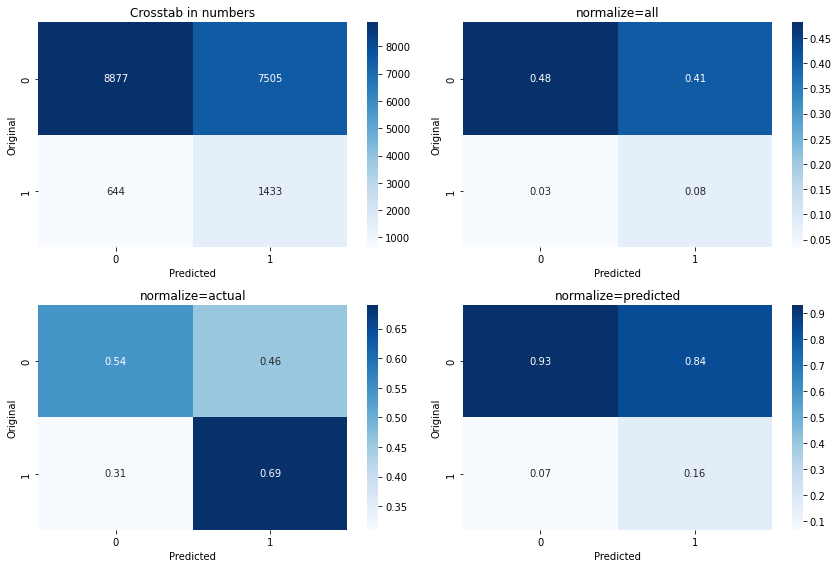

In [115]:
plt.figure(figsize=(12,8))
ax1, ax2, ax3, ax4 = plt.subplot(2,2,1), plt.subplot(2,2,2), plt.subplot(2,2,3), plt.subplot(2,2,4)
sns.heatmap(pd.crosstab(df_test_gbc.Original,df_test_gbc.Predicted),ax=ax1,annot=True,fmt='.0f',cmap='Blues')
sns.heatmap(pd.crosstab(df_test_gbc.Original,df_test_gbc.Predicted,normalize='all'),ax=ax2,annot=True,fmt='.2f',cmap='Blues')
sns.heatmap(pd.crosstab(df_test_gbc.Original,df_test_gbc.Predicted,normalize='index'),ax=ax3,annot=True,fmt='.2f',cmap='Blues')
sns.heatmap(pd.crosstab(df_test_gbc.Original,df_test_gbc.Predicted,normalize='columns'),ax=ax4,annot=True,fmt='.2f',cmap='Blues')
ax1.set_title('Crosstab in numbers')
ax2.set_title('normalize=all')
ax3.set_title('normalize=actual')
ax4.set_title('normalize=predicted')
plt.tight_layout()
plt.savefig('Final model non outliers crosstab.jpg')
plt.show()
#print(pd.crosstab(df_test_gbc.Original,(df_test_gbc[['RFC_pred','GBC_RUS_pred','GBC_ROS_pred']]==1).any(axis=1),normalize='all'))
#print(pd.crosstab(df_test_gbc.Original,(df_test_gbc[['RFC_pred','GBC_RUS_pred','GBC_ROS_pred']]==1).any(axis=1),normalize='index'))
#print(pd.crosstab(df_test_gbc.Original,(df_test_gbc[['RFC_pred','GBC_RUS_pred','GBC_ROS_pred']]==1).any(axis=1),normalize='columns'))

|Outliers|

In [57]:
df_out_final.head()

,time_in_hospital,num_lab_procedures,num_procedures,number_inpatient_1-5,number_inpatient_5-10,number_inpatient_10-20,number_inpatient_>20,discharge_disposition_id_Home,discharge_disposition_id_Hospice,discharge_disposition_id_Transfer,...,diag_2_Infectious_Parasitic,diag_2_Injury_Poisoning,diag_2_Mental_Disorders,diag_2_Musculoskeletal_System,diag_2_Neoplasms,diag_2_Nervous_System,diag_2_Respiratory_System,diag_2_SC_Contact_Health_Services,diag_2_SC_Injury_Poisoning,diag_2_Skin
106,9,96,3,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
149,8,61,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
336,12,103,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
361,8,77,4,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
411,8,76,6,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Logistic Regression

### Both numerical and categorical variables

Without sampling techniques
56 -----> 8
RandomUnderSampling
56 -----> 9
Near miss Undersampling
56 -----> 20
RandomOverSampling
56 -----> 20
SMOTE-Oversampling
56 -----> 24
Borderline-SMOTE
56 -----> 24
ADASYN-Oversampling
56 -----> 23
Completed


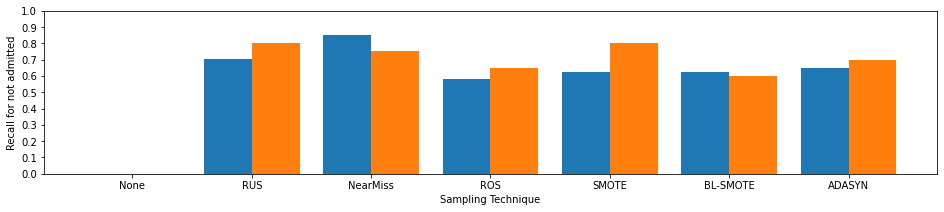

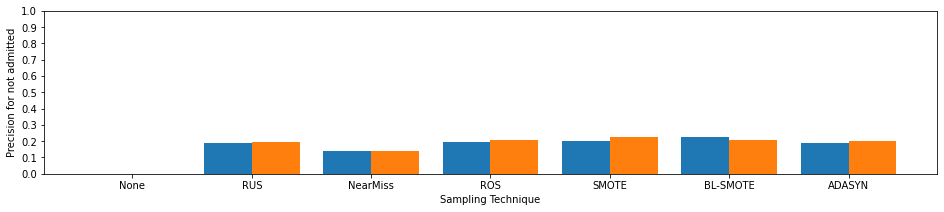

,Sampling_Type,Set_Type,Precision_0,Precision_1,Recall_0,Recall_1,F_score_0,F_score_1,Accuracy,roc_auc
None_Train,None,Train,0.869778,1.000000,1.000000,0.006780,0.930354,0.013468,0.869893,0.641603
None_Test,None,Test,0.868794,0.000000,1.000000,0.000000,0.929791,0.000000,0.868794,0.648842
None_Val,None,Val,0.865772,0.000000,1.000000,0.000000,0.928058,0.000000,0.865772,0.605620
RUS_Train,RUS,Train,0.614545,0.600000,0.572881,0.640678,0.592982,0.619672,0.606780,0.634674
RUS_Test,RUS,Test,0.924915,0.191882,0.553061,0.702703,0.692209,0.301449,0.572695,0.650814
RUS_Val,RUS,Val,0.940299,0.195122,0.488372,0.800000,0.642857,0.313725,0.530201,0.629651
NearMiss_Train,NearMiss,Train,0.877483,0.895833,0.898305,0.874576,0.887772,0.885077,0.886441,0.943321
NearMiss_Test,NearMiss,Test,0.901786,0.139381,0.206122,0.851351,0.335548,0.239544,0.290780,0.589437
NearMiss_Val,NearMiss,Val,0.880952,0.140187,0.286822,0.750000,0.432749,0.236220,0.348993,0.562209
ROS_Train,ROS,Train,0.630341,0.648280,0.670925,0.606541,0.650000,0.626716,0.638733,0.673146


In [58]:
lr_model_score_out_all = lr_model(df_out_final,y_out)
lr_model_score_out_all

In [59]:
lr_model_score_out_all.to_csv('lr_model_score_out_all.csv')

### Only categorical variables

Without sampling techniques
53 -----> 8
RandomUnderSampling
53 -----> 9
Near miss Undersampling
53 -----> 20
RandomOverSampling
53 -----> 17
SMOTE-Oversampling
53 -----> 24
Borderline-SMOTE
53 -----> 28
ADASYN-Oversampling
53 -----> 26
Completed


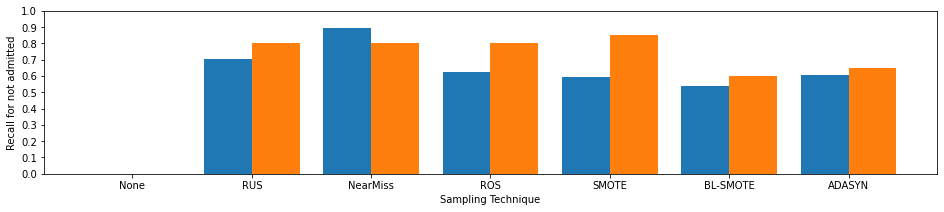

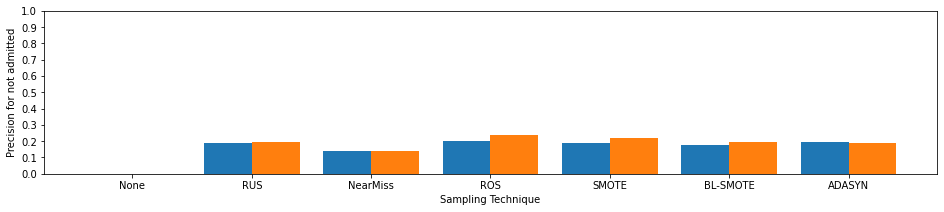

In [60]:
#df_num_non,df_cat_non_dummy
lr_model_score_out_cat = lr_model(df_cat_out_dummy,y_out)
lr_model_score_out_cat.to_csv('lr_model_score_out_cat.csv')

### Only numerical variables

Without sampling techniques
3 -----> 2
RandomUnderSampling
3 -----> 2
Near miss Undersampling
3 -----> 3
RandomOverSampling
3 -----> 3
SMOTE-Oversampling
3 -----> 3
Borderline-SMOTE
3 -----> 3
ADASYN-Oversampling
3 -----> 2
Completed


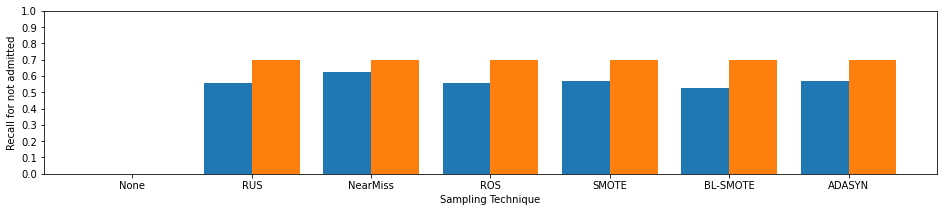

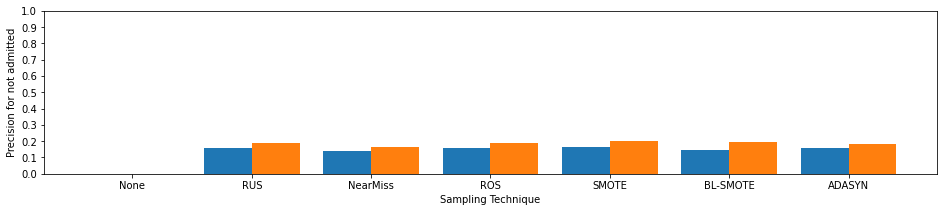

In [61]:
#df_num_non,df_cat_non_dummy
lr_model_score_out_num = lr_model(df_num_out,y_out)
lr_model_score_out_num.to_csv('lr_model_score_out_num.csv')

# Gaussian Naives Bayes Classifier

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


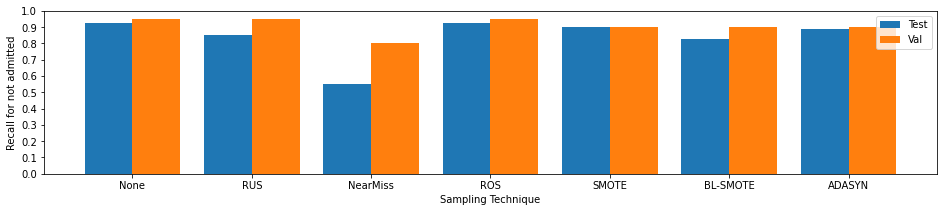

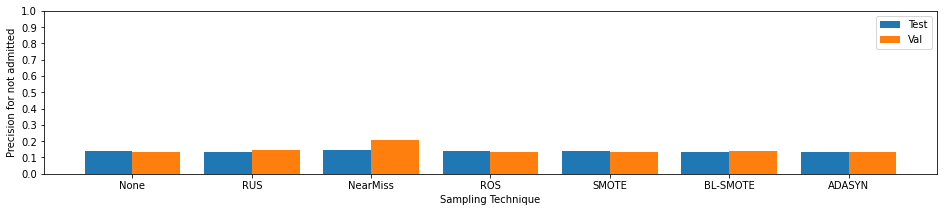

In [63]:
gnb_model_score_out_all = gnb_model(df_out_final,y_out)
gnb_model_score_out_all.to_csv('gnb_model_score_out_all.csv')

### Only categorical variables

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


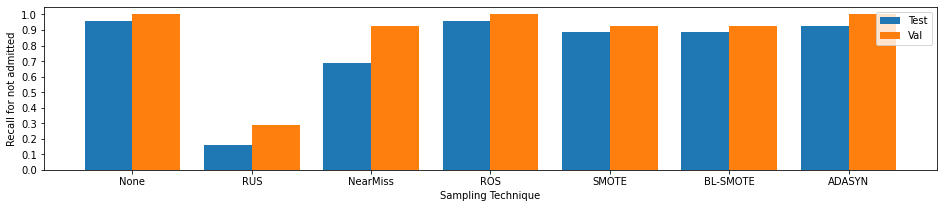

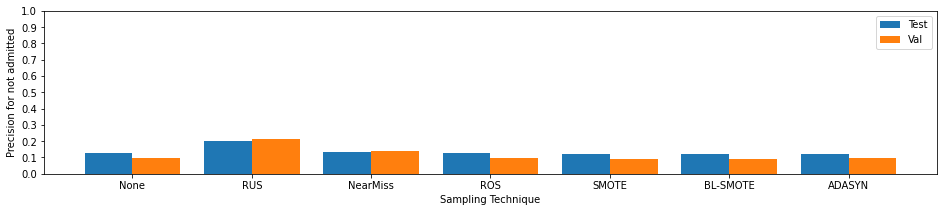

In [64]:
#df_num_non,df_cat_non_dummy
gnb_model_score_out_cat = gnb_model(df_cat_out_dummy,y_out)
gnb_model_score_out_cat.to_csv('gnb_model_score_out_cat.csv')

### Only numerical variables

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


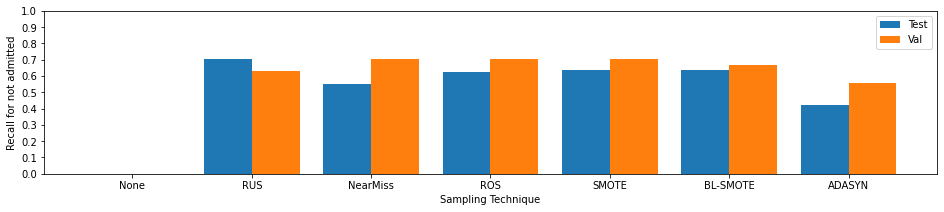

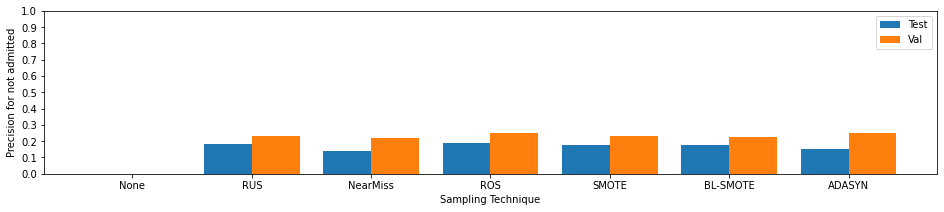

In [65]:
#df_num_non,df_cat_non_dummy
gnb_model_score_out_num = gnb_model(df_num_out,y_out)
gnb_model_score_out_num.to_csv('gnb_model_score_out_num.csv')

# Decision Tree Classifier

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


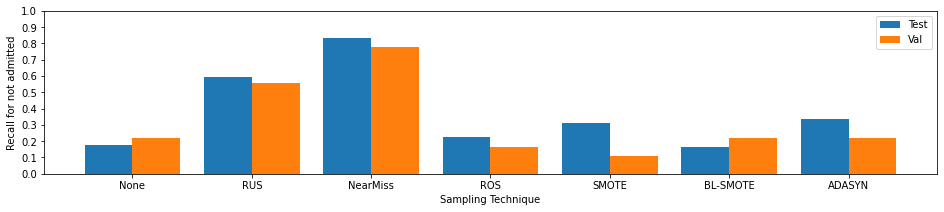

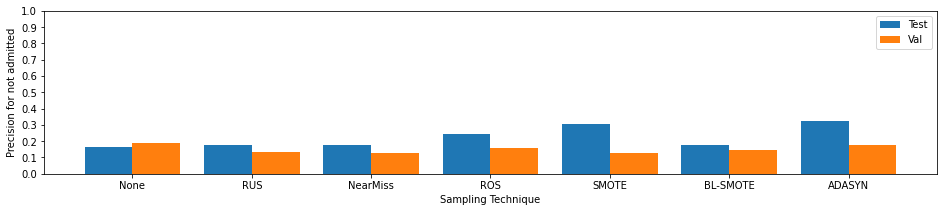

In [67]:
dtc_model_score_out_all = dtc_model(df_out_final,y_out)
dtc_model_score_out_all.to_csv('dtc_model_score_out_all.csv')

### Only categorical variables

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


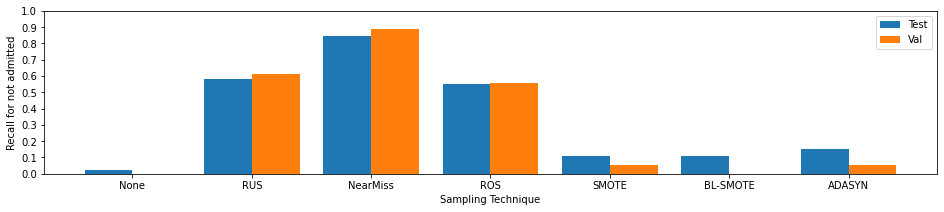

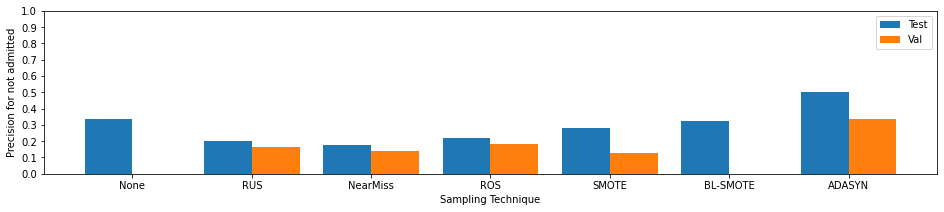

In [82]:
#df_num_non,df_cat_non_dummy
dtc_model_score_out_cat = dtc_model(df_cat_out_dummy,y_out)
dtc_model_score_out_cat.to_csv('dtc_model_score_out_cat.csv')

### Only numerical variables

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


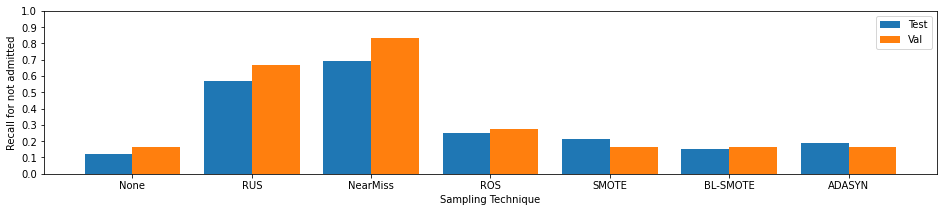

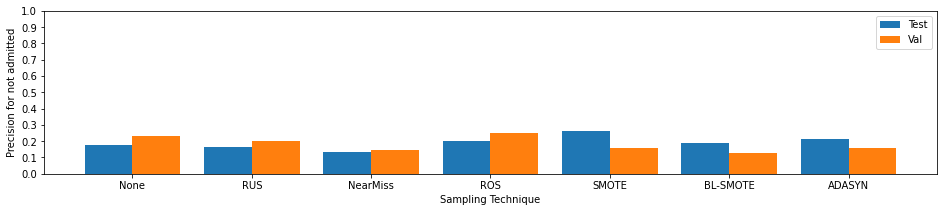

In [68]:
#df_num_non,df_cat_non_dummy
dtc_model_score_out_num = dtc_model(df_num_out,y_out)
dtc_model_score_out_num.to_csv('dtc_model_score_out_num.csv')

# Random Forest Classifier

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


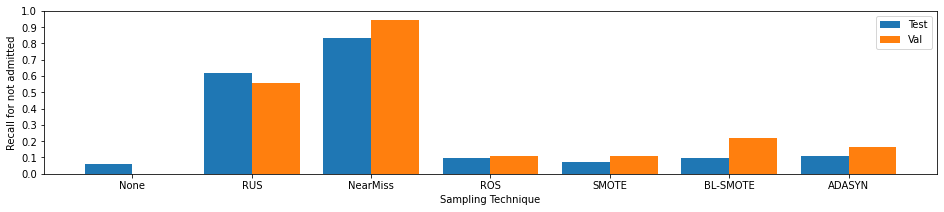

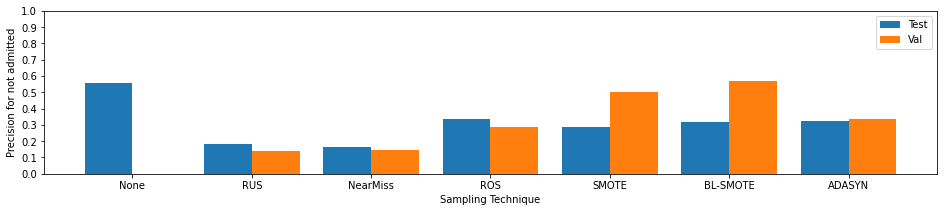

In [70]:
rfc_model_score_out_all = rfc_model(df_out_final,y_out)
rfc_model_score_out_all.to_csv('rfc_model_score_out_all.csv')

### Only categorical variables

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


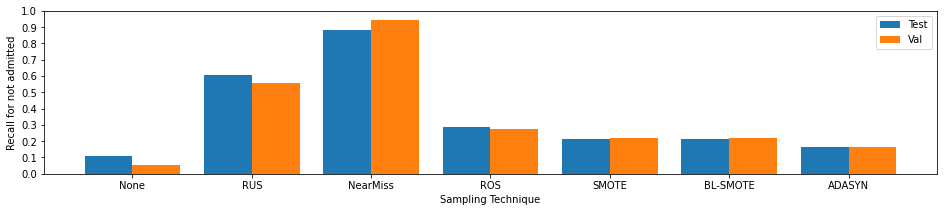

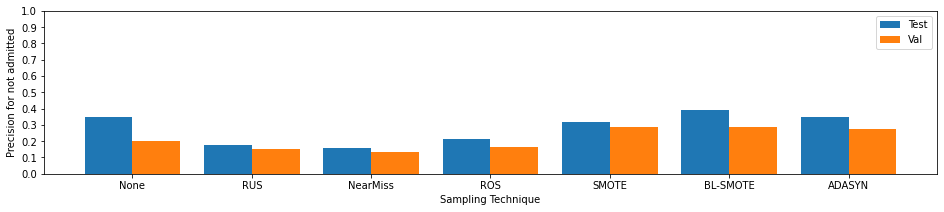

In [71]:
#df_num_non,df_cat_non_dummy
rfc_model_score_out_cat = rfc_model(df_cat_out_dummy,y_out)
rfc_model_score_out_cat.to_csv('rfc_model_score_out_cat.csv')

### Only numerical variables

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


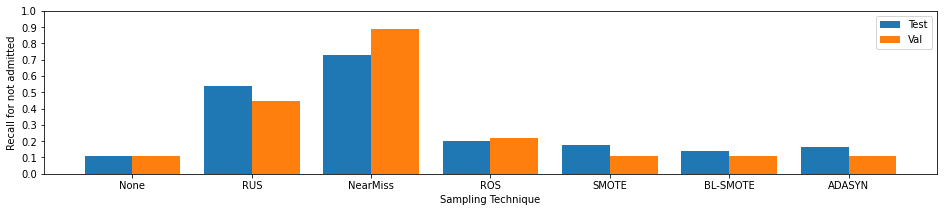

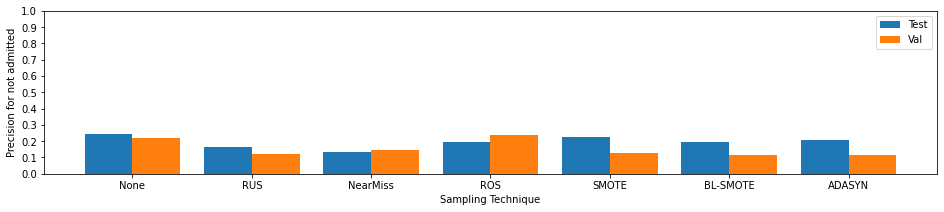

In [72]:
#df_num_non,df_cat_non_dummy
rfc_model_score_out_num = rfc_model(df_num_out,y_out)
rfc_model_score_out_num.to_csv('rfc_model_score_out_num.csv')

# GradientBoostingClassifier

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


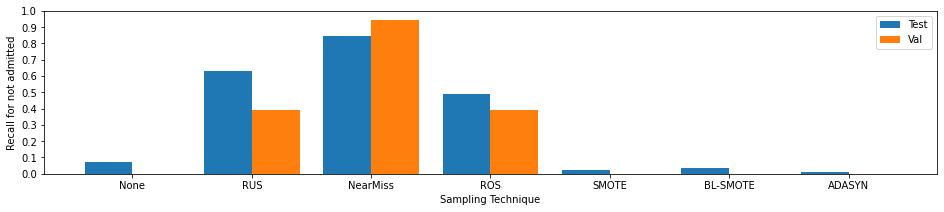

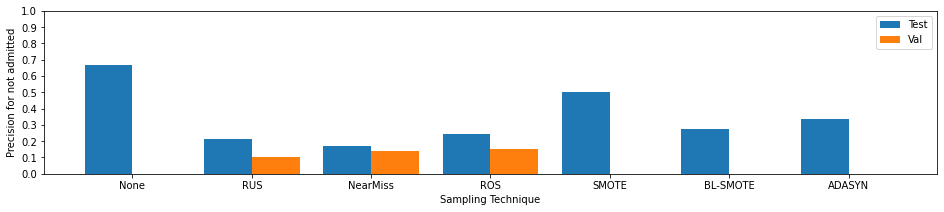

In [75]:
gbc_model_score_out_all = gbc_model(df_out_final,y_out)
gbc_model_score_out_all.to_csv('gbc_model_score_out_all.csv')

### Only categorical variables

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


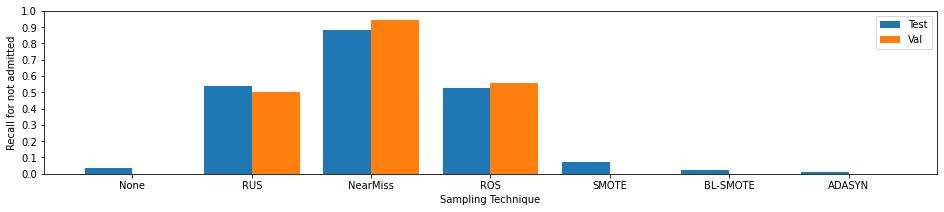

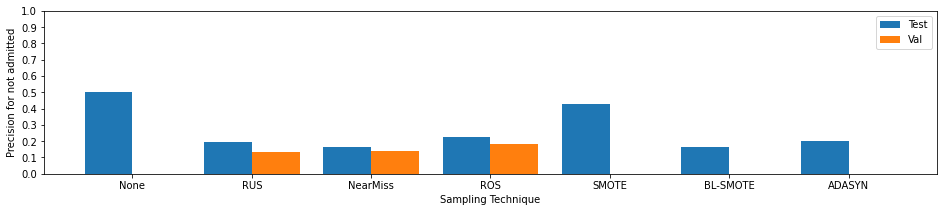

In [76]:
#df_num_non,df_cat_non_dummy
gbc_model_score_out_cat = gbc_model(df_cat_out_dummy,y_out)
gbc_model_score_out_cat.to_csv('gbc_model_score_out_cat.csv')

### Only numerical variables

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


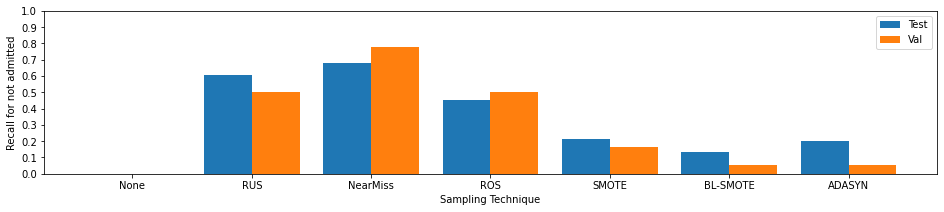

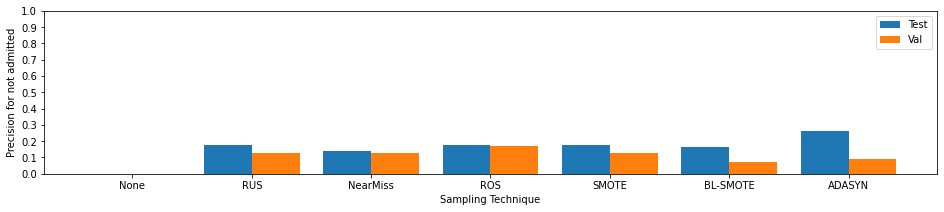

In [77]:
#df_num_non,df_cat_non_dummy
gbc_model_score_out_num = gbc_model(df_num_out,y_out)
gbc_model_score_out_num.to_csv('gbc_model_score_out_num.csv')

# AdaBoostClassifier

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


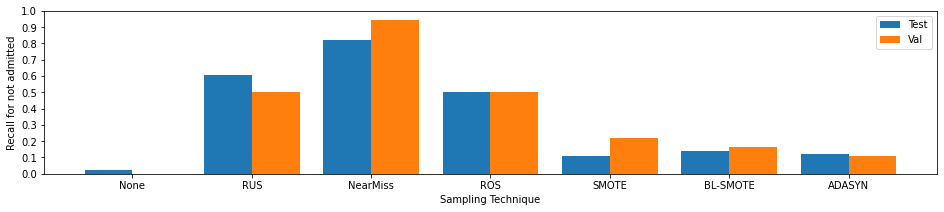

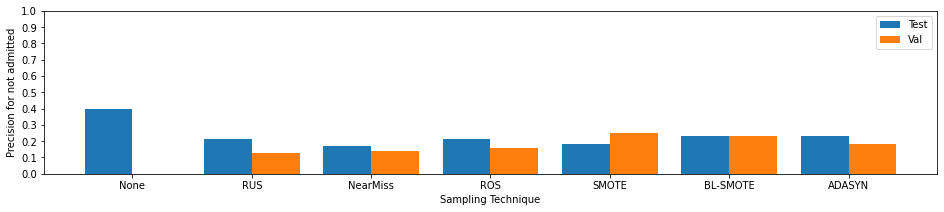

In [79]:
abc_model_score_out_all = abc_model(df_out_final,y_out)
abc_model_score_out_all.to_csv('abc_model_score_out_all.csv')

### Only categorical variables

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


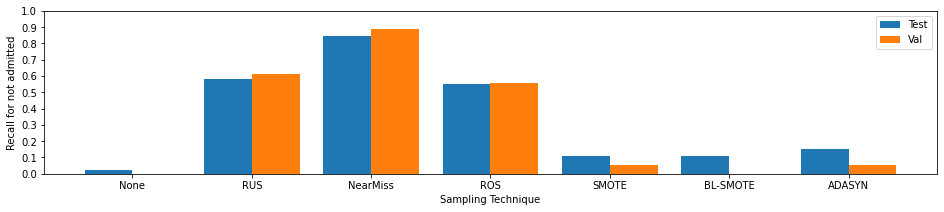

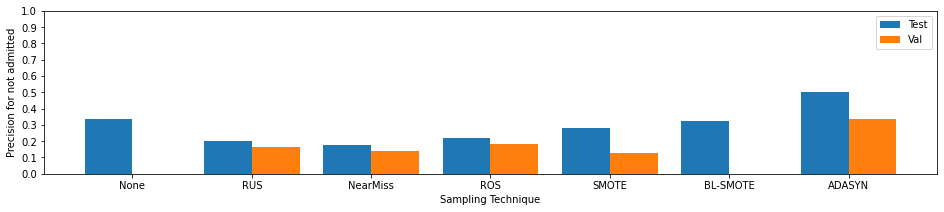

In [80]:
#df_num_non,df_cat_non_dummy
abc_model_score_out_cat = abc_model(df_cat_out_dummy,y_out)
abc_model_score_out_cat.to_csv('abc_model_score_out_cat.csv')

### Only numerical variables

Without sampling techniques
RandomUnderSampling
Near miss Undersampling
RandomOverSampling
SMOTE-Oversampling
Borderline-SMOTE
ADASYN-Oversampling
Completed


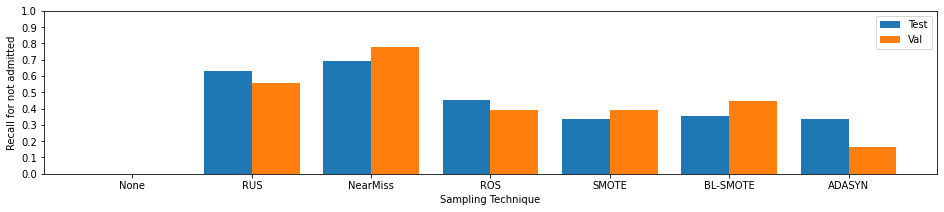

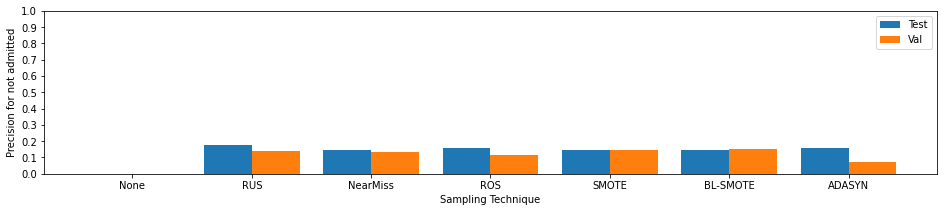

In [81]:
#df_num_non,df_cat_non_dummy
abc_model_score_out_num = abc_model(df_num_out,y_out)
abc_model_score_out_num.to_csv('abc_model_score_out_num.csv')

# Pre Final models

In [211]:
xtest.shape

(564, 56)

In [212]:
## Data split and transformation
xtrain_test,xval,ytrain_test,yval = train_test_split(df_out_final,y_out,train_size=0.95,random_state=7)
xtrain,xtest,ytrain,ytest = train_test_split(xtrain_test,ytrain_test,train_size=0.8,random_state=7)
pt = PowerTransformer()
xtrain_pt = pd.DataFrame(pt.fit_transform(xtrain),index=xtrain.index,columns=xtrain.columns)
xtest_pt = pd.DataFrame(pt.transform(xtest),index=xtest.index,columns=xtest.columns)
xval_pt = pd.DataFrame(pt.transform(xval),index=xval.index,columns=xval.columns)

In [213]:
#Feature Selection by Recursive Backward Elimination
cols = list(xtrain_pt.columns)
org_len = len(cols)
pmax = 1
while (len(cols)>0):
    p= []
    X_lr = xtrain_pt[cols]
    Xc_lr = sm.add_constant(X_lr,has_constant='add')
    model_out = sm.OLS(ytrain,Xc_lr).fit()
    p = pd.Series(model_out.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
significant_features_final = cols
print(org_len,'----->',len(significant_features_final))
print(significant_features_final)

56 -----> 13
['num_lab_procedures', 'number_inpatient_1-5', 'number_inpatient_5-10', 'number_inpatient_10-20', 'discharge_disposition_id_Home', 'discharge_disposition_id_Hospice', 'diag_3_Genitourinary_System', 'diag_3_Injury_Poisoning', 'number_emergency_5-10', 'admission_source_id_Emergency', 'admission_source_id_Referral', 'diag_2_Endocrine', 'diag_2_Neoplasms']


In [214]:
print('Random Undersampling\n')
rus = RandomUnderSampler(random_state=5)
xrus, yrus = rus.fit_resample(xtrain_pt,ytrain)

print('SMOTE\n')
smt = SMOTE(random_state=5)
xsmt, ysmt = smt.fit_resample(xtrain_pt[significant_features_final],ytrain)

print('Borderline - SMOTE\n')
bsmt = BorderlineSMOTE(random_state=5)
xbsmt, ybsmt = bsmt.fit_resample(xtrain_pt[significant_features_final],ytrain)

Random Undersampling

SMOTE

Borderline - SMOTE



### Hyperparameter tuning using GridSearchCV

### GBC_RUS

In [215]:
model_gbc_rus = GradientBoostingClassifier(random_state=7)
params = {'max_depth':[3,5,10]}
kf = KFold(n_splits=5,shuffle=True,random_state=7)
gs = GridSearchCV(model_gbc_rus,params,scoring='roc_auc',cv=kf)
gs.fit(xrus,yrus)
gs.best_params_

{'max_depth': 3}

# Final Model

In [216]:
## Data split and transformation
xtrain_test,xval,ytrain_test,yval = train_test_split(df_out_final,y_out,train_size=0.95,random_state=7)
xtrain,xtest,ytrain,ytest = train_test_split(xtrain_test,ytrain_test,train_size=0.8,random_state=7)
pt = PowerTransformer()
xtrain_pt = pd.DataFrame(pt.fit_transform(xtrain),index=xtrain.index,columns=xtrain.columns)
xtest_pt = pd.DataFrame(pt.transform(xtest),index=xtest.index,columns=xtest.columns)
xval_pt = pd.DataFrame(pt.transform(xval),index=xval.index,columns=xval.columns)

#Feature Selection by Recursive Backward Elimination
cols = list(xtrain_pt.columns)
org_len = len(cols)
pmax = 1
while (len(cols)>0):
    p= []
    X_lr = xtrain_pt[cols]
    Xc_lr = sm.add_constant(X_lr,has_constant='add')
    model_out = sm.OLS(ytrain,Xc_lr).fit()
    p = pd.Series(model_out.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
significant_features_final = cols
print(org_len,'----->',len(significant_features_final))
print(significant_features_final)

print('\nRandom Undersampling\n')
rus = RandomUnderSampler(random_state=5)
xrus, yrus = rus.fit_resample(xtrain_pt,ytrain)

print('SMOTE\n')
smt = SMOTE(random_state=5)
xsmt, ysmt = smt.fit_resample(xtrain_pt[significant_features_final],ytrain)

print('Borderline - SMOTE\n')
bsmt = BorderlineSMOTE(random_state=5)
xbsmt, ybsmt = bsmt.fit_resample(xtrain_pt[significant_features_final],ytrain)

56 -----> 13
['num_lab_procedures', 'number_inpatient_1-5', 'number_inpatient_5-10', 'number_inpatient_10-20', 'discharge_disposition_id_Home', 'discharge_disposition_id_Hospice', 'diag_3_Genitourinary_System', 'diag_3_Injury_Poisoning', 'number_emergency_5-10', 'admission_source_id_Emergency', 'admission_source_id_Referral', 'diag_2_Endocrine', 'diag_2_Neoplasms']

Random Undersampling

SMOTE

Borderline - SMOTE



In [217]:
## Training
model_gbc_rus_out = GradientBoostingClassifier(random_state=7)
model_gbc_rus_out.fit(xrus,yrus)

model_lr_smt_out = LogisticRegression(random_state=7)
model_lr_smt_out.fit(xsmt,ysmt)

model_lr_bsmt_out = LogisticRegression(random_state=7)
model_lr_bsmt_out.fit(xbsmt,ybsmt)

LogisticRegression(random_state=7)

# Final Model prediction

In [218]:
xtest_pt.shape

(564, 56)

In [219]:
df_train_out = pd.DataFrame()
df_train_out['GBC_RUS_pred'], df_train_out['GBC_RUS_prob'] = model_gbc_rus_out.predict(xtrain_pt),\
model_gbc_rus_out.predict_proba(xtrain_pt)[:,1]
df_train_out['LR_SMT_pred'], df_train_out['LR_SMT_prob'] = model_lr_smt_out.predict(xtrain_pt[significant_features_final]),\
model_lr_smt_out.predict_proba(xtrain_pt[significant_features_final])[:,1]
df_train_out['LR_BSMT_pred'], df_train_out['LR_BSMT_prob'] = model_lr_bsmt_out.predict(xtrain_pt[significant_features_final]), \
model_lr_bsmt_out.predict_proba(xtrain_pt[significant_features_final])[:,1]

In [220]:
df_train_out = pd.concat(objs=[df_train_out,ytrain.reset_index().drop(columns='index')],axis=1)
df_train_out.columns = ['GBC_RUS_pred','GBC_RUS_prob','LR_SMT_pred','LR_SMT_prob','LR_BSMT_pred','LR_BSMT_prob','Original']

In [221]:
df_train_out['Predicted'] = (df_train_out[['GBC_RUS_pred','LR_SMT_pred','LR_BSMT_pred']]==1).any(axis=1).replace({True:1,False:0})

In [201]:
print('Random Forest Classification')
print(classification_report(df_train_out.Original,df_train_out.Predicted))

Random Forest Classification
              precision    recall  f1-score   support

           0       0.95      0.52      0.67      1965
           1       0.20      0.82      0.32       287

    accuracy                           0.56      2252
   macro avg       0.58      0.67      0.50      2252
weighted avg       0.86      0.56      0.63      2252



In [233]:
df_test_out = pd.DataFrame()
df_test_out['GBC_RUS_pred'], df_test_out['GBC_RUS_prob'] = model_gbc_rus_out.predict(xtest_pt),\
model_gbc_rus_out.predict_proba(xtest_pt)[:,1]
df_test_out['LR_SMT_pred'], df_test_out['LR_SMT_prob'] = model_lr_smt_out.predict(xtest_pt[significant_features_final]),\
model_lr_smt_out.predict_proba(xtest_pt[significant_features_final])[:,1]
df_test_out['LR_BSMT_pred'], df_test_out['LR_BSMT_prob'] = model_lr_bsmt_out.predict(xtest_pt[significant_features_final]), \
model_lr_bsmt_out.predict_proba(xtest_pt[significant_features_final])[:,1]

In [234]:
df_test_out = pd.concat(objs=[df_test_out,ytest.reset_index().drop(columns='index')],axis=1)
df_test_out.columns = ['GBC_RUS_pred','GBC_RUS_prob','LR_SMT_pred','LR_SMT_prob','LR_BSMT_pred','LR_BSMT_prob','Original']

In [235]:
df_test_out['Predicted'] = (df_test_out[['GBC_RUS_pred','LR_SMT_pred','LR_BSMT_pred']]==1).any(axis=1).replace({True:1,False:0})

In [237]:
print('\t  Gradient Boosting Classification - RUS')
print(classification_report(df_test_out.Original,df_test_out.GBC_RUS_pred))

	  Gradient Boosting Classification - RUS
              precision    recall  f1-score   support

           0       0.90      0.64      0.75       480
           1       0.23      0.60      0.33        84

    accuracy                           0.64       564
   macro avg       0.56      0.62      0.54       564
weighted avg       0.80      0.64      0.69       564



In [238]:
print('\t\tLogistic Regression - SMOTE')
print(classification_report(df_test_out.Original,df_test_out.LR_SMT_pred))

		Logistic Regression - SMOTE
              precision    recall  f1-score   support

           0       0.89      0.66      0.76       480
           1       0.22      0.55      0.31        84

    accuracy                           0.64       564
   macro avg       0.56      0.60      0.53       564
weighted avg       0.79      0.64      0.69       564



In [239]:
print('\t   Logistic Regression - Borderline SMOTE')
print(classification_report(df_test_out.Original,df_test_out.LR_BSMT_pred))

	   Logistic Regression - Borderline SMOTE
              precision    recall  f1-score   support

           0       0.89      0.66      0.76       480
           1       0.21      0.52      0.30        84

    accuracy                           0.64       564
   macro avg       0.55      0.59      0.53       564
weighted avg       0.79      0.64      0.69       564



In [240]:
print('Final model Classification')
print(classification_report(df_test_out.Original,df_test_out.Predicted))

Final model Classification
              precision    recall  f1-score   support

           0       0.91      0.49      0.63       480
           1       0.20      0.71      0.31        84

    accuracy                           0.52       564
   macro avg       0.55      0.60      0.47       564
weighted avg       0.80      0.52      0.59       564



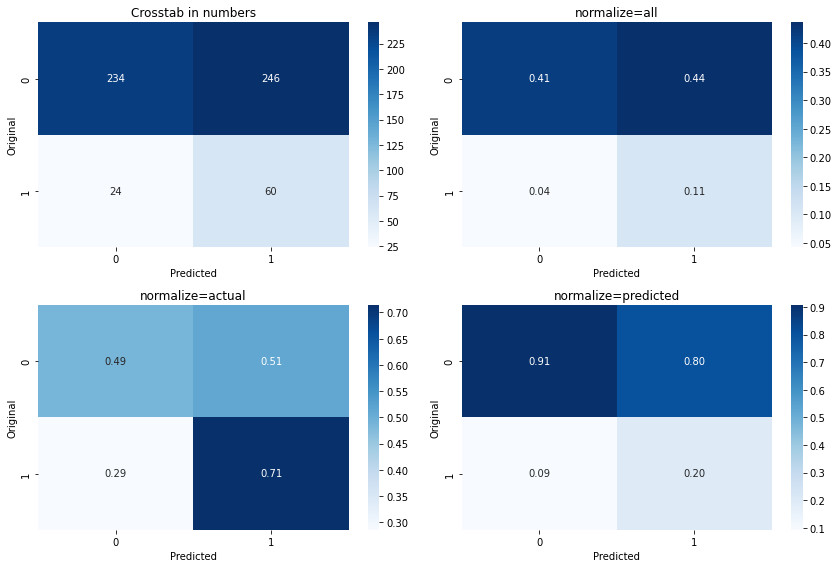

In [241]:
plt.figure(figsize=(12,8))
ax1, ax2, ax3, ax4 = plt.subplot(2,2,1), plt.subplot(2,2,2), plt.subplot(2,2,3), plt.subplot(2,2,4)
sns.heatmap(pd.crosstab(df_test_out.Original,df_test_out.Predicted),ax=ax1,annot=True,fmt='.0f',cmap='Blues')
sns.heatmap(pd.crosstab(df_test_out.Original,df_test_out.Predicted,normalize='all'),ax=ax2,annot=True,fmt='.2f',cmap='Blues')
sns.heatmap(pd.crosstab(df_test_out.Original,df_test_out.Predicted,normalize='index'),ax=ax3,annot=True,fmt='.2f',cmap='Blues')
sns.heatmap(pd.crosstab(df_test_out.Original,df_test_out.Predicted,normalize='columns'),ax=ax4,annot=True,fmt='.2f',cmap='Blues')
ax1.set_title('Crosstab in numbers')
ax2.set_title('normalize=all')
ax3.set_title('normalize=actual')
ax4.set_title('normalize=predicted')
plt.tight_layout()
plt.savefig('Final model crosstab.jpg')
plt.show()
#print(pd.crosstab(df_test_gbc.Original,(df_test_gbc[['RFC_pred','GBC_RUS_pred','GBC_ROS_pred']]==1).any(axis=1),normalize='all'))
#print(pd.crosstab(df_test_gbc.Original,(df_test_gbc[['RFC_pred','GBC_RUS_pred','GBC_ROS_pred']]==1).any(axis=1),normalize='index'))
#print(pd.crosstab(df_test_gbc.Original,(df_test_gbc[['RFC_pred','GBC_RUS_pred','GBC_ROS_pred']]==1).any(axis=1),normalize='columns'))